In [1]:
# from vit_pytorch import ViT
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from frequency_augmentations import rearrange_matrix, concentric_square_bandwidth_filter
from vit_adjust import ViT  

In [2]:
class TwoChannelsToComplex(nn.Module):
    def __init__(self):
        super(TwoChannelsToComplex, self).__init__()

    def forward(self, x):
        real, imag = torch.chunk(x, 2, dim=1)
        complex_tensor = torch.complex(real.squeeze(1), imag.squeeze(1))
        return complex_tensor
class ComplexToTwoChannels(nn.Module):
    def __init__(self):
        super(ComplexToTwoChannels, self).__init__()

    def forward(self, x):
        real = x.real.unsqueeze(1)
        imag = x.imag.unsqueeze(1)
        two_channel_tensor = torch.cat((real, imag), dim=1)
        return two_channel_tensor

class InverseFourierTransform2D(nn.Module):
    def __init__(self, norm='ortho'):
        super(InverseFourierTransform2D, self).__init__()
        self.norm = norm

    def forward(self, x):
        return torch.fft.ifft2(x, norm=self.norm)

In [3]:

transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

In [4]:
def fft_transform(data):
    processed_data = []
    for img, _ in data:
        img_np = img.numpy().squeeze()
        fft = np.fft.fft2(img_np)
        processed_data.append((img_np, fft))
    return processed_data

train_fft = fft_transform(train_data)
test_fft = fft_transform(test_data)

def normalize_fft(fft_data):
    normalized_data = []
    for img_np, fft in fft_data:
        # Calculate magnitude and phase
        magnitude = np.abs(fft)
        phase = np.angle(fft)
        
        # Normalize magnitude to [0, 1] range
        magnitude_min = np.min(magnitude)
        magnitude_max = np.max(magnitude)
        normalized_magnitude = (magnitude - magnitude_min) / (magnitude_max - magnitude_min)
        
        # Rebuild complex number using normalized magnitude and original phase
        normalized_fft = normalized_magnitude * np.exp(1j * phase)
        
        normalized_data.append((img_np, normalized_fft))
    
    return normalized_data

# train_fft = normalize_fft(train_fft)
# test_fft = normalize_fft(test_fft)

/tmp/ipykernel_10000/3824567529.py:62: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(result)), cmap="gray")


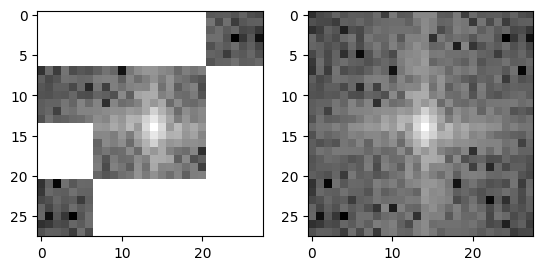

In [5]:
import math
def mask_frequency_spectrum_patches(spectrum, patch_size, max_mask_percentage=75):
    """
    This function masks out full patches of the frequency spectrum.
    
    Input:
    - spectrum: The frequency spectrum (centered or uncentered) as a 2D tensor
    - patch_size: The size of each square patch
    - max_mask_percentage: Maximum percentage of patches to mask (default: 75)
    
    Output:
    - The masked frequency spectrum
    """
    # Ensure the max_mask_percentage is between 0 and 100
    max_mask_percentage = torch.clamp(torch.tensor(max_mask_percentage), 0, 100)
    
    # Calculate the number of patches
    h, w = spectrum.shape
    num_patches_h = math.ceil(h / patch_size)
    num_patches_w = math.ceil(w / patch_size)
    total_patches = num_patches_h * num_patches_w
    
    # Generate a random mask percentage
    mask_percentage = torch.rand(1) * max_mask_percentage
    
    # Calculate the number of patches to mask
    num_masked_patches = math.ceil(total_patches * mask_percentage.item() / 100)
    
    # Create a mask for patches
    patch_mask = torch.ones(num_patches_h, num_patches_w, dtype=torch.bool)
    flat_patch_mask = patch_mask.view(-1)
    
    # Randomly select patches to mask
    mask_indices = torch.randperm(total_patches)[:num_masked_patches]
    flat_patch_mask[mask_indices] = False
    patch_mask = flat_patch_mask.view(num_patches_h, num_patches_w)
    
    # Create the full mask
    mask = torch.ones_like(spectrum, dtype=torch.bool)
    for i in range(num_patches_h):
        for j in range(num_patches_w):
            if not patch_mask[i, j]:
                top = i * patch_size
                left = j * patch_size
                bottom = min((i + 1) * patch_size, h)
                right = min((j + 1) * patch_size, w)
                mask[top:bottom, left:right] = False
    
    # Apply the mask
    masked_spectrum = spectrum.clone()
    masked_spectrum[~mask] = 0
    
    return masked_spectrum



# Example usage
data = torch.tensor(train_fft[0][1])
result = mask_frequency_spectrum_patches(torch.fft.fftshift(data), patch_size=7)

plt.subplot(1,2,1)
plt.imshow(np.log(np.abs(result)), cmap="gray")
plt.subplot(1,2,2)
plt.imshow(np.log(np.abs(np.fft.fftshift(data))), cmap="gray")

/tmp/ipykernel_10000/390381072.py:3: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(filtered)), cmap="gray")


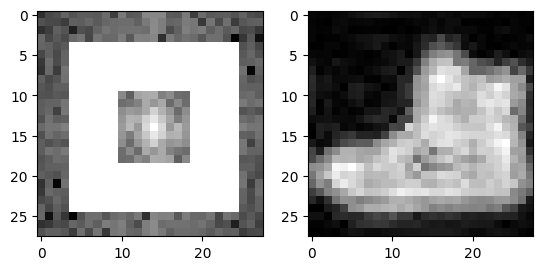

In [6]:
filtered = concentric_square_bandwidth_filter(torch.fft.fftshift(data), min_size=0, max_size=None, band_width=None)
plt.subplot(1,2,1)
plt.imshow(np.log(np.abs(filtered)), cmap="gray")
plt.subplot(1,2,2)
plt.imshow(np.abs(np.fft.ifft2(np.fft.fftshift(filtered))), cmap="gray")

1.0 0.0 (299.0078472062014+0j) (-105.1554452474781-85.19899857776973j)


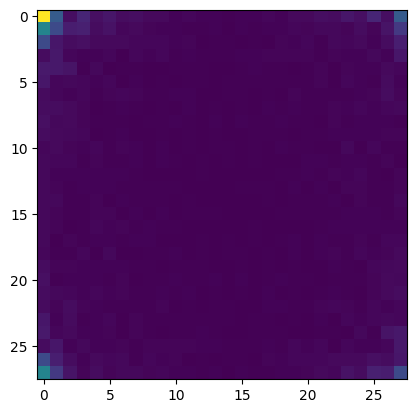

In [7]:
plt.imshow(np.abs(train_fft[0])[1])
print(train_fft[0][0].max(), train_fft[0][0].min(), train_fft[0][1].max(), train_fft[0][1].min())

In [8]:
def phase_shift_fourier(fourier_image, x=2.0, y=2.0):
    """
    Perform a random phase shift on a Fourier-image, constrained by maximum values.
    
    Parameters:
    fourier_image (torch.tensor): Complex-valued centered Fourier representation of an image
    x (float): Maximum amount to shift in x direction (0-2 range recommended due to 2pi periodicity)
    y (float): Maximum amount to shift in y direction (0-2 range recommended due to 2pi periodicity)
    
    Returns:
    torch.tensor: The phase-shifted Fourier-image
    """
    fourier_image = torch.fft.fftshift(fourier_image)
    rows, cols = fourier_image.shape
    
    # Generate random shift amounts within the specified ranges
    random_x = torch.rand(1).item() * x
    random_y = torch.rand(1).item() * y
    shift_x = random_y * torch.pi * rows
    shift_y = random_x * torch.pi * cols
    
    freq_x = torch.fft.fftfreq(cols)
    freq_y = torch.fft.fftfreq(rows)
    fx, fy = torch.meshgrid(freq_x, freq_y, indexing='ij')
    
    # Calculate and apply phase shift
    phase_shift = torch.exp(-1j * (shift_x * fx + shift_y * fy))
    shifted_fourier_image = torch.fft.fftshift(fourier_image * phase_shift)
    
    return shifted_fourier_image


def mask_frequency_spectrum(spectrum, max_mask_percentage):
    # Ensure the max_mask_percentage is between 0 and 100
    max_mask_percentage = torch.clamp(torch.tensor(max_mask_percentage), 0, 100)
    
    # Generate a random mask percentage
    mask_percentage = torch.rand(1) * max_mask_percentage
    
    # Calculate the number of elements to mask
    num_elements = spectrum.numel()
    num_masked = int(num_elements * mask_percentage.item() / 100)
    
    # Create a flat copy of the spectrum
    flat_spectrum = spectrum.view(-1)
    
    # Randomly select indices to mask
    mask_indices = torch.randperm(num_elements)[:num_masked]
    
    # Create a mask tensor
    mask = torch.ones_like(flat_spectrum, dtype=torch.bool)
    mask[mask_indices] = False
    
    # Apply the mask
    masked_spectrum = flat_spectrum.clone()
    masked_spectrum[~mask] = 0
    
    # Reshape the spectrum back to its original shape
    masked_spectrum = masked_spectrum.view(spectrum.shape)
    
    return masked_spectrum


def normalize_magn(fft):
        magnitude = torch.abs(fft)
        phase = torch.angle(fft)
        
        # Normalize magnitude to [0, 1] range
        magnitude_min = torch.min(magnitude)
        magnitude_max = torch.max(magnitude)
        normalized_magnitude = (magnitude - magnitude_min) / (magnitude_max - magnitude_min)
        
        # Rebuild complex number using normalized magnitude and original phase
        normalized_fft = normalized_magnitude * torch.exp(1j * phase)
        
        return normalized_fft

In [9]:
class CustomTransform:
    def __init__(self, is_training=True):
        self.is_training = is_training
        
    def __call__(self, sample):
        img, fft = torch.tensor(np.array(sample))
        fft = torch.fft.fftshift(fft)
        if self.is_training: 
            fft = phase_shift_fourier(fft)

            # Choose a masking
            augmentation_method = random.choice([1, 2, 3])
    
            if augmentation_method == 1:
                fft = mask_frequency_spectrum(fft, 75)
            elif augmentation_method == 2:
                fft = concentric_square_bandwidth_filter(fft, min_size=0, max_size=None, band_width=None)
            else:
                fft = mask_frequency_spectrum_patches(fft, patch_size=7, max_mask_percentage=75)
                    
            #fft_rearranged = rearrange_matrix(fft) 
            #fft = normalize_magn(fft_rearranged)
            fft_uncentered = torch.fft.fftshift(fft)
            img = torch.fft.ifft2(fft_uncentered)
        #fft = normalize_magn(fft)
        # Split the complex image into real and imaginary parts
        img_real = torch.real(img)
        img_imag = torch.imag(img)
        
        # Stack the real and imaginary parts of the image
        img_stacked = torch.stack([img_real, img_imag])
        # Split the complex FFT into real and imaginary parts
        fft_real = torch.real(fft)
        fft_imag = torch.imag(fft)
        fft_stacked = torch.stack([fft_real, fft_imag])
        
        # Stack the image and FFT side by side
        combined = torch.concatenate([img_stacked, fft_stacked], axis=2)
        
        return combined.float()


In [10]:
class ComplexDataset(Dataset):
    def __init__(self, data, labels, is_training=True):
        self.data = data
        self.labels = labels
        self.transform = CustomTransform(is_training)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        sample = self.transform(sample)
        return sample, label

In [11]:
# Create the custom dataset
train_labels = [label for _, label in train_data]
train_dataset = ComplexDataset(train_fft, train_labels, is_training=True)

test_labels = [label for _, label in test_data]
test_dataset = ComplexDataset(test_fft, test_labels, is_training=False)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(len(train_loader))

938


In [12]:
item = next(iter(train_loader))
item_test = next(iter(test_loader))

torch.Size([64, 2, 28, 56])


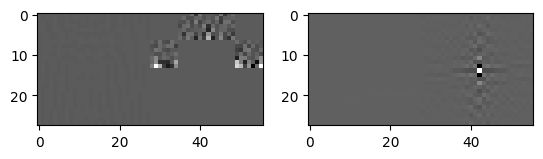

In [13]:
print(item[0].shape)
plt.subplot(1,2,1)
plt.imshow(item[0][0,0,:,:], cmap="gray")
plt.subplot(1,2,2)
plt.imshow(item_test[0][0,0,:,:], cmap="gray")

In [14]:
print(item[0][0][0][0].dtype)

torch.float32


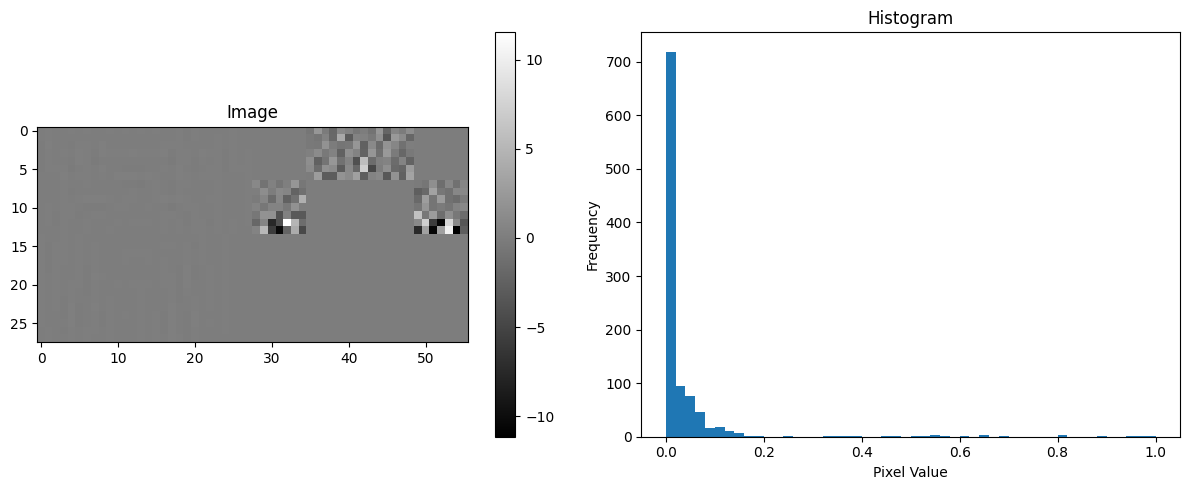

In [15]:

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the image
im = ax1.imshow(item[0][0,1,:,:], cmap="gray")
ax1.set_title("Image")
fig.colorbar(im, ax=ax1)

# Plot the histogram
ax2.hist(item[0][0,1,:,:].ravel(), bins=50, range=(0, 1))
ax2.set_title("Histogram")
ax2.set_xlabel("Pixel Value")
ax2.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [23]:
model = ViT(
    image_size = 56,
    patch_size = 7,
    num_classes = 10,
    dim = 128,
    depth = 6,
    heads = 12,
    mlp_dim = 256,
    dropout = 0.1,
    emb_dropout = 0.1,
    channels = 2
)
img = torch.randn(1, 2, 28, 56)

preds = model(img) # (1, 1000)

In [24]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 2794898


In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [26]:
writer = SummaryWriter('runs/experiment_1') 

def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}", unit="batch")
    for batch_idx, (data, target) in enumerate(progress_bar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        progress_bar.set_postfix({"Train Loss": train_loss / (batch_idx + 1), "Train Acc": 100. * correct / total})
        
        # Log batch-level metrics
        writer.add_scalar('Loss/Train Batch', loss.item(), epoch * len(train_loader) + batch_idx)
        writer.add_scalar('Accuracy/Train Batch', 100. * correct / total, epoch * len(train_loader) + batch_idx)
    
    train_loss /= len(train_loader)
    train_accuracy = 100. * correct / total
    
    # Log epoch-level metrics
    writer.add_scalar('Loss/Train Epoch', train_loss, epoch)
    writer.add_scalar('Accuracy/Train Epoch', train_accuracy, epoch)
    
    return train_loss, train_accuracy

def test(model, device, test_loader, criterion, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / total
    
    # Log epoch-level metrics
    writer.add_scalar('Loss/Test', test_loss, epoch)
    writer.add_scalar('Accuracy/Test', test_accuracy, epoch)
    
    return test_loss, test_accuracy


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

cuda


In [28]:

epochs = 3000
for epoch in range(0, epochs + 1):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, criterion, epoch)
    test_loss, test_accuracy = test(model, device, test_loader, criterion, epoch)
    print(f"Epoch {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print()


writer.close()

Epoch 0: 100%|██████████| 938/938 [00:22<00:00, 42.19batch/s, Train Loss=1.59, Train Acc=39.4]


Epoch 0
Train Loss: 1.5860, Train Accuracy: 39.39%
Test Loss: 1.1014, Test Accuracy: 59.68%



Epoch 1: 100%|██████████| 938/938 [00:22<00:00, 42.64batch/s, Train Loss=1.23, Train Acc=53.4]


Epoch 1
Train Loss: 1.2322, Train Accuracy: 53.37%
Test Loss: 0.9906, Test Accuracy: 62.71%



Epoch 2: 100%|██████████| 938/938 [00:21<00:00, 42.85batch/s, Train Loss=1.14, Train Acc=57.4]


Epoch 2
Train Loss: 1.1354, Train Accuracy: 57.40%
Test Loss: 0.9122, Test Accuracy: 67.36%



Epoch 3: 100%|██████████| 938/938 [00:22<00:00, 42.31batch/s, Train Loss=1.08, Train Acc=59.5]


Epoch 3
Train Loss: 1.0757, Train Accuracy: 59.51%
Test Loss: 0.8303, Test Accuracy: 70.12%



Epoch 4: 100%|██████████| 938/938 [00:22<00:00, 42.03batch/s, Train Loss=1.03, Train Acc=61.4]


Epoch 4
Train Loss: 1.0295, Train Accuracy: 61.37%
Test Loss: 0.8063, Test Accuracy: 71.50%



Epoch 5: 100%|██████████| 938/938 [00:22<00:00, 41.55batch/s, Train Loss=1, Train Acc=62.3]    


Epoch 5
Train Loss: 1.0034, Train Accuracy: 62.34%
Test Loss: 0.7705, Test Accuracy: 72.50%



Epoch 6: 100%|██████████| 938/938 [00:22<00:00, 42.57batch/s, Train Loss=0.972, Train Acc=63.7]


Epoch 6
Train Loss: 0.9717, Train Accuracy: 63.70%
Test Loss: 0.7139, Test Accuracy: 74.68%



Epoch 7: 100%|██████████| 938/938 [00:22<00:00, 41.41batch/s, Train Loss=0.951, Train Acc=64.4]


Epoch 7
Train Loss: 0.9509, Train Accuracy: 64.41%
Test Loss: 0.7030, Test Accuracy: 75.18%



Epoch 8: 100%|██████████| 938/938 [00:22<00:00, 41.14batch/s, Train Loss=0.93, Train Acc=65.4] 


Epoch 8
Train Loss: 0.9300, Train Accuracy: 65.36%
Test Loss: 0.6863, Test Accuracy: 75.57%



Epoch 9: 100%|██████████| 938/938 [00:22<00:00, 41.04batch/s, Train Loss=0.909, Train Acc=66.2]


Epoch 9
Train Loss: 0.9095, Train Accuracy: 66.15%
Test Loss: 0.7000, Test Accuracy: 75.33%



Epoch 10: 100%|██████████| 938/938 [00:22<00:00, 41.52batch/s, Train Loss=0.894, Train Acc=66.5]


Epoch 10
Train Loss: 0.8937, Train Accuracy: 66.47%
Test Loss: 0.6575, Test Accuracy: 76.63%



Epoch 11: 100%|██████████| 938/938 [00:22<00:00, 42.34batch/s, Train Loss=0.88, Train Acc=67.2] 


Epoch 11
Train Loss: 0.8801, Train Accuracy: 67.16%
Test Loss: 0.6175, Test Accuracy: 77.90%



Epoch 12: 100%|██████████| 938/938 [00:22<00:00, 42.32batch/s, Train Loss=0.865, Train Acc=67.9]


Epoch 12
Train Loss: 0.8654, Train Accuracy: 67.86%
Test Loss: 0.6251, Test Accuracy: 77.02%



Epoch 13: 100%|██████████| 938/938 [00:22<00:00, 42.60batch/s, Train Loss=0.849, Train Acc=68.4]


Epoch 13
Train Loss: 0.8488, Train Accuracy: 68.35%
Test Loss: 0.6157, Test Accuracy: 77.52%



Epoch 14: 100%|██████████| 938/938 [00:21<00:00, 42.78batch/s, Train Loss=0.841, Train Acc=68.6]


Epoch 14
Train Loss: 0.8411, Train Accuracy: 68.56%
Test Loss: 0.6121, Test Accuracy: 77.78%



Epoch 15: 100%|██████████| 938/938 [00:22<00:00, 42.44batch/s, Train Loss=0.83, Train Acc=69]   


Epoch 15
Train Loss: 0.8297, Train Accuracy: 69.00%
Test Loss: 0.5919, Test Accuracy: 78.49%



Epoch 16: 100%|██████████| 938/938 [00:22<00:00, 42.37batch/s, Train Loss=0.815, Train Acc=69.4]


Epoch 16
Train Loss: 0.8146, Train Accuracy: 69.40%
Test Loss: 0.5743, Test Accuracy: 78.90%



Epoch 17: 100%|██████████| 938/938 [00:22<00:00, 42.38batch/s, Train Loss=0.802, Train Acc=70.1]


Epoch 17
Train Loss: 0.8022, Train Accuracy: 70.06%
Test Loss: 0.5724, Test Accuracy: 79.47%



Epoch 18: 100%|██████████| 938/938 [00:21<00:00, 42.74batch/s, Train Loss=0.799, Train Acc=70.1]


Epoch 18
Train Loss: 0.7986, Train Accuracy: 70.15%
Test Loss: 0.5539, Test Accuracy: 79.96%



Epoch 19: 100%|██████████| 938/938 [00:22<00:00, 41.83batch/s, Train Loss=0.786, Train Acc=70.6]


Epoch 19
Train Loss: 0.7862, Train Accuracy: 70.64%
Test Loss: 0.5390, Test Accuracy: 80.15%



Epoch 20: 100%|██████████| 938/938 [00:22<00:00, 42.54batch/s, Train Loss=0.78, Train Acc=70.8] 


Epoch 20
Train Loss: 0.7796, Train Accuracy: 70.81%
Test Loss: 0.5535, Test Accuracy: 79.48%



Epoch 21: 100%|██████████| 938/938 [00:21<00:00, 42.98batch/s, Train Loss=0.767, Train Acc=71.4]


Epoch 21
Train Loss: 0.7670, Train Accuracy: 71.36%
Test Loss: 0.5277, Test Accuracy: 80.88%



Epoch 22: 100%|██████████| 938/938 [00:21<00:00, 43.20batch/s, Train Loss=0.758, Train Acc=71.6]


Epoch 22
Train Loss: 0.7582, Train Accuracy: 71.61%
Test Loss: 0.5156, Test Accuracy: 81.21%



Epoch 23: 100%|██████████| 938/938 [00:21<00:00, 43.13batch/s, Train Loss=0.747, Train Acc=72.1]


Epoch 23
Train Loss: 0.7465, Train Accuracy: 72.09%
Test Loss: 0.5053, Test Accuracy: 81.54%



Epoch 24: 100%|██████████| 938/938 [00:21<00:00, 43.23batch/s, Train Loss=0.746, Train Acc=72.2]


Epoch 24
Train Loss: 0.7462, Train Accuracy: 72.19%
Test Loss: 0.4915, Test Accuracy: 81.82%



Epoch 25: 100%|██████████| 938/938 [00:21<00:00, 42.98batch/s, Train Loss=0.737, Train Acc=72.4]


Epoch 25
Train Loss: 0.7373, Train Accuracy: 72.38%
Test Loss: 0.5053, Test Accuracy: 81.38%



Epoch 26: 100%|██████████| 938/938 [00:21<00:00, 42.88batch/s, Train Loss=0.731, Train Acc=72.9]


Epoch 26
Train Loss: 0.7307, Train Accuracy: 72.89%
Test Loss: 0.4809, Test Accuracy: 82.30%



Epoch 27: 100%|██████████| 938/938 [00:21<00:00, 42.90batch/s, Train Loss=0.722, Train Acc=73.2]


Epoch 27
Train Loss: 0.7217, Train Accuracy: 73.19%
Test Loss: 0.4757, Test Accuracy: 82.66%



Epoch 28: 100%|██████████| 938/938 [00:21<00:00, 43.38batch/s, Train Loss=0.713, Train Acc=73.5]


Epoch 28
Train Loss: 0.7128, Train Accuracy: 73.46%
Test Loss: 0.4804, Test Accuracy: 82.94%



Epoch 29: 100%|██████████| 938/938 [00:21<00:00, 43.38batch/s, Train Loss=0.704, Train Acc=73.9]


Epoch 29
Train Loss: 0.7042, Train Accuracy: 73.86%
Test Loss: 0.4680, Test Accuracy: 82.86%



Epoch 30: 100%|██████████| 938/938 [00:21<00:00, 43.21batch/s, Train Loss=0.699, Train Acc=73.8]


Epoch 30
Train Loss: 0.6993, Train Accuracy: 73.78%
Test Loss: 0.4622, Test Accuracy: 83.20%



Epoch 31: 100%|██████████| 938/938 [00:21<00:00, 43.26batch/s, Train Loss=0.696, Train Acc=73.9]


Epoch 31
Train Loss: 0.6961, Train Accuracy: 73.94%
Test Loss: 0.4549, Test Accuracy: 83.37%



Epoch 32: 100%|██████████| 938/938 [00:21<00:00, 43.09batch/s, Train Loss=0.685, Train Acc=74.5]


Epoch 32
Train Loss: 0.6848, Train Accuracy: 74.50%
Test Loss: 0.4497, Test Accuracy: 83.47%



Epoch 33: 100%|██████████| 938/938 [00:22<00:00, 42.63batch/s, Train Loss=0.679, Train Acc=74.7]


Epoch 33
Train Loss: 0.6794, Train Accuracy: 74.69%
Test Loss: 0.4608, Test Accuracy: 83.37%



Epoch 34: 100%|██████████| 938/938 [00:21<00:00, 42.93batch/s, Train Loss=0.676, Train Acc=74.6]


Epoch 34
Train Loss: 0.6763, Train Accuracy: 74.56%
Test Loss: 0.4398, Test Accuracy: 84.04%



Epoch 35: 100%|██████████| 938/938 [00:21<00:00, 43.29batch/s, Train Loss=0.671, Train Acc=74.8]


Epoch 35
Train Loss: 0.6713, Train Accuracy: 74.78%
Test Loss: 0.4508, Test Accuracy: 83.90%



Epoch 36: 100%|██████████| 938/938 [00:21<00:00, 43.16batch/s, Train Loss=0.663, Train Acc=75.5]


Epoch 36
Train Loss: 0.6628, Train Accuracy: 75.45%
Test Loss: 0.4431, Test Accuracy: 83.92%



Epoch 37: 100%|██████████| 938/938 [00:21<00:00, 43.18batch/s, Train Loss=0.662, Train Acc=75.2]


Epoch 37
Train Loss: 0.6619, Train Accuracy: 75.20%
Test Loss: 0.4545, Test Accuracy: 83.12%



Epoch 38: 100%|██████████| 938/938 [00:21<00:00, 43.29batch/s, Train Loss=0.651, Train Acc=75.6]


Epoch 38
Train Loss: 0.6512, Train Accuracy: 75.56%
Test Loss: 0.4297, Test Accuracy: 84.16%



Epoch 39: 100%|██████████| 938/938 [00:21<00:00, 43.11batch/s, Train Loss=0.654, Train Acc=75.6]


Epoch 39
Train Loss: 0.6543, Train Accuracy: 75.57%
Test Loss: 0.4303, Test Accuracy: 84.24%



Epoch 40: 100%|██████████| 938/938 [00:21<00:00, 43.36batch/s, Train Loss=0.646, Train Acc=76]  


Epoch 40
Train Loss: 0.6462, Train Accuracy: 75.96%
Test Loss: 0.4222, Test Accuracy: 84.72%



Epoch 41: 100%|██████████| 938/938 [00:21<00:00, 43.08batch/s, Train Loss=0.637, Train Acc=76.2]


Epoch 41
Train Loss: 0.6375, Train Accuracy: 76.16%
Test Loss: 0.4118, Test Accuracy: 84.69%



Epoch 42: 100%|██████████| 938/938 [00:21<00:00, 43.35batch/s, Train Loss=0.635, Train Acc=76.3]


Epoch 42
Train Loss: 0.6355, Train Accuracy: 76.34%
Test Loss: 0.4262, Test Accuracy: 84.39%



Epoch 43: 100%|██████████| 938/938 [00:21<00:00, 43.15batch/s, Train Loss=0.629, Train Acc=76.6]


Epoch 43
Train Loss: 0.6293, Train Accuracy: 76.57%
Test Loss: 0.4145, Test Accuracy: 84.84%



Epoch 44: 100%|██████████| 938/938 [00:21<00:00, 43.18batch/s, Train Loss=0.635, Train Acc=76.3]


Epoch 44
Train Loss: 0.6347, Train Accuracy: 76.34%
Test Loss: 0.4036, Test Accuracy: 85.10%



Epoch 45: 100%|██████████| 938/938 [00:21<00:00, 43.14batch/s, Train Loss=0.626, Train Acc=76.6]


Epoch 45
Train Loss: 0.6257, Train Accuracy: 76.60%
Test Loss: 0.3979, Test Accuracy: 85.36%



Epoch 46: 100%|██████████| 938/938 [00:21<00:00, 43.26batch/s, Train Loss=0.618, Train Acc=77]  


Epoch 46
Train Loss: 0.6180, Train Accuracy: 76.98%
Test Loss: 0.4160, Test Accuracy: 84.76%



Epoch 47: 100%|██████████| 938/938 [00:21<00:00, 43.31batch/s, Train Loss=0.617, Train Acc=76.9]


Epoch 47
Train Loss: 0.6166, Train Accuracy: 76.90%
Test Loss: 0.3991, Test Accuracy: 85.18%



Epoch 48: 100%|██████████| 938/938 [00:21<00:00, 43.08batch/s, Train Loss=0.611, Train Acc=77]  


Epoch 48
Train Loss: 0.6106, Train Accuracy: 77.00%
Test Loss: 0.4021, Test Accuracy: 85.18%



Epoch 49: 100%|██████████| 938/938 [00:21<00:00, 43.25batch/s, Train Loss=0.611, Train Acc=77.1]


Epoch 49
Train Loss: 0.6111, Train Accuracy: 77.08%
Test Loss: 0.3961, Test Accuracy: 85.46%



Epoch 50: 100%|██████████| 938/938 [00:21<00:00, 42.92batch/s, Train Loss=0.605, Train Acc=77.4]


Epoch 50
Train Loss: 0.6049, Train Accuracy: 77.36%
Test Loss: 0.3958, Test Accuracy: 85.27%



Epoch 51: 100%|██████████| 938/938 [00:21<00:00, 43.19batch/s, Train Loss=0.602, Train Acc=77.5]


Epoch 51
Train Loss: 0.6024, Train Accuracy: 77.50%
Test Loss: 0.3964, Test Accuracy: 85.22%



Epoch 52: 100%|██████████| 938/938 [00:21<00:00, 43.11batch/s, Train Loss=0.6, Train Acc=77.4]  


Epoch 52
Train Loss: 0.5997, Train Accuracy: 77.41%
Test Loss: 0.3853, Test Accuracy: 85.90%



Epoch 53: 100%|██████████| 938/938 [00:21<00:00, 43.14batch/s, Train Loss=0.602, Train Acc=77.5]


Epoch 53
Train Loss: 0.6019, Train Accuracy: 77.51%
Test Loss: 0.3826, Test Accuracy: 86.14%



Epoch 54: 100%|██████████| 938/938 [00:21<00:00, 43.30batch/s, Train Loss=0.593, Train Acc=77.9]


Epoch 54
Train Loss: 0.5926, Train Accuracy: 77.91%
Test Loss: 0.3908, Test Accuracy: 85.56%



Epoch 55: 100%|██████████| 938/938 [00:21<00:00, 43.14batch/s, Train Loss=0.59, Train Acc=77.9] 


Epoch 55
Train Loss: 0.5901, Train Accuracy: 77.91%
Test Loss: 0.3913, Test Accuracy: 85.32%



Epoch 56: 100%|██████████| 938/938 [00:21<00:00, 43.08batch/s, Train Loss=0.585, Train Acc=78.1]


Epoch 56
Train Loss: 0.5849, Train Accuracy: 78.08%
Test Loss: 0.3912, Test Accuracy: 85.50%



Epoch 57: 100%|██████████| 938/938 [00:21<00:00, 42.93batch/s, Train Loss=0.588, Train Acc=78]  


Epoch 57
Train Loss: 0.5881, Train Accuracy: 77.97%
Test Loss: 0.3874, Test Accuracy: 85.48%



Epoch 58: 100%|██████████| 938/938 [00:21<00:00, 43.26batch/s, Train Loss=0.586, Train Acc=78.3]


Epoch 58
Train Loss: 0.5861, Train Accuracy: 78.26%
Test Loss: 0.3910, Test Accuracy: 85.48%



Epoch 59: 100%|██████████| 938/938 [00:21<00:00, 43.10batch/s, Train Loss=0.579, Train Acc=78.2]


Epoch 59
Train Loss: 0.5793, Train Accuracy: 78.22%
Test Loss: 0.3816, Test Accuracy: 85.95%



Epoch 60: 100%|██████████| 938/938 [00:21<00:00, 43.03batch/s, Train Loss=0.576, Train Acc=78.4]


Epoch 60
Train Loss: 0.5757, Train Accuracy: 78.36%
Test Loss: 0.3817, Test Accuracy: 85.74%



Epoch 61: 100%|██████████| 938/938 [00:21<00:00, 42.96batch/s, Train Loss=0.576, Train Acc=78.5]


Epoch 61
Train Loss: 0.5764, Train Accuracy: 78.48%
Test Loss: 0.3684, Test Accuracy: 86.50%



Epoch 62: 100%|██████████| 938/938 [00:21<00:00, 42.86batch/s, Train Loss=0.572, Train Acc=78.6]


Epoch 62
Train Loss: 0.5717, Train Accuracy: 78.57%
Test Loss: 0.3754, Test Accuracy: 86.05%



Epoch 63: 100%|██████████| 938/938 [00:21<00:00, 43.01batch/s, Train Loss=0.571, Train Acc=78.7]


Epoch 63
Train Loss: 0.5710, Train Accuracy: 78.69%
Test Loss: 0.3818, Test Accuracy: 86.07%



Epoch 64: 100%|██████████| 938/938 [00:21<00:00, 43.13batch/s, Train Loss=0.566, Train Acc=78.9]


Epoch 64
Train Loss: 0.5657, Train Accuracy: 78.92%
Test Loss: 0.3742, Test Accuracy: 86.27%



Epoch 65: 100%|██████████| 938/938 [00:21<00:00, 42.88batch/s, Train Loss=0.569, Train Acc=78.7]


Epoch 65
Train Loss: 0.5692, Train Accuracy: 78.69%
Test Loss: 0.3802, Test Accuracy: 85.88%



Epoch 66: 100%|██████████| 938/938 [00:21<00:00, 43.13batch/s, Train Loss=0.565, Train Acc=79]  


Epoch 66
Train Loss: 0.5651, Train Accuracy: 78.98%
Test Loss: 0.3833, Test Accuracy: 85.81%



Epoch 67: 100%|██████████| 938/938 [00:21<00:00, 42.92batch/s, Train Loss=0.561, Train Acc=79]  


Epoch 67
Train Loss: 0.5607, Train Accuracy: 78.97%
Test Loss: 0.3669, Test Accuracy: 86.46%



Epoch 68: 100%|██████████| 938/938 [00:21<00:00, 42.89batch/s, Train Loss=0.553, Train Acc=79.3]


Epoch 68
Train Loss: 0.5529, Train Accuracy: 79.33%
Test Loss: 0.3681, Test Accuracy: 86.53%



Epoch 69: 100%|██████████| 938/938 [00:21<00:00, 43.20batch/s, Train Loss=0.554, Train Acc=79.1]


Epoch 69
Train Loss: 0.5543, Train Accuracy: 79.08%
Test Loss: 0.3705, Test Accuracy: 86.07%



Epoch 70: 100%|██████████| 938/938 [00:21<00:00, 43.04batch/s, Train Loss=0.552, Train Acc=79.3]


Epoch 70
Train Loss: 0.5523, Train Accuracy: 79.27%
Test Loss: 0.3574, Test Accuracy: 86.88%



Epoch 71: 100%|██████████| 938/938 [00:21<00:00, 43.08batch/s, Train Loss=0.554, Train Acc=79.2]


Epoch 71
Train Loss: 0.5542, Train Accuracy: 79.22%
Test Loss: 0.3643, Test Accuracy: 86.68%



Epoch 72: 100%|██████████| 938/938 [00:21<00:00, 43.15batch/s, Train Loss=0.549, Train Acc=79.4]


Epoch 72
Train Loss: 0.5489, Train Accuracy: 79.45%
Test Loss: 0.3575, Test Accuracy: 86.84%



Epoch 73: 100%|██████████| 938/938 [00:21<00:00, 43.04batch/s, Train Loss=0.547, Train Acc=79.7]


Epoch 73
Train Loss: 0.5474, Train Accuracy: 79.74%
Test Loss: 0.3614, Test Accuracy: 86.75%



Epoch 74: 100%|██████████| 938/938 [00:21<00:00, 43.11batch/s, Train Loss=0.546, Train Acc=79.4]


Epoch 74
Train Loss: 0.5458, Train Accuracy: 79.40%
Test Loss: 0.3674, Test Accuracy: 86.49%



Epoch 75: 100%|██████████| 938/938 [00:21<00:00, 42.97batch/s, Train Loss=0.541, Train Acc=79.6]


Epoch 75
Train Loss: 0.5414, Train Accuracy: 79.62%
Test Loss: 0.3622, Test Accuracy: 86.70%



Epoch 76: 100%|██████████| 938/938 [00:21<00:00, 42.74batch/s, Train Loss=0.543, Train Acc=79.5]


Epoch 76
Train Loss: 0.5430, Train Accuracy: 79.52%
Test Loss: 0.3527, Test Accuracy: 87.10%



Epoch 77: 100%|██████████| 938/938 [00:21<00:00, 43.12batch/s, Train Loss=0.541, Train Acc=79.8]


Epoch 77
Train Loss: 0.5408, Train Accuracy: 79.78%
Test Loss: 0.3540, Test Accuracy: 87.16%



Epoch 78: 100%|██████████| 938/938 [00:21<00:00, 43.00batch/s, Train Loss=0.541, Train Acc=79.8]


Epoch 78
Train Loss: 0.5405, Train Accuracy: 79.81%
Test Loss: 0.3648, Test Accuracy: 86.44%



Epoch 79: 100%|██████████| 938/938 [00:21<00:00, 43.07batch/s, Train Loss=0.531, Train Acc=80]  


Epoch 79
Train Loss: 0.5315, Train Accuracy: 80.04%
Test Loss: 0.3581, Test Accuracy: 87.00%



Epoch 80: 100%|██████████| 938/938 [00:21<00:00, 42.91batch/s, Train Loss=0.532, Train Acc=80.1]


Epoch 80
Train Loss: 0.5316, Train Accuracy: 80.09%
Test Loss: 0.3483, Test Accuracy: 87.42%



Epoch 81: 100%|██████████| 938/938 [00:21<00:00, 43.01batch/s, Train Loss=0.534, Train Acc=79.9]


Epoch 81
Train Loss: 0.5340, Train Accuracy: 79.93%
Test Loss: 0.3629, Test Accuracy: 86.69%



Epoch 82: 100%|██████████| 938/938 [00:21<00:00, 42.78batch/s, Train Loss=0.53, Train Acc=80.3] 


Epoch 82
Train Loss: 0.5301, Train Accuracy: 80.28%
Test Loss: 0.3486, Test Accuracy: 87.20%



Epoch 83: 100%|██████████| 938/938 [00:21<00:00, 42.80batch/s, Train Loss=0.531, Train Acc=80]  


Epoch 83
Train Loss: 0.5311, Train Accuracy: 80.05%
Test Loss: 0.3525, Test Accuracy: 87.14%



Epoch 84: 100%|██████████| 938/938 [00:21<00:00, 43.05batch/s, Train Loss=0.527, Train Acc=80.3]


Epoch 84
Train Loss: 0.5269, Train Accuracy: 80.25%
Test Loss: 0.3461, Test Accuracy: 87.55%



Epoch 85: 100%|██████████| 938/938 [00:21<00:00, 42.92batch/s, Train Loss=0.526, Train Acc=80.2]


Epoch 85
Train Loss: 0.5264, Train Accuracy: 80.25%
Test Loss: 0.3420, Test Accuracy: 87.50%



Epoch 86: 100%|██████████| 938/938 [00:21<00:00, 42.89batch/s, Train Loss=0.526, Train Acc=80.2]


Epoch 86
Train Loss: 0.5263, Train Accuracy: 80.22%
Test Loss: 0.3422, Test Accuracy: 87.27%



Epoch 87: 100%|██████████| 938/938 [00:21<00:00, 42.81batch/s, Train Loss=0.529, Train Acc=80.2]


Epoch 87
Train Loss: 0.5291, Train Accuracy: 80.23%
Test Loss: 0.3419, Test Accuracy: 87.50%



Epoch 88: 100%|██████████| 938/938 [00:21<00:00, 42.85batch/s, Train Loss=0.521, Train Acc=80.4]


Epoch 88
Train Loss: 0.5208, Train Accuracy: 80.36%
Test Loss: 0.3409, Test Accuracy: 87.65%



Epoch 89: 100%|██████████| 938/938 [00:21<00:00, 42.97batch/s, Train Loss=0.517, Train Acc=80.6]


Epoch 89
Train Loss: 0.5174, Train Accuracy: 80.62%
Test Loss: 0.3411, Test Accuracy: 87.59%



Epoch 90: 100%|██████████| 938/938 [00:21<00:00, 43.03batch/s, Train Loss=0.52, Train Acc=80.6] 


Epoch 90
Train Loss: 0.5201, Train Accuracy: 80.64%
Test Loss: 0.3445, Test Accuracy: 87.50%



Epoch 91: 100%|██████████| 938/938 [00:21<00:00, 43.14batch/s, Train Loss=0.518, Train Acc=80.6]


Epoch 91
Train Loss: 0.5178, Train Accuracy: 80.61%
Test Loss: 0.3458, Test Accuracy: 87.35%



Epoch 92: 100%|██████████| 938/938 [00:21<00:00, 43.09batch/s, Train Loss=0.517, Train Acc=80.7]


Epoch 92
Train Loss: 0.5169, Train Accuracy: 80.74%
Test Loss: 0.3340, Test Accuracy: 87.87%



Epoch 93: 100%|██████████| 938/938 [00:21<00:00, 43.20batch/s, Train Loss=0.513, Train Acc=80.7]


Epoch 93
Train Loss: 0.5133, Train Accuracy: 80.68%
Test Loss: 0.3366, Test Accuracy: 87.63%



Epoch 94: 100%|██████████| 938/938 [00:21<00:00, 43.12batch/s, Train Loss=0.514, Train Acc=80.7]


Epoch 94
Train Loss: 0.5140, Train Accuracy: 80.72%
Test Loss: 0.3378, Test Accuracy: 87.96%



Epoch 95: 100%|██████████| 938/938 [00:21<00:00, 43.17batch/s, Train Loss=0.509, Train Acc=80.9]


Epoch 95
Train Loss: 0.5086, Train Accuracy: 80.90%
Test Loss: 0.3323, Test Accuracy: 88.15%



Epoch 96: 100%|██████████| 938/938 [00:21<00:00, 42.82batch/s, Train Loss=0.509, Train Acc=81.1]


Epoch 96
Train Loss: 0.5092, Train Accuracy: 81.09%
Test Loss: 0.3446, Test Accuracy: 87.74%



Epoch 97: 100%|██████████| 938/938 [00:21<00:00, 43.07batch/s, Train Loss=0.505, Train Acc=81]  


Epoch 97
Train Loss: 0.5050, Train Accuracy: 81.00%
Test Loss: 0.3377, Test Accuracy: 87.87%



Epoch 98: 100%|██████████| 938/938 [00:21<00:00, 42.99batch/s, Train Loss=0.505, Train Acc=81.1]


Epoch 98
Train Loss: 0.5052, Train Accuracy: 81.10%
Test Loss: 0.3290, Test Accuracy: 88.26%



Epoch 99: 100%|██████████| 938/938 [00:21<00:00, 43.15batch/s, Train Loss=0.505, Train Acc=80.9]


Epoch 99
Train Loss: 0.5046, Train Accuracy: 80.92%
Test Loss: 0.3301, Test Accuracy: 88.13%



Epoch 100: 100%|██████████| 938/938 [00:21<00:00, 43.24batch/s, Train Loss=0.499, Train Acc=81.2]


Epoch 100
Train Loss: 0.4990, Train Accuracy: 81.23%
Test Loss: 0.3245, Test Accuracy: 88.22%



Epoch 101: 100%|██████████| 938/938 [00:21<00:00, 43.02batch/s, Train Loss=0.501, Train Acc=81.2]


Epoch 101
Train Loss: 0.5014, Train Accuracy: 81.24%
Test Loss: 0.3268, Test Accuracy: 88.17%



Epoch 102: 100%|██████████| 938/938 [00:21<00:00, 42.97batch/s, Train Loss=0.5, Train Acc=81.3]  


Epoch 102
Train Loss: 0.4999, Train Accuracy: 81.30%
Test Loss: 0.3309, Test Accuracy: 87.97%



Epoch 103: 100%|██████████| 938/938 [00:21<00:00, 43.05batch/s, Train Loss=0.501, Train Acc=81.2]


Epoch 103
Train Loss: 0.5007, Train Accuracy: 81.24%
Test Loss: 0.3259, Test Accuracy: 88.23%



Epoch 104: 100%|██████████| 938/938 [00:21<00:00, 42.87batch/s, Train Loss=0.497, Train Acc=81.2]


Epoch 104
Train Loss: 0.4966, Train Accuracy: 81.25%
Test Loss: 0.3272, Test Accuracy: 88.15%



Epoch 105: 100%|██████████| 938/938 [00:21<00:00, 43.11batch/s, Train Loss=0.495, Train Acc=81.2]


Epoch 105
Train Loss: 0.4954, Train Accuracy: 81.22%
Test Loss: 0.3249, Test Accuracy: 88.51%



Epoch 106: 100%|██████████| 938/938 [00:22<00:00, 42.64batch/s, Train Loss=0.497, Train Acc=81.4]


Epoch 106
Train Loss: 0.4974, Train Accuracy: 81.36%
Test Loss: 0.3289, Test Accuracy: 88.06%



Epoch 107: 100%|██████████| 938/938 [00:21<00:00, 42.97batch/s, Train Loss=0.489, Train Acc=81.5]


Epoch 107
Train Loss: 0.4894, Train Accuracy: 81.53%
Test Loss: 0.3272, Test Accuracy: 88.34%



Epoch 108: 100%|██████████| 938/938 [00:21<00:00, 43.05batch/s, Train Loss=0.492, Train Acc=81.6]


Epoch 108
Train Loss: 0.4924, Train Accuracy: 81.55%
Test Loss: 0.3282, Test Accuracy: 88.20%



Epoch 109: 100%|██████████| 938/938 [00:21<00:00, 43.00batch/s, Train Loss=0.492, Train Acc=81.5]


Epoch 109
Train Loss: 0.4917, Train Accuracy: 81.46%
Test Loss: 0.3314, Test Accuracy: 87.85%



Epoch 110: 100%|██████████| 938/938 [00:21<00:00, 43.11batch/s, Train Loss=0.492, Train Acc=81.6]


Epoch 110
Train Loss: 0.4918, Train Accuracy: 81.59%
Test Loss: 0.3312, Test Accuracy: 87.99%



Epoch 111: 100%|██████████| 938/938 [00:21<00:00, 43.11batch/s, Train Loss=0.488, Train Acc=81.8]


Epoch 111
Train Loss: 0.4882, Train Accuracy: 81.83%
Test Loss: 0.3270, Test Accuracy: 88.18%



Epoch 112: 100%|██████████| 938/938 [00:21<00:00, 43.04batch/s, Train Loss=0.485, Train Acc=81.8]


Epoch 112
Train Loss: 0.4851, Train Accuracy: 81.79%
Test Loss: 0.3237, Test Accuracy: 88.41%



Epoch 113: 100%|██████████| 938/938 [00:21<00:00, 42.67batch/s, Train Loss=0.486, Train Acc=81.7]


Epoch 113
Train Loss: 0.4865, Train Accuracy: 81.69%
Test Loss: 0.3252, Test Accuracy: 88.16%



Epoch 114: 100%|██████████| 938/938 [00:21<00:00, 42.85batch/s, Train Loss=0.486, Train Acc=81.9]


Epoch 114
Train Loss: 0.4856, Train Accuracy: 81.91%
Test Loss: 0.3269, Test Accuracy: 88.31%



Epoch 115: 100%|██████████| 938/938 [00:21<00:00, 42.77batch/s, Train Loss=0.486, Train Acc=81.8]


Epoch 115
Train Loss: 0.4860, Train Accuracy: 81.83%
Test Loss: 0.3156, Test Accuracy: 88.50%



Epoch 116: 100%|██████████| 938/938 [00:21<00:00, 42.96batch/s, Train Loss=0.483, Train Acc=82]  


Epoch 116
Train Loss: 0.4828, Train Accuracy: 81.95%
Test Loss: 0.3170, Test Accuracy: 88.67%



Epoch 117: 100%|██████████| 938/938 [00:21<00:00, 43.00batch/s, Train Loss=0.483, Train Acc=81.8]


Epoch 117
Train Loss: 0.4835, Train Accuracy: 81.80%
Test Loss: 0.3178, Test Accuracy: 88.39%



Epoch 118: 100%|██████████| 938/938 [00:21<00:00, 42.95batch/s, Train Loss=0.483, Train Acc=81.8]


Epoch 118
Train Loss: 0.4827, Train Accuracy: 81.83%
Test Loss: 0.3192, Test Accuracy: 88.69%



Epoch 119: 100%|██████████| 938/938 [00:21<00:00, 42.90batch/s, Train Loss=0.482, Train Acc=81.9]


Epoch 119
Train Loss: 0.4818, Train Accuracy: 81.90%
Test Loss: 0.3244, Test Accuracy: 88.26%



Epoch 120: 100%|██████████| 938/938 [00:21<00:00, 42.93batch/s, Train Loss=0.479, Train Acc=81.9]


Epoch 120
Train Loss: 0.4788, Train Accuracy: 81.90%
Test Loss: 0.3153, Test Accuracy: 88.67%



Epoch 121: 100%|██████████| 938/938 [00:21<00:00, 42.90batch/s, Train Loss=0.476, Train Acc=82.1]


Epoch 121
Train Loss: 0.4765, Train Accuracy: 82.11%
Test Loss: 0.3126, Test Accuracy: 88.96%



Epoch 122: 100%|██████████| 938/938 [00:21<00:00, 43.08batch/s, Train Loss=0.481, Train Acc=82]  


Epoch 122
Train Loss: 0.4806, Train Accuracy: 81.95%
Test Loss: 0.3153, Test Accuracy: 88.64%



Epoch 123: 100%|██████████| 938/938 [00:21<00:00, 42.97batch/s, Train Loss=0.476, Train Acc=81.9]


Epoch 123
Train Loss: 0.4760, Train Accuracy: 81.88%
Test Loss: 0.3118, Test Accuracy: 88.99%



Epoch 124: 100%|██████████| 938/938 [00:21<00:00, 42.84batch/s, Train Loss=0.474, Train Acc=82.2]


Epoch 124
Train Loss: 0.4736, Train Accuracy: 82.16%
Test Loss: 0.3161, Test Accuracy: 88.77%



Epoch 125: 100%|██████████| 938/938 [00:21<00:00, 42.90batch/s, Train Loss=0.475, Train Acc=82.1]


Epoch 125
Train Loss: 0.4746, Train Accuracy: 82.11%
Test Loss: 0.3135, Test Accuracy: 88.81%



Epoch 126: 100%|██████████| 938/938 [00:21<00:00, 42.77batch/s, Train Loss=0.475, Train Acc=82.3]


Epoch 126
Train Loss: 0.4747, Train Accuracy: 82.30%
Test Loss: 0.3160, Test Accuracy: 88.53%



Epoch 127: 100%|██████████| 938/938 [00:21<00:00, 42.80batch/s, Train Loss=0.47, Train Acc=82.5] 


Epoch 127
Train Loss: 0.4695, Train Accuracy: 82.52%
Test Loss: 0.3076, Test Accuracy: 89.11%



Epoch 128: 100%|██████████| 938/938 [00:21<00:00, 42.91batch/s, Train Loss=0.468, Train Acc=82.4]


Epoch 128
Train Loss: 0.4681, Train Accuracy: 82.41%
Test Loss: 0.3174, Test Accuracy: 88.67%



Epoch 129: 100%|██████████| 938/938 [00:21<00:00, 42.88batch/s, Train Loss=0.47, Train Acc=82.4] 


Epoch 129
Train Loss: 0.4703, Train Accuracy: 82.41%
Test Loss: 0.3173, Test Accuracy: 88.64%



Epoch 130: 100%|██████████| 938/938 [00:21<00:00, 42.98batch/s, Train Loss=0.468, Train Acc=82.3]


Epoch 130
Train Loss: 0.4676, Train Accuracy: 82.31%
Test Loss: 0.3098, Test Accuracy: 88.93%



Epoch 131: 100%|██████████| 938/938 [00:21<00:00, 42.96batch/s, Train Loss=0.466, Train Acc=82.5]


Epoch 131
Train Loss: 0.4664, Train Accuracy: 82.48%
Test Loss: 0.3119, Test Accuracy: 88.81%



Epoch 132: 100%|██████████| 938/938 [00:21<00:00, 42.71batch/s, Train Loss=0.461, Train Acc=82.5]


Epoch 132
Train Loss: 0.4612, Train Accuracy: 82.53%
Test Loss: 0.3165, Test Accuracy: 88.65%



Epoch 133: 100%|██████████| 938/938 [00:21<00:00, 42.85batch/s, Train Loss=0.466, Train Acc=82.5]


Epoch 133
Train Loss: 0.4665, Train Accuracy: 82.52%
Test Loss: 0.3097, Test Accuracy: 89.00%



Epoch 134: 100%|██████████| 938/938 [00:21<00:00, 42.85batch/s, Train Loss=0.465, Train Acc=82.6]


Epoch 134
Train Loss: 0.4647, Train Accuracy: 82.59%
Test Loss: 0.3107, Test Accuracy: 88.94%



Epoch 135: 100%|██████████| 938/938 [00:21<00:00, 43.13batch/s, Train Loss=0.46, Train Acc=82.4] 


Epoch 135
Train Loss: 0.4600, Train Accuracy: 82.45%
Test Loss: 0.3071, Test Accuracy: 89.09%



Epoch 136: 100%|██████████| 938/938 [00:21<00:00, 42.88batch/s, Train Loss=0.46, Train Acc=82.7] 


Epoch 136
Train Loss: 0.4605, Train Accuracy: 82.75%
Test Loss: 0.3070, Test Accuracy: 89.01%



Epoch 137: 100%|██████████| 938/938 [00:21<00:00, 42.96batch/s, Train Loss=0.461, Train Acc=82.5]


Epoch 137
Train Loss: 0.4611, Train Accuracy: 82.51%
Test Loss: 0.3116, Test Accuracy: 88.90%



Epoch 138: 100%|██████████| 938/938 [00:21<00:00, 42.94batch/s, Train Loss=0.464, Train Acc=82.6]


Epoch 138
Train Loss: 0.4640, Train Accuracy: 82.61%
Test Loss: 0.3044, Test Accuracy: 89.02%



Epoch 139: 100%|██████████| 938/938 [00:21<00:00, 43.02batch/s, Train Loss=0.459, Train Acc=82.6]


Epoch 139
Train Loss: 0.4591, Train Accuracy: 82.63%
Test Loss: 0.3071, Test Accuracy: 88.74%



Epoch 140: 100%|██████████| 938/938 [00:21<00:00, 42.75batch/s, Train Loss=0.458, Train Acc=82.7]


Epoch 140
Train Loss: 0.4580, Train Accuracy: 82.68%
Test Loss: 0.3032, Test Accuracy: 88.88%



Epoch 141: 100%|██████████| 938/938 [00:21<00:00, 43.01batch/s, Train Loss=0.456, Train Acc=82.8]


Epoch 141
Train Loss: 0.4565, Train Accuracy: 82.79%
Test Loss: 0.3036, Test Accuracy: 88.98%



Epoch 142: 100%|██████████| 938/938 [00:21<00:00, 42.75batch/s, Train Loss=0.458, Train Acc=82.9]


Epoch 142
Train Loss: 0.4581, Train Accuracy: 82.88%
Test Loss: 0.3061, Test Accuracy: 88.78%



Epoch 143: 100%|██████████| 938/938 [00:21<00:00, 42.75batch/s, Train Loss=0.455, Train Acc=82.9]


Epoch 143
Train Loss: 0.4547, Train Accuracy: 82.92%
Test Loss: 0.3040, Test Accuracy: 88.84%



Epoch 144: 100%|██████████| 938/938 [00:21<00:00, 42.88batch/s, Train Loss=0.452, Train Acc=82.9]


Epoch 144
Train Loss: 0.4519, Train Accuracy: 82.94%
Test Loss: 0.3005, Test Accuracy: 88.99%



Epoch 145: 100%|██████████| 938/938 [00:21<00:00, 42.70batch/s, Train Loss=0.459, Train Acc=82.8]


Epoch 145
Train Loss: 0.4585, Train Accuracy: 82.79%
Test Loss: 0.3072, Test Accuracy: 88.82%



Epoch 146: 100%|██████████| 938/938 [00:21<00:00, 42.99batch/s, Train Loss=0.448, Train Acc=83.1]


Epoch 146
Train Loss: 0.4479, Train Accuracy: 83.09%
Test Loss: 0.3107, Test Accuracy: 88.82%



Epoch 147: 100%|██████████| 938/938 [00:21<00:00, 42.85batch/s, Train Loss=0.452, Train Acc=83]  


Epoch 147
Train Loss: 0.4519, Train Accuracy: 82.98%
Test Loss: 0.3016, Test Accuracy: 89.01%



Epoch 148: 100%|██████████| 938/938 [00:21<00:00, 42.89batch/s, Train Loss=0.449, Train Acc=83.2]


Epoch 148
Train Loss: 0.4486, Train Accuracy: 83.22%
Test Loss: 0.3004, Test Accuracy: 89.15%



Epoch 149: 100%|██████████| 938/938 [00:21<00:00, 43.30batch/s, Train Loss=0.452, Train Acc=82.9]


Epoch 149
Train Loss: 0.4523, Train Accuracy: 82.91%
Test Loss: 0.3010, Test Accuracy: 89.13%



Epoch 150: 100%|██████████| 938/938 [00:21<00:00, 43.06batch/s, Train Loss=0.449, Train Acc=83]  


Epoch 150
Train Loss: 0.4487, Train Accuracy: 83.01%
Test Loss: 0.3049, Test Accuracy: 88.91%



Epoch 151: 100%|██████████| 938/938 [00:21<00:00, 42.87batch/s, Train Loss=0.447, Train Acc=83.2]


Epoch 151
Train Loss: 0.4471, Train Accuracy: 83.25%
Test Loss: 0.3095, Test Accuracy: 88.92%



Epoch 152: 100%|██████████| 938/938 [00:21<00:00, 42.79batch/s, Train Loss=0.448, Train Acc=83]  


Epoch 152
Train Loss: 0.4482, Train Accuracy: 83.04%
Test Loss: 0.3043, Test Accuracy: 88.98%



Epoch 153: 100%|██████████| 938/938 [00:21<00:00, 43.20batch/s, Train Loss=0.446, Train Acc=83]  


Epoch 153
Train Loss: 0.4461, Train Accuracy: 83.05%
Test Loss: 0.3038, Test Accuracy: 88.93%



Epoch 154: 100%|██████████| 938/938 [00:21<00:00, 42.94batch/s, Train Loss=0.447, Train Acc=83.2]


Epoch 154
Train Loss: 0.4472, Train Accuracy: 83.21%
Test Loss: 0.3069, Test Accuracy: 88.96%



Epoch 155: 100%|██████████| 938/938 [00:21<00:00, 42.75batch/s, Train Loss=0.447, Train Acc=83.2]


Epoch 155
Train Loss: 0.4473, Train Accuracy: 83.16%
Test Loss: 0.3039, Test Accuracy: 88.79%



Epoch 156: 100%|██████████| 938/938 [00:21<00:00, 43.03batch/s, Train Loss=0.445, Train Acc=83.3]


Epoch 156
Train Loss: 0.4447, Train Accuracy: 83.33%
Test Loss: 0.3019, Test Accuracy: 88.82%



Epoch 157: 100%|██████████| 938/938 [00:21<00:00, 42.99batch/s, Train Loss=0.442, Train Acc=83.4]


Epoch 157
Train Loss: 0.4415, Train Accuracy: 83.40%
Test Loss: 0.3042, Test Accuracy: 89.17%



Epoch 158: 100%|██████████| 938/938 [00:21<00:00, 42.96batch/s, Train Loss=0.444, Train Acc=83.2]


Epoch 158
Train Loss: 0.4443, Train Accuracy: 83.22%
Test Loss: 0.3007, Test Accuracy: 89.14%



Epoch 159: 100%|██████████| 938/938 [00:21<00:00, 42.87batch/s, Train Loss=0.443, Train Acc=83.4]


Epoch 159
Train Loss: 0.4431, Train Accuracy: 83.38%
Test Loss: 0.3010, Test Accuracy: 88.87%



Epoch 160: 100%|██████████| 938/938 [00:21<00:00, 42.68batch/s, Train Loss=0.44, Train Acc=83.3] 


Epoch 160
Train Loss: 0.4399, Train Accuracy: 83.35%
Test Loss: 0.2952, Test Accuracy: 89.38%



Epoch 161: 100%|██████████| 938/938 [00:21<00:00, 42.74batch/s, Train Loss=0.436, Train Acc=83.6]


Epoch 161
Train Loss: 0.4360, Train Accuracy: 83.64%
Test Loss: 0.2949, Test Accuracy: 89.37%



Epoch 162: 100%|██████████| 938/938 [00:21<00:00, 42.86batch/s, Train Loss=0.438, Train Acc=83.6]


Epoch 162
Train Loss: 0.4376, Train Accuracy: 83.58%
Test Loss: 0.3001, Test Accuracy: 89.30%



Epoch 163: 100%|██████████| 938/938 [00:21<00:00, 42.95batch/s, Train Loss=0.44, Train Acc=83.4] 


Epoch 163
Train Loss: 0.4395, Train Accuracy: 83.43%
Test Loss: 0.2985, Test Accuracy: 88.96%



Epoch 164: 100%|██████████| 938/938 [00:21<00:00, 42.99batch/s, Train Loss=0.44, Train Acc=83.4] 


Epoch 164
Train Loss: 0.4405, Train Accuracy: 83.43%
Test Loss: 0.2935, Test Accuracy: 89.22%



Epoch 165: 100%|██████████| 938/938 [00:21<00:00, 43.01batch/s, Train Loss=0.438, Train Acc=83.4]


Epoch 165
Train Loss: 0.4376, Train Accuracy: 83.36%
Test Loss: 0.2994, Test Accuracy: 89.02%



Epoch 166: 100%|██████████| 938/938 [00:21<00:00, 42.87batch/s, Train Loss=0.436, Train Acc=83.6]


Epoch 166
Train Loss: 0.4364, Train Accuracy: 83.58%
Test Loss: 0.2944, Test Accuracy: 89.54%



Epoch 167: 100%|██████████| 938/938 [00:21<00:00, 42.79batch/s, Train Loss=0.435, Train Acc=83.6]


Epoch 167
Train Loss: 0.4348, Train Accuracy: 83.64%
Test Loss: 0.2908, Test Accuracy: 89.43%



Epoch 168: 100%|██████████| 938/938 [00:21<00:00, 42.88batch/s, Train Loss=0.434, Train Acc=83.7]


Epoch 168
Train Loss: 0.4343, Train Accuracy: 83.74%
Test Loss: 0.2888, Test Accuracy: 89.52%



Epoch 169: 100%|██████████| 938/938 [00:21<00:00, 43.04batch/s, Train Loss=0.437, Train Acc=83.4]


Epoch 169
Train Loss: 0.4373, Train Accuracy: 83.45%
Test Loss: 0.2922, Test Accuracy: 89.46%



Epoch 170: 100%|██████████| 938/938 [00:21<00:00, 42.87batch/s, Train Loss=0.43, Train Acc=83.8] 


Epoch 170
Train Loss: 0.4296, Train Accuracy: 83.85%
Test Loss: 0.2923, Test Accuracy: 89.36%



Epoch 171: 100%|██████████| 938/938 [00:21<00:00, 42.98batch/s, Train Loss=0.435, Train Acc=83.5]


Epoch 171
Train Loss: 0.4349, Train Accuracy: 83.54%
Test Loss: 0.2897, Test Accuracy: 89.54%



Epoch 172: 100%|██████████| 938/938 [00:21<00:00, 42.93batch/s, Train Loss=0.428, Train Acc=83.9]


Epoch 172
Train Loss: 0.4282, Train Accuracy: 83.88%
Test Loss: 0.2981, Test Accuracy: 89.08%



Epoch 173: 100%|██████████| 938/938 [00:21<00:00, 42.81batch/s, Train Loss=0.431, Train Acc=83.9]


Epoch 173
Train Loss: 0.4314, Train Accuracy: 83.86%
Test Loss: 0.2900, Test Accuracy: 89.55%



Epoch 174: 100%|██████████| 938/938 [00:21<00:00, 42.88batch/s, Train Loss=0.428, Train Acc=83.8]


Epoch 174
Train Loss: 0.4278, Train Accuracy: 83.83%
Test Loss: 0.2947, Test Accuracy: 89.43%



Epoch 175: 100%|██████████| 938/938 [00:21<00:00, 42.73batch/s, Train Loss=0.427, Train Acc=83.9]


Epoch 175
Train Loss: 0.4266, Train Accuracy: 83.94%
Test Loss: 0.2949, Test Accuracy: 89.39%



Epoch 176: 100%|██████████| 938/938 [00:21<00:00, 42.83batch/s, Train Loss=0.426, Train Acc=83.9]


Epoch 176
Train Loss: 0.4263, Train Accuracy: 83.94%
Test Loss: 0.2886, Test Accuracy: 89.52%



Epoch 177: 100%|██████████| 938/938 [00:21<00:00, 42.87batch/s, Train Loss=0.428, Train Acc=83.9]


Epoch 177
Train Loss: 0.4278, Train Accuracy: 83.87%
Test Loss: 0.2906, Test Accuracy: 89.53%



Epoch 178: 100%|██████████| 938/938 [00:21<00:00, 42.73batch/s, Train Loss=0.428, Train Acc=84]  


Epoch 178
Train Loss: 0.4280, Train Accuracy: 84.01%
Test Loss: 0.2888, Test Accuracy: 89.48%



Epoch 179: 100%|██████████| 938/938 [00:21<00:00, 42.85batch/s, Train Loss=0.429, Train Acc=83.8]


Epoch 179
Train Loss: 0.4289, Train Accuracy: 83.85%
Test Loss: 0.2885, Test Accuracy: 89.49%



Epoch 180: 100%|██████████| 938/938 [00:21<00:00, 43.00batch/s, Train Loss=0.428, Train Acc=83.8]


Epoch 180
Train Loss: 0.4279, Train Accuracy: 83.81%
Test Loss: 0.2932, Test Accuracy: 89.35%



Epoch 181: 100%|██████████| 938/938 [00:21<00:00, 42.81batch/s, Train Loss=0.424, Train Acc=84.1]


Epoch 181
Train Loss: 0.4237, Train Accuracy: 84.06%
Test Loss: 0.2891, Test Accuracy: 89.60%



Epoch 182: 100%|██████████| 938/938 [00:22<00:00, 42.60batch/s, Train Loss=0.424, Train Acc=84.1]


Epoch 182
Train Loss: 0.4236, Train Accuracy: 84.08%
Test Loss: 0.2901, Test Accuracy: 89.45%



Epoch 183: 100%|██████████| 938/938 [00:21<00:00, 42.89batch/s, Train Loss=0.426, Train Acc=83.9]


Epoch 183
Train Loss: 0.4260, Train Accuracy: 83.87%
Test Loss: 0.2892, Test Accuracy: 89.51%



Epoch 184: 100%|██████████| 938/938 [00:21<00:00, 42.65batch/s, Train Loss=0.421, Train Acc=84.1]


Epoch 184
Train Loss: 0.4211, Train Accuracy: 84.11%
Test Loss: 0.2904, Test Accuracy: 89.30%



Epoch 185: 100%|██████████| 938/938 [00:22<00:00, 42.62batch/s, Train Loss=0.424, Train Acc=83.9]


Epoch 185
Train Loss: 0.4245, Train Accuracy: 83.94%
Test Loss: 0.2879, Test Accuracy: 89.26%



Epoch 186: 100%|██████████| 938/938 [00:22<00:00, 42.51batch/s, Train Loss=0.419, Train Acc=84.3]


Epoch 186
Train Loss: 0.4191, Train Accuracy: 84.27%
Test Loss: 0.2934, Test Accuracy: 89.31%



Epoch 187: 100%|██████████| 938/938 [00:21<00:00, 42.81batch/s, Train Loss=0.421, Train Acc=84]  


Epoch 187
Train Loss: 0.4213, Train Accuracy: 83.96%
Test Loss: 0.2933, Test Accuracy: 89.37%



Epoch 188: 100%|██████████| 938/938 [00:21<00:00, 42.81batch/s, Train Loss=0.422, Train Acc=84]  


Epoch 188
Train Loss: 0.4219, Train Accuracy: 84.05%
Test Loss: 0.2864, Test Accuracy: 89.35%



Epoch 189: 100%|██████████| 938/938 [00:21<00:00, 42.67batch/s, Train Loss=0.423, Train Acc=84.2]


Epoch 189
Train Loss: 0.4226, Train Accuracy: 84.16%
Test Loss: 0.2938, Test Accuracy: 89.17%



Epoch 190: 100%|██████████| 938/938 [00:21<00:00, 42.64batch/s, Train Loss=0.418, Train Acc=84.1]


Epoch 190
Train Loss: 0.4179, Train Accuracy: 84.12%
Test Loss: 0.2872, Test Accuracy: 89.42%



Epoch 191: 100%|██████████| 938/938 [00:21<00:00, 43.12batch/s, Train Loss=0.416, Train Acc=84.3]


Epoch 191
Train Loss: 0.4163, Train Accuracy: 84.26%
Test Loss: 0.2882, Test Accuracy: 89.39%



Epoch 192: 100%|██████████| 938/938 [00:21<00:00, 42.97batch/s, Train Loss=0.417, Train Acc=84.3]


Epoch 192
Train Loss: 0.4174, Train Accuracy: 84.25%
Test Loss: 0.2903, Test Accuracy: 89.06%



Epoch 193: 100%|██████████| 938/938 [00:21<00:00, 42.82batch/s, Train Loss=0.417, Train Acc=84.1]


Epoch 193
Train Loss: 0.4174, Train Accuracy: 84.14%
Test Loss: 0.2950, Test Accuracy: 89.01%



Epoch 194: 100%|██████████| 938/938 [00:22<00:00, 42.55batch/s, Train Loss=0.414, Train Acc=84.3]


Epoch 194
Train Loss: 0.4145, Train Accuracy: 84.30%
Test Loss: 0.2889, Test Accuracy: 89.46%



Epoch 195: 100%|██████████| 938/938 [00:21<00:00, 42.88batch/s, Train Loss=0.417, Train Acc=84.3]


Epoch 195
Train Loss: 0.4173, Train Accuracy: 84.27%
Test Loss: 0.2824, Test Accuracy: 89.57%



Epoch 196: 100%|██████████| 938/938 [00:21<00:00, 42.92batch/s, Train Loss=0.416, Train Acc=84.3]


Epoch 196
Train Loss: 0.4157, Train Accuracy: 84.28%
Test Loss: 0.2861, Test Accuracy: 89.42%



Epoch 197: 100%|██████████| 938/938 [00:21<00:00, 42.64batch/s, Train Loss=0.41, Train Acc=84.6] 


Epoch 197
Train Loss: 0.4105, Train Accuracy: 84.61%
Test Loss: 0.2828, Test Accuracy: 89.76%



Epoch 198: 100%|██████████| 938/938 [00:21<00:00, 42.97batch/s, Train Loss=0.415, Train Acc=84.3]


Epoch 198
Train Loss: 0.4151, Train Accuracy: 84.30%
Test Loss: 0.2815, Test Accuracy: 89.47%



Epoch 199: 100%|██████████| 938/938 [00:21<00:00, 42.75batch/s, Train Loss=0.41, Train Acc=84.5] 


Epoch 199
Train Loss: 0.4101, Train Accuracy: 84.48%
Test Loss: 0.2840, Test Accuracy: 89.59%



Epoch 200: 100%|██████████| 938/938 [00:22<00:00, 42.63batch/s, Train Loss=0.414, Train Acc=84.4]


Epoch 200
Train Loss: 0.4138, Train Accuracy: 84.37%
Test Loss: 0.2833, Test Accuracy: 89.50%



Epoch 201: 100%|██████████| 938/938 [00:21<00:00, 42.90batch/s, Train Loss=0.407, Train Acc=84.7]


Epoch 201
Train Loss: 0.4068, Train Accuracy: 84.67%
Test Loss: 0.2830, Test Accuracy: 89.49%



Epoch 202: 100%|██████████| 938/938 [00:21<00:00, 42.68batch/s, Train Loss=0.411, Train Acc=84.5]


Epoch 202
Train Loss: 0.4112, Train Accuracy: 84.49%
Test Loss: 0.2769, Test Accuracy: 89.95%



Epoch 203: 100%|██████████| 938/938 [00:22<00:00, 42.50batch/s, Train Loss=0.409, Train Acc=84.4]


Epoch 203
Train Loss: 0.4089, Train Accuracy: 84.40%
Test Loss: 0.2834, Test Accuracy: 89.49%



Epoch 204: 100%|██████████| 938/938 [00:21<00:00, 42.89batch/s, Train Loss=0.409, Train Acc=84.6]


Epoch 204
Train Loss: 0.4087, Train Accuracy: 84.59%
Test Loss: 0.2883, Test Accuracy: 89.44%



Epoch 205: 100%|██████████| 938/938 [00:21<00:00, 42.86batch/s, Train Loss=0.408, Train Acc=84.6]


Epoch 205
Train Loss: 0.4080, Train Accuracy: 84.61%
Test Loss: 0.2800, Test Accuracy: 89.56%



Epoch 206: 100%|██████████| 938/938 [00:21<00:00, 42.80batch/s, Train Loss=0.408, Train Acc=84.6]


Epoch 206
Train Loss: 0.4080, Train Accuracy: 84.58%
Test Loss: 0.2800, Test Accuracy: 89.60%



Epoch 207: 100%|██████████| 938/938 [00:22<00:00, 42.64batch/s, Train Loss=0.408, Train Acc=84.5]


Epoch 207
Train Loss: 0.4079, Train Accuracy: 84.52%
Test Loss: 0.2783, Test Accuracy: 89.60%



Epoch 208: 100%|██████████| 938/938 [00:21<00:00, 42.89batch/s, Train Loss=0.406, Train Acc=84.8]


Epoch 208
Train Loss: 0.4063, Train Accuracy: 84.82%
Test Loss: 0.2789, Test Accuracy: 89.69%



Epoch 209: 100%|██████████| 938/938 [00:21<00:00, 42.92batch/s, Train Loss=0.409, Train Acc=84.6]


Epoch 209
Train Loss: 0.4089, Train Accuracy: 84.62%
Test Loss: 0.2860, Test Accuracy: 89.38%



Epoch 210: 100%|██████████| 938/938 [00:21<00:00, 42.95batch/s, Train Loss=0.407, Train Acc=84.8]


Epoch 210
Train Loss: 0.4069, Train Accuracy: 84.75%
Test Loss: 0.2806, Test Accuracy: 89.64%



Epoch 211: 100%|██████████| 938/938 [00:21<00:00, 42.88batch/s, Train Loss=0.402, Train Acc=84.8]


Epoch 211
Train Loss: 0.4018, Train Accuracy: 84.79%
Test Loss: 0.2795, Test Accuracy: 89.67%



Epoch 212: 100%|██████████| 938/938 [00:21<00:00, 42.96batch/s, Train Loss=0.404, Train Acc=84.6]


Epoch 212
Train Loss: 0.4038, Train Accuracy: 84.64%
Test Loss: 0.2770, Test Accuracy: 89.93%



Epoch 213: 100%|██████████| 938/938 [00:21<00:00, 42.93batch/s, Train Loss=0.405, Train Acc=84.8]


Epoch 213
Train Loss: 0.4046, Train Accuracy: 84.79%
Test Loss: 0.2812, Test Accuracy: 89.62%



Epoch 214: 100%|██████████| 938/938 [00:21<00:00, 42.94batch/s, Train Loss=0.405, Train Acc=84.8]


Epoch 214
Train Loss: 0.4046, Train Accuracy: 84.80%
Test Loss: 0.2768, Test Accuracy: 90.02%



Epoch 215: 100%|██████████| 938/938 [00:21<00:00, 42.76batch/s, Train Loss=0.401, Train Acc=84.8]


Epoch 215
Train Loss: 0.4009, Train Accuracy: 84.84%
Test Loss: 0.2818, Test Accuracy: 89.86%



Epoch 216: 100%|██████████| 938/938 [00:21<00:00, 42.83batch/s, Train Loss=0.406, Train Acc=84.6]


Epoch 216
Train Loss: 0.4059, Train Accuracy: 84.58%
Test Loss: 0.2746, Test Accuracy: 89.96%



Epoch 217: 100%|██████████| 938/938 [00:21<00:00, 42.95batch/s, Train Loss=0.401, Train Acc=84.8]


Epoch 217
Train Loss: 0.4012, Train Accuracy: 84.85%
Test Loss: 0.2895, Test Accuracy: 89.40%



Epoch 218: 100%|██████████| 938/938 [00:21<00:00, 42.87batch/s, Train Loss=0.402, Train Acc=84.7]


Epoch 218
Train Loss: 0.4019, Train Accuracy: 84.69%
Test Loss: 0.2770, Test Accuracy: 89.73%



Epoch 219: 100%|██████████| 938/938 [00:21<00:00, 42.93batch/s, Train Loss=0.405, Train Acc=84.5]


Epoch 219
Train Loss: 0.4052, Train Accuracy: 84.51%
Test Loss: 0.2759, Test Accuracy: 90.00%



Epoch 220: 100%|██████████| 938/938 [00:21<00:00, 42.89batch/s, Train Loss=0.396, Train Acc=84.9]


Epoch 220
Train Loss: 0.3959, Train Accuracy: 84.95%
Test Loss: 0.2815, Test Accuracy: 89.63%



Epoch 221: 100%|██████████| 938/938 [00:21<00:00, 43.10batch/s, Train Loss=0.399, Train Acc=84.9]


Epoch 221
Train Loss: 0.3995, Train Accuracy: 84.86%
Test Loss: 0.2752, Test Accuracy: 90.14%



Epoch 222: 100%|██████████| 938/938 [00:21<00:00, 42.78batch/s, Train Loss=0.399, Train Acc=84.9]


Epoch 222
Train Loss: 0.3993, Train Accuracy: 84.92%
Test Loss: 0.2768, Test Accuracy: 89.81%



Epoch 223: 100%|██████████| 938/938 [00:21<00:00, 43.02batch/s, Train Loss=0.399, Train Acc=84.9]


Epoch 223
Train Loss: 0.3989, Train Accuracy: 84.93%
Test Loss: 0.2732, Test Accuracy: 90.02%



Epoch 224: 100%|██████████| 938/938 [00:21<00:00, 42.91batch/s, Train Loss=0.395, Train Acc=85]  


Epoch 224
Train Loss: 0.3949, Train Accuracy: 85.04%
Test Loss: 0.2746, Test Accuracy: 90.12%



Epoch 225: 100%|██████████| 938/938 [00:21<00:00, 42.90batch/s, Train Loss=0.398, Train Acc=85]  


Epoch 225
Train Loss: 0.3985, Train Accuracy: 84.97%
Test Loss: 0.2757, Test Accuracy: 89.80%



Epoch 226: 100%|██████████| 938/938 [00:21<00:00, 42.91batch/s, Train Loss=0.395, Train Acc=85]  


Epoch 226
Train Loss: 0.3952, Train Accuracy: 85.02%
Test Loss: 0.2795, Test Accuracy: 89.91%



Epoch 227: 100%|██████████| 938/938 [00:21<00:00, 42.69batch/s, Train Loss=0.399, Train Acc=85.1]


Epoch 227
Train Loss: 0.3986, Train Accuracy: 85.09%
Test Loss: 0.2729, Test Accuracy: 90.06%



Epoch 228: 100%|██████████| 938/938 [00:21<00:00, 42.71batch/s, Train Loss=0.393, Train Acc=85]  


Epoch 228
Train Loss: 0.3931, Train Accuracy: 85.05%
Test Loss: 0.2801, Test Accuracy: 89.78%



Epoch 229: 100%|██████████| 938/938 [00:22<00:00, 42.61batch/s, Train Loss=0.396, Train Acc=85]  


Epoch 229
Train Loss: 0.3959, Train Accuracy: 84.99%
Test Loss: 0.2749, Test Accuracy: 89.91%



Epoch 230: 100%|██████████| 938/938 [00:21<00:00, 42.83batch/s, Train Loss=0.395, Train Acc=84.9]


Epoch 230
Train Loss: 0.3948, Train Accuracy: 84.89%
Test Loss: 0.2796, Test Accuracy: 89.68%



Epoch 231: 100%|██████████| 938/938 [00:21<00:00, 42.84batch/s, Train Loss=0.396, Train Acc=85.1]


Epoch 231
Train Loss: 0.3956, Train Accuracy: 85.11%
Test Loss: 0.2758, Test Accuracy: 89.88%



Epoch 232: 100%|██████████| 938/938 [00:21<00:00, 42.87batch/s, Train Loss=0.394, Train Acc=85.1]


Epoch 232
Train Loss: 0.3943, Train Accuracy: 85.13%
Test Loss: 0.2723, Test Accuracy: 89.99%



Epoch 233: 100%|██████████| 938/938 [00:22<00:00, 42.55batch/s, Train Loss=0.396, Train Acc=85]  


Epoch 233
Train Loss: 0.3961, Train Accuracy: 84.96%
Test Loss: 0.2815, Test Accuracy: 89.55%



Epoch 234: 100%|██████████| 938/938 [00:22<00:00, 42.63batch/s, Train Loss=0.387, Train Acc=85.5]


Epoch 234
Train Loss: 0.3873, Train Accuracy: 85.49%
Test Loss: 0.2762, Test Accuracy: 89.80%



Epoch 235: 100%|██████████| 938/938 [00:22<00:00, 42.61batch/s, Train Loss=0.389, Train Acc=85.2]


Epoch 235
Train Loss: 0.3894, Train Accuracy: 85.16%
Test Loss: 0.2749, Test Accuracy: 89.94%



Epoch 236: 100%|██████████| 938/938 [00:21<00:00, 42.75batch/s, Train Loss=0.39, Train Acc=85.3] 


Epoch 236
Train Loss: 0.3902, Train Accuracy: 85.26%
Test Loss: 0.2724, Test Accuracy: 89.79%



Epoch 237: 100%|██████████| 938/938 [00:21<00:00, 42.82batch/s, Train Loss=0.391, Train Acc=85.2]


Epoch 237
Train Loss: 0.3909, Train Accuracy: 85.23%
Test Loss: 0.2662, Test Accuracy: 90.23%



Epoch 238: 100%|██████████| 938/938 [00:21<00:00, 42.92batch/s, Train Loss=0.39, Train Acc=85.3] 


Epoch 238
Train Loss: 0.3902, Train Accuracy: 85.27%
Test Loss: 0.2716, Test Accuracy: 90.05%



Epoch 239: 100%|██████████| 938/938 [00:21<00:00, 42.72batch/s, Train Loss=0.388, Train Acc=85.2]


Epoch 239
Train Loss: 0.3875, Train Accuracy: 85.24%
Test Loss: 0.2701, Test Accuracy: 90.15%



Epoch 240: 100%|██████████| 938/938 [00:21<00:00, 42.64batch/s, Train Loss=0.387, Train Acc=85.3]


Epoch 240
Train Loss: 0.3872, Train Accuracy: 85.34%
Test Loss: 0.2753, Test Accuracy: 89.97%



Epoch 241: 100%|██████████| 938/938 [00:21<00:00, 42.84batch/s, Train Loss=0.388, Train Acc=85.4]


Epoch 241
Train Loss: 0.3880, Train Accuracy: 85.41%
Test Loss: 0.2689, Test Accuracy: 90.08%



Epoch 242: 100%|██████████| 938/938 [00:21<00:00, 42.87batch/s, Train Loss=0.386, Train Acc=85.4]


Epoch 242
Train Loss: 0.3865, Train Accuracy: 85.42%
Test Loss: 0.2707, Test Accuracy: 90.22%



Epoch 243: 100%|██████████| 938/938 [00:22<00:00, 42.52batch/s, Train Loss=0.386, Train Acc=85.5]


Epoch 243
Train Loss: 0.3858, Train Accuracy: 85.50%
Test Loss: 0.2722, Test Accuracy: 89.97%



Epoch 244: 100%|██████████| 938/938 [00:22<00:00, 42.46batch/s, Train Loss=0.386, Train Acc=85.5]


Epoch 244
Train Loss: 0.3857, Train Accuracy: 85.53%
Test Loss: 0.2748, Test Accuracy: 90.14%



Epoch 245: 100%|██████████| 938/938 [00:22<00:00, 42.58batch/s, Train Loss=0.39, Train Acc=85.2] 


Epoch 245
Train Loss: 0.3901, Train Accuracy: 85.19%
Test Loss: 0.2696, Test Accuracy: 89.93%



Epoch 246: 100%|██████████| 938/938 [00:21<00:00, 42.65batch/s, Train Loss=0.387, Train Acc=85.4]


Epoch 246
Train Loss: 0.3873, Train Accuracy: 85.37%
Test Loss: 0.2682, Test Accuracy: 90.20%



Epoch 247: 100%|██████████| 938/938 [00:21<00:00, 42.80batch/s, Train Loss=0.383, Train Acc=85.6]


Epoch 247
Train Loss: 0.3831, Train Accuracy: 85.56%
Test Loss: 0.2713, Test Accuracy: 89.88%



Epoch 248: 100%|██████████| 938/938 [00:22<00:00, 42.56batch/s, Train Loss=0.383, Train Acc=85.5]


Epoch 248
Train Loss: 0.3826, Train Accuracy: 85.51%
Test Loss: 0.2717, Test Accuracy: 89.90%



Epoch 249: 100%|██████████| 938/938 [00:22<00:00, 42.60batch/s, Train Loss=0.384, Train Acc=85.5]


Epoch 249
Train Loss: 0.3837, Train Accuracy: 85.50%
Test Loss: 0.2694, Test Accuracy: 89.86%



Epoch 250: 100%|██████████| 938/938 [00:21<00:00, 43.68batch/s, Train Loss=0.384, Train Acc=85.6]


Epoch 250
Train Loss: 0.3841, Train Accuracy: 85.56%
Test Loss: 0.2668, Test Accuracy: 90.37%



Epoch 251: 100%|██████████| 938/938 [00:21<00:00, 43.84batch/s, Train Loss=0.384, Train Acc=85.5]


Epoch 251
Train Loss: 0.3835, Train Accuracy: 85.47%
Test Loss: 0.2675, Test Accuracy: 90.16%



Epoch 252: 100%|██████████| 938/938 [00:21<00:00, 43.88batch/s, Train Loss=0.382, Train Acc=85.6]


Epoch 252
Train Loss: 0.3820, Train Accuracy: 85.56%
Test Loss: 0.2682, Test Accuracy: 90.15%



Epoch 253: 100%|██████████| 938/938 [00:21<00:00, 43.77batch/s, Train Loss=0.382, Train Acc=85.5]


Epoch 253
Train Loss: 0.3821, Train Accuracy: 85.47%
Test Loss: 0.2632, Test Accuracy: 90.49%



Epoch 254: 100%|██████████| 938/938 [00:21<00:00, 44.10batch/s, Train Loss=0.382, Train Acc=85.5]


Epoch 254
Train Loss: 0.3823, Train Accuracy: 85.46%
Test Loss: 0.2739, Test Accuracy: 89.97%



Epoch 255: 100%|██████████| 938/938 [00:21<00:00, 43.68batch/s, Train Loss=0.381, Train Acc=85.6]


Epoch 255
Train Loss: 0.3806, Train Accuracy: 85.62%
Test Loss: 0.2718, Test Accuracy: 89.95%



Epoch 256: 100%|██████████| 938/938 [00:21<00:00, 43.75batch/s, Train Loss=0.381, Train Acc=85.7]


Epoch 256
Train Loss: 0.3814, Train Accuracy: 85.66%
Test Loss: 0.2700, Test Accuracy: 90.07%



Epoch 257: 100%|██████████| 938/938 [00:21<00:00, 43.83batch/s, Train Loss=0.381, Train Acc=85.6]


Epoch 257
Train Loss: 0.3806, Train Accuracy: 85.63%
Test Loss: 0.2674, Test Accuracy: 90.14%



Epoch 258: 100%|██████████| 938/938 [00:21<00:00, 43.60batch/s, Train Loss=0.379, Train Acc=85.6]


Epoch 258
Train Loss: 0.3792, Train Accuracy: 85.59%
Test Loss: 0.2684, Test Accuracy: 90.20%



Epoch 259: 100%|██████████| 938/938 [00:21<00:00, 43.98batch/s, Train Loss=0.375, Train Acc=85.7]


Epoch 259
Train Loss: 0.3753, Train Accuracy: 85.67%
Test Loss: 0.2741, Test Accuracy: 90.14%



Epoch 260: 100%|██████████| 938/938 [00:21<00:00, 44.00batch/s, Train Loss=0.379, Train Acc=85.9]


Epoch 260
Train Loss: 0.3787, Train Accuracy: 85.85%
Test Loss: 0.2708, Test Accuracy: 90.24%



Epoch 261: 100%|██████████| 938/938 [00:21<00:00, 43.84batch/s, Train Loss=0.378, Train Acc=85.7]


Epoch 261
Train Loss: 0.3780, Train Accuracy: 85.73%
Test Loss: 0.2681, Test Accuracy: 90.32%



Epoch 262: 100%|██████████| 938/938 [00:21<00:00, 43.97batch/s, Train Loss=0.375, Train Acc=85.9]


Epoch 262
Train Loss: 0.3752, Train Accuracy: 85.87%
Test Loss: 0.2675, Test Accuracy: 90.29%



Epoch 263: 100%|██████████| 938/938 [00:21<00:00, 43.90batch/s, Train Loss=0.375, Train Acc=85.9]


Epoch 263
Train Loss: 0.3753, Train Accuracy: 85.88%
Test Loss: 0.2706, Test Accuracy: 90.25%



Epoch 264: 100%|██████████| 938/938 [00:21<00:00, 43.98batch/s, Train Loss=0.377, Train Acc=85.7]


Epoch 264
Train Loss: 0.3772, Train Accuracy: 85.66%
Test Loss: 0.2666, Test Accuracy: 90.29%



Epoch 265: 100%|██████████| 938/938 [00:21<00:00, 44.03batch/s, Train Loss=0.374, Train Acc=85.8]


Epoch 265
Train Loss: 0.3740, Train Accuracy: 85.81%
Test Loss: 0.2673, Test Accuracy: 90.37%



Epoch 266: 100%|██████████| 938/938 [00:21<00:00, 43.99batch/s, Train Loss=0.376, Train Acc=85.7]


Epoch 266
Train Loss: 0.3762, Train Accuracy: 85.72%
Test Loss: 0.2676, Test Accuracy: 90.18%



Epoch 267: 100%|██████████| 938/938 [00:21<00:00, 43.93batch/s, Train Loss=0.376, Train Acc=85.8]


Epoch 267
Train Loss: 0.3763, Train Accuracy: 85.85%
Test Loss: 0.2684, Test Accuracy: 90.30%



Epoch 268: 100%|██████████| 938/938 [00:21<00:00, 43.76batch/s, Train Loss=0.37, Train Acc=86.1] 


Epoch 268
Train Loss: 0.3695, Train Accuracy: 86.10%
Test Loss: 0.2659, Test Accuracy: 90.28%



Epoch 269: 100%|██████████| 938/938 [00:21<00:00, 44.34batch/s, Train Loss=0.373, Train Acc=86]  


Epoch 269
Train Loss: 0.3727, Train Accuracy: 86.03%
Test Loss: 0.2680, Test Accuracy: 90.08%



Epoch 270: 100%|██████████| 938/938 [00:21<00:00, 43.99batch/s, Train Loss=0.371, Train Acc=85.8]


Epoch 270
Train Loss: 0.3711, Train Accuracy: 85.77%
Test Loss: 0.2633, Test Accuracy: 90.38%



Epoch 271: 100%|██████████| 938/938 [00:21<00:00, 44.08batch/s, Train Loss=0.372, Train Acc=85.9]


Epoch 271
Train Loss: 0.3724, Train Accuracy: 85.92%
Test Loss: 0.2649, Test Accuracy: 90.31%



Epoch 272: 100%|██████████| 938/938 [00:21<00:00, 44.13batch/s, Train Loss=0.372, Train Acc=85.9]


Epoch 272
Train Loss: 0.3722, Train Accuracy: 85.94%
Test Loss: 0.2675, Test Accuracy: 90.28%



Epoch 273: 100%|██████████| 938/938 [00:21<00:00, 44.31batch/s, Train Loss=0.369, Train Acc=86.1]


Epoch 273
Train Loss: 0.3686, Train Accuracy: 86.06%
Test Loss: 0.2696, Test Accuracy: 89.96%



Epoch 274: 100%|██████████| 938/938 [00:21<00:00, 43.93batch/s, Train Loss=0.37, Train Acc=86]   


Epoch 274
Train Loss: 0.3703, Train Accuracy: 85.98%
Test Loss: 0.2646, Test Accuracy: 90.27%



Epoch 275: 100%|██████████| 938/938 [00:21<00:00, 43.91batch/s, Train Loss=0.37, Train Acc=86]   


Epoch 275
Train Loss: 0.3700, Train Accuracy: 86.01%
Test Loss: 0.2660, Test Accuracy: 90.36%



Epoch 276: 100%|██████████| 938/938 [00:21<00:00, 44.12batch/s, Train Loss=0.368, Train Acc=86]  


Epoch 276
Train Loss: 0.3676, Train Accuracy: 85.98%
Test Loss: 0.2614, Test Accuracy: 90.57%



Epoch 277: 100%|██████████| 938/938 [00:21<00:00, 43.95batch/s, Train Loss=0.371, Train Acc=86]  


Epoch 277
Train Loss: 0.3714, Train Accuracy: 85.99%
Test Loss: 0.2623, Test Accuracy: 90.43%



Epoch 278: 100%|██████████| 938/938 [00:21<00:00, 44.15batch/s, Train Loss=0.363, Train Acc=86.2]


Epoch 278
Train Loss: 0.3630, Train Accuracy: 86.21%
Test Loss: 0.2671, Test Accuracy: 90.20%



Epoch 279: 100%|██████████| 938/938 [00:21<00:00, 43.51batch/s, Train Loss=0.368, Train Acc=86]  


Epoch 279
Train Loss: 0.3683, Train Accuracy: 85.99%
Test Loss: 0.2594, Test Accuracy: 90.45%



Epoch 280: 100%|██████████| 938/938 [00:21<00:00, 43.86batch/s, Train Loss=0.366, Train Acc=86.1]


Epoch 280
Train Loss: 0.3656, Train Accuracy: 86.09%
Test Loss: 0.2583, Test Accuracy: 90.65%



Epoch 281: 100%|██████████| 938/938 [00:21<00:00, 43.87batch/s, Train Loss=0.367, Train Acc=86.1]


Epoch 281
Train Loss: 0.3665, Train Accuracy: 86.11%
Test Loss: 0.2600, Test Accuracy: 90.56%



Epoch 282: 100%|██████████| 938/938 [00:21<00:00, 43.70batch/s, Train Loss=0.368, Train Acc=85.9]


Epoch 282
Train Loss: 0.3678, Train Accuracy: 85.94%
Test Loss: 0.2602, Test Accuracy: 90.45%



Epoch 283: 100%|██████████| 938/938 [00:21<00:00, 43.85batch/s, Train Loss=0.364, Train Acc=86.2]


Epoch 283
Train Loss: 0.3640, Train Accuracy: 86.25%
Test Loss: 0.2651, Test Accuracy: 90.49%



Epoch 284: 100%|██████████| 938/938 [00:21<00:00, 43.59batch/s, Train Loss=0.365, Train Acc=86.2]


Epoch 284
Train Loss: 0.3655, Train Accuracy: 86.20%
Test Loss: 0.2650, Test Accuracy: 90.35%



Epoch 285: 100%|██████████| 938/938 [00:21<00:00, 43.79batch/s, Train Loss=0.363, Train Acc=86.3]


Epoch 285
Train Loss: 0.3634, Train Accuracy: 86.31%
Test Loss: 0.2632, Test Accuracy: 90.43%



Epoch 286: 100%|██████████| 938/938 [00:21<00:00, 43.82batch/s, Train Loss=0.363, Train Acc=86.3]


Epoch 286
Train Loss: 0.3632, Train Accuracy: 86.25%
Test Loss: 0.2672, Test Accuracy: 90.26%



Epoch 287: 100%|██████████| 938/938 [00:21<00:00, 43.98batch/s, Train Loss=0.361, Train Acc=86.3]


Epoch 287
Train Loss: 0.3610, Train Accuracy: 86.31%
Test Loss: 0.2646, Test Accuracy: 90.35%



Epoch 288: 100%|██████████| 938/938 [00:21<00:00, 43.87batch/s, Train Loss=0.365, Train Acc=86.1]


Epoch 288
Train Loss: 0.3653, Train Accuracy: 86.10%
Test Loss: 0.2596, Test Accuracy: 90.43%



Epoch 289: 100%|██████████| 938/938 [00:21<00:00, 43.72batch/s, Train Loss=0.365, Train Acc=86.2]


Epoch 289
Train Loss: 0.3650, Train Accuracy: 86.17%
Test Loss: 0.2711, Test Accuracy: 90.07%



Epoch 290: 100%|██████████| 938/938 [00:21<00:00, 44.02batch/s, Train Loss=0.358, Train Acc=86.4]


Epoch 290
Train Loss: 0.3583, Train Accuracy: 86.38%
Test Loss: 0.2692, Test Accuracy: 89.94%



Epoch 291: 100%|██████████| 938/938 [00:21<00:00, 44.12batch/s, Train Loss=0.364, Train Acc=86.2]


Epoch 291
Train Loss: 0.3645, Train Accuracy: 86.25%
Test Loss: 0.2633, Test Accuracy: 90.41%



Epoch 292: 100%|██████████| 938/938 [00:21<00:00, 43.75batch/s, Train Loss=0.36, Train Acc=86.4] 


Epoch 292
Train Loss: 0.3603, Train Accuracy: 86.36%
Test Loss: 0.2649, Test Accuracy: 90.36%



Epoch 293: 100%|██████████| 938/938 [00:21<00:00, 43.72batch/s, Train Loss=0.36, Train Acc=86.2] 


Epoch 293
Train Loss: 0.3604, Train Accuracy: 86.19%
Test Loss: 0.2665, Test Accuracy: 90.09%



Epoch 294: 100%|██████████| 938/938 [00:21<00:00, 43.78batch/s, Train Loss=0.36, Train Acc=86.3] 


Epoch 294
Train Loss: 0.3604, Train Accuracy: 86.32%
Test Loss: 0.2583, Test Accuracy: 90.61%



Epoch 295: 100%|██████████| 938/938 [00:21<00:00, 44.00batch/s, Train Loss=0.358, Train Acc=86.4]


Epoch 295
Train Loss: 0.3582, Train Accuracy: 86.40%
Test Loss: 0.2640, Test Accuracy: 90.40%



Epoch 296: 100%|██████████| 938/938 [00:21<00:00, 44.04batch/s, Train Loss=0.357, Train Acc=86.5]


Epoch 296
Train Loss: 0.3568, Train Accuracy: 86.50%
Test Loss: 0.2631, Test Accuracy: 90.56%



Epoch 297: 100%|██████████| 938/938 [00:21<00:00, 43.71batch/s, Train Loss=0.358, Train Acc=86.4]


Epoch 297
Train Loss: 0.3579, Train Accuracy: 86.41%
Test Loss: 0.2597, Test Accuracy: 90.51%



Epoch 298: 100%|██████████| 938/938 [00:21<00:00, 43.84batch/s, Train Loss=0.361, Train Acc=86.3]


Epoch 298
Train Loss: 0.3611, Train Accuracy: 86.28%
Test Loss: 0.2619, Test Accuracy: 90.52%



Epoch 299: 100%|██████████| 938/938 [00:21<00:00, 43.75batch/s, Train Loss=0.358, Train Acc=86.5]


Epoch 299
Train Loss: 0.3581, Train Accuracy: 86.49%
Test Loss: 0.2596, Test Accuracy: 90.64%



Epoch 300: 100%|██████████| 938/938 [00:21<00:00, 43.79batch/s, Train Loss=0.356, Train Acc=86.4]


Epoch 300
Train Loss: 0.3562, Train Accuracy: 86.41%
Test Loss: 0.2655, Test Accuracy: 90.35%



Epoch 301: 100%|██████████| 938/938 [00:21<00:00, 43.96batch/s, Train Loss=0.353, Train Acc=86.4]


Epoch 301
Train Loss: 0.3532, Train Accuracy: 86.45%
Test Loss: 0.2655, Test Accuracy: 90.35%



Epoch 302: 100%|██████████| 938/938 [00:21<00:00, 43.90batch/s, Train Loss=0.353, Train Acc=86.6]


Epoch 302
Train Loss: 0.3528, Train Accuracy: 86.63%
Test Loss: 0.2649, Test Accuracy: 90.39%



Epoch 303: 100%|██████████| 938/938 [00:21<00:00, 43.92batch/s, Train Loss=0.356, Train Acc=86.6]


Epoch 303
Train Loss: 0.3564, Train Accuracy: 86.59%
Test Loss: 0.2629, Test Accuracy: 90.52%



Epoch 304: 100%|██████████| 938/938 [00:21<00:00, 43.72batch/s, Train Loss=0.354, Train Acc=86.6]


Epoch 304
Train Loss: 0.3540, Train Accuracy: 86.61%
Test Loss: 0.2680, Test Accuracy: 90.17%



Epoch 305: 100%|██████████| 938/938 [00:21<00:00, 43.90batch/s, Train Loss=0.352, Train Acc=86.7]


Epoch 305
Train Loss: 0.3519, Train Accuracy: 86.72%
Test Loss: 0.2649, Test Accuracy: 90.41%



Epoch 306: 100%|██████████| 938/938 [00:21<00:00, 43.92batch/s, Train Loss=0.354, Train Acc=86.6]


Epoch 306
Train Loss: 0.3539, Train Accuracy: 86.58%
Test Loss: 0.2622, Test Accuracy: 90.41%



Epoch 307: 100%|██████████| 938/938 [00:21<00:00, 43.70batch/s, Train Loss=0.353, Train Acc=86.7]


Epoch 307
Train Loss: 0.3526, Train Accuracy: 86.71%
Test Loss: 0.2596, Test Accuracy: 90.49%



Epoch 308: 100%|██████████| 938/938 [00:21<00:00, 43.57batch/s, Train Loss=0.355, Train Acc=86.5]


Epoch 308
Train Loss: 0.3553, Train Accuracy: 86.47%
Test Loss: 0.2590, Test Accuracy: 90.62%



Epoch 309: 100%|██████████| 938/938 [00:21<00:00, 43.67batch/s, Train Loss=0.355, Train Acc=86.5]


Epoch 309
Train Loss: 0.3553, Train Accuracy: 86.49%
Test Loss: 0.2590, Test Accuracy: 90.41%



Epoch 310: 100%|██████████| 938/938 [00:21<00:00, 44.03batch/s, Train Loss=0.355, Train Acc=86.6]


Epoch 310
Train Loss: 0.3546, Train Accuracy: 86.64%
Test Loss: 0.2570, Test Accuracy: 90.34%



Epoch 311: 100%|██████████| 938/938 [00:21<00:00, 44.02batch/s, Train Loss=0.35, Train Acc=86.8] 


Epoch 311
Train Loss: 0.3496, Train Accuracy: 86.81%
Test Loss: 0.2559, Test Accuracy: 90.46%



Epoch 312: 100%|██████████| 938/938 [00:21<00:00, 43.78batch/s, Train Loss=0.352, Train Acc=86.6]


Epoch 312
Train Loss: 0.3523, Train Accuracy: 86.58%
Test Loss: 0.2601, Test Accuracy: 90.67%



Epoch 313: 100%|██████████| 938/938 [00:21<00:00, 43.77batch/s, Train Loss=0.352, Train Acc=86.6]


Epoch 313
Train Loss: 0.3517, Train Accuracy: 86.64%
Test Loss: 0.2542, Test Accuracy: 90.90%



Epoch 314: 100%|██████████| 938/938 [00:21<00:00, 43.67batch/s, Train Loss=0.352, Train Acc=86.5]


Epoch 314
Train Loss: 0.3518, Train Accuracy: 86.52%
Test Loss: 0.2598, Test Accuracy: 90.51%



Epoch 315: 100%|██████████| 938/938 [00:21<00:00, 43.90batch/s, Train Loss=0.349, Train Acc=86.8]


Epoch 315
Train Loss: 0.3488, Train Accuracy: 86.76%
Test Loss: 0.2558, Test Accuracy: 90.50%



Epoch 316: 100%|██████████| 938/938 [00:21<00:00, 43.91batch/s, Train Loss=0.348, Train Acc=86.7]


Epoch 316
Train Loss: 0.3483, Train Accuracy: 86.75%
Test Loss: 0.2655, Test Accuracy: 90.17%



Epoch 317: 100%|██████████| 938/938 [00:21<00:00, 44.02batch/s, Train Loss=0.35, Train Acc=86.8] 


Epoch 317
Train Loss: 0.3497, Train Accuracy: 86.75%
Test Loss: 0.2611, Test Accuracy: 90.34%



Epoch 318: 100%|██████████| 938/938 [00:21<00:00, 44.06batch/s, Train Loss=0.349, Train Acc=86.8]


Epoch 318
Train Loss: 0.3490, Train Accuracy: 86.77%
Test Loss: 0.2594, Test Accuracy: 90.15%



Epoch 319: 100%|██████████| 938/938 [00:21<00:00, 44.13batch/s, Train Loss=0.349, Train Acc=86.8]


Epoch 319
Train Loss: 0.3487, Train Accuracy: 86.80%
Test Loss: 0.2610, Test Accuracy: 90.53%



Epoch 320: 100%|██████████| 938/938 [00:21<00:00, 43.86batch/s, Train Loss=0.343, Train Acc=87]  


Epoch 320
Train Loss: 0.3434, Train Accuracy: 87.00%
Test Loss: 0.2619, Test Accuracy: 90.54%



Epoch 321: 100%|██████████| 938/938 [00:21<00:00, 44.13batch/s, Train Loss=0.347, Train Acc=86.8]


Epoch 321
Train Loss: 0.3470, Train Accuracy: 86.81%
Test Loss: 0.2592, Test Accuracy: 90.71%



Epoch 322: 100%|██████████| 938/938 [00:21<00:00, 43.85batch/s, Train Loss=0.344, Train Acc=87]  


Epoch 322
Train Loss: 0.3435, Train Accuracy: 86.98%
Test Loss: 0.2563, Test Accuracy: 90.52%



Epoch 323: 100%|██████████| 938/938 [00:21<00:00, 44.02batch/s, Train Loss=0.347, Train Acc=86.7]


Epoch 323
Train Loss: 0.3467, Train Accuracy: 86.73%
Test Loss: 0.2563, Test Accuracy: 90.71%



Epoch 324: 100%|██████████| 938/938 [00:21<00:00, 44.03batch/s, Train Loss=0.345, Train Acc=86.9]


Epoch 324
Train Loss: 0.3447, Train Accuracy: 86.94%
Test Loss: 0.2596, Test Accuracy: 90.52%



Epoch 325: 100%|██████████| 938/938 [00:21<00:00, 43.74batch/s, Train Loss=0.347, Train Acc=86.8]


Epoch 325
Train Loss: 0.3465, Train Accuracy: 86.80%
Test Loss: 0.2571, Test Accuracy: 90.61%



Epoch 326: 100%|██████████| 938/938 [00:21<00:00, 44.00batch/s, Train Loss=0.341, Train Acc=87]  


Epoch 326
Train Loss: 0.3406, Train Accuracy: 87.04%
Test Loss: 0.2564, Test Accuracy: 90.64%



Epoch 327: 100%|██████████| 938/938 [00:21<00:00, 44.15batch/s, Train Loss=0.344, Train Acc=87]  


Epoch 327
Train Loss: 0.3443, Train Accuracy: 86.95%
Test Loss: 0.2598, Test Accuracy: 90.53%



Epoch 328: 100%|██████████| 938/938 [00:21<00:00, 44.25batch/s, Train Loss=0.341, Train Acc=87]  


Epoch 328
Train Loss: 0.3405, Train Accuracy: 87.03%
Test Loss: 0.2589, Test Accuracy: 90.61%



Epoch 329: 100%|██████████| 938/938 [00:21<00:00, 44.19batch/s, Train Loss=0.344, Train Acc=86.9]


Epoch 329
Train Loss: 0.3439, Train Accuracy: 86.93%
Test Loss: 0.2607, Test Accuracy: 90.38%



Epoch 330: 100%|██████████| 938/938 [00:21<00:00, 43.94batch/s, Train Loss=0.341, Train Acc=87]  


Epoch 330
Train Loss: 0.3409, Train Accuracy: 86.95%
Test Loss: 0.2551, Test Accuracy: 90.82%



Epoch 331: 100%|██████████| 938/938 [00:21<00:00, 43.56batch/s, Train Loss=0.339, Train Acc=87.2]


Epoch 331
Train Loss: 0.3390, Train Accuracy: 87.17%
Test Loss: 0.2508, Test Accuracy: 91.03%



Epoch 332: 100%|██████████| 938/938 [00:21<00:00, 43.81batch/s, Train Loss=0.342, Train Acc=87]  


Epoch 332
Train Loss: 0.3418, Train Accuracy: 86.96%
Test Loss: 0.2541, Test Accuracy: 90.79%



Epoch 333: 100%|██████████| 938/938 [00:21<00:00, 44.34batch/s, Train Loss=0.34, Train Acc=87.1] 


Epoch 333
Train Loss: 0.3396, Train Accuracy: 87.12%
Test Loss: 0.2619, Test Accuracy: 90.58%



Epoch 334: 100%|██████████| 938/938 [00:21<00:00, 43.66batch/s, Train Loss=0.338, Train Acc=87.1]


Epoch 334
Train Loss: 0.3384, Train Accuracy: 87.14%
Test Loss: 0.2599, Test Accuracy: 90.51%



Epoch 335: 100%|██████████| 938/938 [00:21<00:00, 44.02batch/s, Train Loss=0.341, Train Acc=87]  


Epoch 335
Train Loss: 0.3410, Train Accuracy: 86.97%
Test Loss: 0.2531, Test Accuracy: 90.92%



Epoch 336: 100%|██████████| 938/938 [00:21<00:00, 43.63batch/s, Train Loss=0.344, Train Acc=87]  


Epoch 336
Train Loss: 0.3442, Train Accuracy: 87.05%
Test Loss: 0.2545, Test Accuracy: 90.79%



Epoch 337: 100%|██████████| 938/938 [00:21<00:00, 43.93batch/s, Train Loss=0.339, Train Acc=87.2]


Epoch 337
Train Loss: 0.3387, Train Accuracy: 87.16%
Test Loss: 0.2542, Test Accuracy: 90.76%



Epoch 338: 100%|██████████| 938/938 [00:21<00:00, 43.79batch/s, Train Loss=0.338, Train Acc=87.3]


Epoch 338
Train Loss: 0.3376, Train Accuracy: 87.27%
Test Loss: 0.2554, Test Accuracy: 90.74%



Epoch 339: 100%|██████████| 938/938 [00:21<00:00, 44.14batch/s, Train Loss=0.339, Train Acc=87.2]


Epoch 339
Train Loss: 0.3385, Train Accuracy: 87.21%
Test Loss: 0.2561, Test Accuracy: 90.74%



Epoch 340: 100%|██████████| 938/938 [00:21<00:00, 44.01batch/s, Train Loss=0.335, Train Acc=87.3]


Epoch 340
Train Loss: 0.3350, Train Accuracy: 87.35%
Test Loss: 0.2551, Test Accuracy: 90.55%



Epoch 341: 100%|██████████| 938/938 [00:21<00:00, 43.93batch/s, Train Loss=0.338, Train Acc=87]  


Epoch 341
Train Loss: 0.3384, Train Accuracy: 87.01%
Test Loss: 0.2570, Test Accuracy: 90.54%



Epoch 342: 100%|██████████| 938/938 [00:21<00:00, 43.85batch/s, Train Loss=0.337, Train Acc=87.3]


Epoch 342
Train Loss: 0.3370, Train Accuracy: 87.26%
Test Loss: 0.2560, Test Accuracy: 90.51%



Epoch 343: 100%|██████████| 938/938 [00:21<00:00, 43.94batch/s, Train Loss=0.334, Train Acc=87.4]


Epoch 343
Train Loss: 0.3341, Train Accuracy: 87.35%
Test Loss: 0.2568, Test Accuracy: 90.68%



Epoch 344: 100%|██████████| 938/938 [00:21<00:00, 43.83batch/s, Train Loss=0.338, Train Acc=87.2]


Epoch 344
Train Loss: 0.3375, Train Accuracy: 87.23%
Test Loss: 0.2557, Test Accuracy: 90.59%



Epoch 345: 100%|██████████| 938/938 [00:21<00:00, 44.07batch/s, Train Loss=0.336, Train Acc=87.3]


Epoch 345
Train Loss: 0.3357, Train Accuracy: 87.28%
Test Loss: 0.2537, Test Accuracy: 90.72%



Epoch 346: 100%|██████████| 938/938 [00:21<00:00, 43.87batch/s, Train Loss=0.334, Train Acc=87.3]


Epoch 346
Train Loss: 0.3341, Train Accuracy: 87.26%
Test Loss: 0.2517, Test Accuracy: 90.76%



Epoch 347: 100%|██████████| 938/938 [00:21<00:00, 44.29batch/s, Train Loss=0.333, Train Acc=87.4]


Epoch 347
Train Loss: 0.3328, Train Accuracy: 87.39%
Test Loss: 0.2522, Test Accuracy: 90.85%



Epoch 348: 100%|██████████| 938/938 [00:21<00:00, 44.06batch/s, Train Loss=0.332, Train Acc=87.4]


Epoch 348
Train Loss: 0.3321, Train Accuracy: 87.40%
Test Loss: 0.2520, Test Accuracy: 90.72%



Epoch 349: 100%|██████████| 938/938 [00:21<00:00, 43.80batch/s, Train Loss=0.33, Train Acc=87.6] 


Epoch 349
Train Loss: 0.3301, Train Accuracy: 87.58%
Test Loss: 0.2491, Test Accuracy: 91.14%



Epoch 350: 100%|██████████| 938/938 [00:21<00:00, 43.47batch/s, Train Loss=0.334, Train Acc=87.3]


Epoch 350
Train Loss: 0.3344, Train Accuracy: 87.27%
Test Loss: 0.2524, Test Accuracy: 90.78%



Epoch 351: 100%|██████████| 938/938 [00:21<00:00, 43.94batch/s, Train Loss=0.332, Train Acc=87.4]


Epoch 351
Train Loss: 0.3315, Train Accuracy: 87.35%
Test Loss: 0.2545, Test Accuracy: 90.57%



Epoch 352: 100%|██████████| 938/938 [00:21<00:00, 43.69batch/s, Train Loss=0.334, Train Acc=87.4]


Epoch 352
Train Loss: 0.3338, Train Accuracy: 87.39%
Test Loss: 0.2515, Test Accuracy: 90.80%



Epoch 353: 100%|██████████| 938/938 [00:21<00:00, 43.75batch/s, Train Loss=0.335, Train Acc=87.4]


Epoch 353
Train Loss: 0.3346, Train Accuracy: 87.41%
Test Loss: 0.2570, Test Accuracy: 90.67%



Epoch 354: 100%|██████████| 938/938 [00:21<00:00, 43.80batch/s, Train Loss=0.329, Train Acc=87.4]


Epoch 354
Train Loss: 0.3294, Train Accuracy: 87.45%
Test Loss: 0.2508, Test Accuracy: 90.85%



Epoch 355: 100%|██████████| 938/938 [00:21<00:00, 43.83batch/s, Train Loss=0.329, Train Acc=87.5]


Epoch 355
Train Loss: 0.3290, Train Accuracy: 87.53%
Test Loss: 0.2523, Test Accuracy: 90.82%



Epoch 356: 100%|██████████| 938/938 [00:21<00:00, 43.69batch/s, Train Loss=0.332, Train Acc=87.4]


Epoch 356
Train Loss: 0.3322, Train Accuracy: 87.44%
Test Loss: 0.2524, Test Accuracy: 90.64%



Epoch 357: 100%|██████████| 938/938 [00:21<00:00, 43.68batch/s, Train Loss=0.333, Train Acc=87.3]


Epoch 357
Train Loss: 0.3331, Train Accuracy: 87.33%
Test Loss: 0.2489, Test Accuracy: 90.90%



Epoch 358: 100%|██████████| 938/938 [00:21<00:00, 43.95batch/s, Train Loss=0.332, Train Acc=87.4]


Epoch 358
Train Loss: 0.3315, Train Accuracy: 87.41%
Test Loss: 0.2516, Test Accuracy: 91.00%



Epoch 359: 100%|██████████| 938/938 [00:21<00:00, 43.54batch/s, Train Loss=0.329, Train Acc=87.5]


Epoch 359
Train Loss: 0.3289, Train Accuracy: 87.45%
Test Loss: 0.2492, Test Accuracy: 90.89%



Epoch 360: 100%|██████████| 938/938 [00:21<00:00, 43.86batch/s, Train Loss=0.332, Train Acc=87.5]


Epoch 360
Train Loss: 0.3318, Train Accuracy: 87.48%
Test Loss: 0.2611, Test Accuracy: 90.67%



Epoch 361: 100%|██████████| 938/938 [00:21<00:00, 43.66batch/s, Train Loss=0.323, Train Acc=87.7]


Epoch 361
Train Loss: 0.3232, Train Accuracy: 87.69%
Test Loss: 0.2494, Test Accuracy: 90.84%



Epoch 362: 100%|██████████| 938/938 [00:21<00:00, 43.92batch/s, Train Loss=0.33, Train Acc=87.4] 


Epoch 362
Train Loss: 0.3303, Train Accuracy: 87.43%
Test Loss: 0.2526, Test Accuracy: 90.87%



Epoch 363: 100%|██████████| 938/938 [00:21<00:00, 43.67batch/s, Train Loss=0.328, Train Acc=87.6]


Epoch 363
Train Loss: 0.3277, Train Accuracy: 87.63%
Test Loss: 0.2536, Test Accuracy: 90.87%



Epoch 364: 100%|██████████| 938/938 [00:21<00:00, 43.69batch/s, Train Loss=0.328, Train Acc=87.6]


Epoch 364
Train Loss: 0.3285, Train Accuracy: 87.56%
Test Loss: 0.2518, Test Accuracy: 90.92%



Epoch 365: 100%|██████████| 938/938 [00:21<00:00, 43.82batch/s, Train Loss=0.326, Train Acc=87.6]


Epoch 365
Train Loss: 0.3262, Train Accuracy: 87.58%
Test Loss: 0.2522, Test Accuracy: 90.92%



Epoch 366: 100%|██████████| 938/938 [00:21<00:00, 43.70batch/s, Train Loss=0.327, Train Acc=87.5]


Epoch 366
Train Loss: 0.3272, Train Accuracy: 87.54%
Test Loss: 0.2518, Test Accuracy: 90.97%



Epoch 367: 100%|██████████| 938/938 [00:21<00:00, 44.09batch/s, Train Loss=0.327, Train Acc=87.6]


Epoch 367
Train Loss: 0.3266, Train Accuracy: 87.58%
Test Loss: 0.2491, Test Accuracy: 90.80%



Epoch 368: 100%|██████████| 938/938 [00:21<00:00, 43.93batch/s, Train Loss=0.328, Train Acc=87.5]


Epoch 368
Train Loss: 0.3282, Train Accuracy: 87.54%
Test Loss: 0.2464, Test Accuracy: 90.92%



Epoch 369: 100%|██████████| 938/938 [00:21<00:00, 43.72batch/s, Train Loss=0.328, Train Acc=87.5]


Epoch 369
Train Loss: 0.3282, Train Accuracy: 87.55%
Test Loss: 0.2470, Test Accuracy: 90.92%



Epoch 370: 100%|██████████| 938/938 [00:21<00:00, 43.97batch/s, Train Loss=0.327, Train Acc=87.6]


Epoch 370
Train Loss: 0.3267, Train Accuracy: 87.56%
Test Loss: 0.2480, Test Accuracy: 90.96%



Epoch 371: 100%|██████████| 938/938 [00:21<00:00, 43.90batch/s, Train Loss=0.323, Train Acc=87.7]


Epoch 371
Train Loss: 0.3228, Train Accuracy: 87.67%
Test Loss: 0.2486, Test Accuracy: 90.91%



Epoch 372: 100%|██████████| 938/938 [00:21<00:00, 43.90batch/s, Train Loss=0.322, Train Acc=87.8]


Epoch 372
Train Loss: 0.3224, Train Accuracy: 87.83%
Test Loss: 0.2493, Test Accuracy: 90.83%



Epoch 373: 100%|██████████| 938/938 [00:21<00:00, 43.95batch/s, Train Loss=0.324, Train Acc=87.5]


Epoch 373
Train Loss: 0.3236, Train Accuracy: 87.53%
Test Loss: 0.2464, Test Accuracy: 91.11%



Epoch 374: 100%|██████████| 938/938 [00:21<00:00, 44.00batch/s, Train Loss=0.324, Train Acc=87.6]


Epoch 374
Train Loss: 0.3236, Train Accuracy: 87.63%
Test Loss: 0.2504, Test Accuracy: 90.95%



Epoch 375: 100%|██████████| 938/938 [00:21<00:00, 43.90batch/s, Train Loss=0.325, Train Acc=87.6]


Epoch 375
Train Loss: 0.3251, Train Accuracy: 87.61%
Test Loss: 0.2435, Test Accuracy: 91.05%



Epoch 376: 100%|██████████| 938/938 [00:21<00:00, 43.83batch/s, Train Loss=0.323, Train Acc=87.6]


Epoch 376
Train Loss: 0.3232, Train Accuracy: 87.60%
Test Loss: 0.2536, Test Accuracy: 90.69%



Epoch 377: 100%|██████████| 938/938 [00:21<00:00, 43.81batch/s, Train Loss=0.323, Train Acc=87.7]


Epoch 377
Train Loss: 0.3226, Train Accuracy: 87.66%
Test Loss: 0.2501, Test Accuracy: 90.83%



Epoch 378: 100%|██████████| 938/938 [00:21<00:00, 43.70batch/s, Train Loss=0.322, Train Acc=87.7]


Epoch 378
Train Loss: 0.3218, Train Accuracy: 87.69%
Test Loss: 0.2519, Test Accuracy: 90.68%



Epoch 379: 100%|██████████| 938/938 [00:21<00:00, 43.94batch/s, Train Loss=0.32, Train Acc=87.7] 


Epoch 379
Train Loss: 0.3203, Train Accuracy: 87.72%
Test Loss: 0.2482, Test Accuracy: 90.84%



Epoch 380: 100%|██████████| 938/938 [00:21<00:00, 43.85batch/s, Train Loss=0.324, Train Acc=87.7]


Epoch 380
Train Loss: 0.3235, Train Accuracy: 87.72%
Test Loss: 0.2519, Test Accuracy: 90.88%



Epoch 381: 100%|██████████| 938/938 [00:21<00:00, 43.90batch/s, Train Loss=0.324, Train Acc=87.7]


Epoch 381
Train Loss: 0.3235, Train Accuracy: 87.73%
Test Loss: 0.2572, Test Accuracy: 90.49%



Epoch 382: 100%|██████████| 938/938 [00:21<00:00, 43.91batch/s, Train Loss=0.32, Train Acc=88]   


Epoch 382
Train Loss: 0.3201, Train Accuracy: 87.97%
Test Loss: 0.2448, Test Accuracy: 91.20%



Epoch 383: 100%|██████████| 938/938 [00:21<00:00, 44.00batch/s, Train Loss=0.321, Train Acc=87.8]


Epoch 383
Train Loss: 0.3212, Train Accuracy: 87.79%
Test Loss: 0.2561, Test Accuracy: 90.71%



Epoch 384: 100%|██████████| 938/938 [00:21<00:00, 43.86batch/s, Train Loss=0.322, Train Acc=87.7]


Epoch 384
Train Loss: 0.3218, Train Accuracy: 87.66%
Test Loss: 0.2509, Test Accuracy: 90.88%



Epoch 385: 100%|██████████| 938/938 [00:21<00:00, 44.05batch/s, Train Loss=0.322, Train Acc=87.8]


Epoch 385
Train Loss: 0.3221, Train Accuracy: 87.80%
Test Loss: 0.2470, Test Accuracy: 90.77%



Epoch 386: 100%|██████████| 938/938 [00:21<00:00, 44.12batch/s, Train Loss=0.319, Train Acc=87.8]


Epoch 386
Train Loss: 0.3187, Train Accuracy: 87.84%
Test Loss: 0.2525, Test Accuracy: 90.65%



Epoch 387: 100%|██████████| 938/938 [00:21<00:00, 44.03batch/s, Train Loss=0.32, Train Acc=87.8] 


Epoch 387
Train Loss: 0.3204, Train Accuracy: 87.75%
Test Loss: 0.2455, Test Accuracy: 91.11%



Epoch 388: 100%|██████████| 938/938 [00:21<00:00, 44.14batch/s, Train Loss=0.317, Train Acc=88.1]


Epoch 388
Train Loss: 0.3170, Train Accuracy: 88.09%
Test Loss: 0.2464, Test Accuracy: 91.00%



Epoch 389: 100%|██████████| 938/938 [00:21<00:00, 44.03batch/s, Train Loss=0.319, Train Acc=88]  


Epoch 389
Train Loss: 0.3191, Train Accuracy: 87.97%
Test Loss: 0.2481, Test Accuracy: 91.05%



Epoch 390: 100%|██████████| 938/938 [00:21<00:00, 44.04batch/s, Train Loss=0.322, Train Acc=87.7]


Epoch 390
Train Loss: 0.3223, Train Accuracy: 87.73%
Test Loss: 0.2461, Test Accuracy: 91.14%



Epoch 391: 100%|██████████| 938/938 [00:21<00:00, 43.91batch/s, Train Loss=0.319, Train Acc=87.9]


Epoch 391
Train Loss: 0.3193, Train Accuracy: 87.88%
Test Loss: 0.2552, Test Accuracy: 90.73%



Epoch 392: 100%|██████████| 938/938 [00:21<00:00, 44.08batch/s, Train Loss=0.316, Train Acc=88.1]


Epoch 392
Train Loss: 0.3159, Train Accuracy: 88.06%
Test Loss: 0.2512, Test Accuracy: 90.88%



Epoch 393: 100%|██████████| 938/938 [00:21<00:00, 43.96batch/s, Train Loss=0.321, Train Acc=87.8]


Epoch 393
Train Loss: 0.3213, Train Accuracy: 87.80%
Test Loss: 0.2562, Test Accuracy: 90.67%



Epoch 394: 100%|██████████| 938/938 [00:21<00:00, 44.22batch/s, Train Loss=0.319, Train Acc=87.8]


Epoch 394
Train Loss: 0.3186, Train Accuracy: 87.77%
Test Loss: 0.2503, Test Accuracy: 91.04%



Epoch 395: 100%|██████████| 938/938 [00:21<00:00, 43.81batch/s, Train Loss=0.316, Train Acc=87.9]


Epoch 395
Train Loss: 0.3164, Train Accuracy: 87.94%
Test Loss: 0.2436, Test Accuracy: 91.19%



Epoch 396: 100%|██████████| 938/938 [00:21<00:00, 44.20batch/s, Train Loss=0.313, Train Acc=88.1]


Epoch 396
Train Loss: 0.3133, Train Accuracy: 88.14%
Test Loss: 0.2476, Test Accuracy: 90.92%



Epoch 397: 100%|██████████| 938/938 [00:21<00:00, 44.05batch/s, Train Loss=0.316, Train Acc=87.9]


Epoch 397
Train Loss: 0.3157, Train Accuracy: 87.91%
Test Loss: 0.2449, Test Accuracy: 91.15%



Epoch 398: 100%|██████████| 938/938 [00:21<00:00, 43.97batch/s, Train Loss=0.318, Train Acc=87.9]


Epoch 398
Train Loss: 0.3184, Train Accuracy: 87.89%
Test Loss: 0.2477, Test Accuracy: 90.93%



Epoch 399: 100%|██████████| 938/938 [00:21<00:00, 44.03batch/s, Train Loss=0.316, Train Acc=87.9]


Epoch 399
Train Loss: 0.3160, Train Accuracy: 87.89%
Test Loss: 0.2422, Test Accuracy: 91.26%



Epoch 400: 100%|██████████| 938/938 [00:21<00:00, 43.94batch/s, Train Loss=0.316, Train Acc=88]  


Epoch 400
Train Loss: 0.3157, Train Accuracy: 87.98%
Test Loss: 0.2460, Test Accuracy: 90.95%



Epoch 401: 100%|██████████| 938/938 [00:21<00:00, 43.93batch/s, Train Loss=0.315, Train Acc=88]  


Epoch 401
Train Loss: 0.3148, Train Accuracy: 88.00%
Test Loss: 0.2420, Test Accuracy: 91.18%



Epoch 402: 100%|██████████| 938/938 [00:21<00:00, 44.00batch/s, Train Loss=0.31, Train Acc=88.2] 


Epoch 402
Train Loss: 0.3097, Train Accuracy: 88.22%
Test Loss: 0.2402, Test Accuracy: 91.19%



Epoch 403: 100%|██████████| 938/938 [00:21<00:00, 43.94batch/s, Train Loss=0.314, Train Acc=88.1]


Epoch 403
Train Loss: 0.3141, Train Accuracy: 88.08%
Test Loss: 0.2440, Test Accuracy: 91.14%



Epoch 404: 100%|██████████| 938/938 [00:21<00:00, 43.93batch/s, Train Loss=0.313, Train Acc=88.1]


Epoch 404
Train Loss: 0.3131, Train Accuracy: 88.08%
Test Loss: 0.2455, Test Accuracy: 91.18%



Epoch 405: 100%|██████████| 938/938 [00:21<00:00, 43.70batch/s, Train Loss=0.313, Train Acc=88.1]


Epoch 405
Train Loss: 0.3128, Train Accuracy: 88.08%
Test Loss: 0.2460, Test Accuracy: 91.18%



Epoch 406: 100%|██████████| 938/938 [00:21<00:00, 43.57batch/s, Train Loss=0.313, Train Acc=88.1]


Epoch 406
Train Loss: 0.3131, Train Accuracy: 88.11%
Test Loss: 0.2456, Test Accuracy: 91.00%



Epoch 407: 100%|██████████| 938/938 [00:21<00:00, 43.81batch/s, Train Loss=0.311, Train Acc=88.2]


Epoch 407
Train Loss: 0.3110, Train Accuracy: 88.16%
Test Loss: 0.2463, Test Accuracy: 91.08%



Epoch 408: 100%|██████████| 938/938 [00:21<00:00, 43.69batch/s, Train Loss=0.314, Train Acc=88.1]


Epoch 408
Train Loss: 0.3140, Train Accuracy: 88.12%
Test Loss: 0.2434, Test Accuracy: 90.96%



Epoch 409: 100%|██████████| 938/938 [00:21<00:00, 44.00batch/s, Train Loss=0.311, Train Acc=88.2]


Epoch 409
Train Loss: 0.3111, Train Accuracy: 88.17%
Test Loss: 0.2458, Test Accuracy: 91.11%



Epoch 410: 100%|██████████| 938/938 [00:21<00:00, 44.08batch/s, Train Loss=0.312, Train Acc=88.1]


Epoch 410
Train Loss: 0.3116, Train Accuracy: 88.14%
Test Loss: 0.2422, Test Accuracy: 91.05%



Epoch 411: 100%|██████████| 938/938 [00:21<00:00, 43.85batch/s, Train Loss=0.311, Train Acc=88.2]


Epoch 411
Train Loss: 0.3112, Train Accuracy: 88.20%
Test Loss: 0.2427, Test Accuracy: 91.22%



Epoch 412: 100%|██████████| 938/938 [00:21<00:00, 43.61batch/s, Train Loss=0.31, Train Acc=88.2] 


Epoch 412
Train Loss: 0.3097, Train Accuracy: 88.22%
Test Loss: 0.2462, Test Accuracy: 90.85%



Epoch 413: 100%|██████████| 938/938 [00:21<00:00, 43.67batch/s, Train Loss=0.31, Train Acc=88.3] 


Epoch 413
Train Loss: 0.3103, Train Accuracy: 88.28%
Test Loss: 0.2456, Test Accuracy: 90.97%



Epoch 414: 100%|██████████| 938/938 [00:21<00:00, 43.91batch/s, Train Loss=0.309, Train Acc=88.3]


Epoch 414
Train Loss: 0.3086, Train Accuracy: 88.29%
Test Loss: 0.2385, Test Accuracy: 91.19%



Epoch 415: 100%|██████████| 938/938 [00:21<00:00, 43.67batch/s, Train Loss=0.308, Train Acc=88.3]


Epoch 415
Train Loss: 0.3080, Train Accuracy: 88.33%
Test Loss: 0.2400, Test Accuracy: 91.15%



Epoch 416: 100%|██████████| 938/938 [00:21<00:00, 44.24batch/s, Train Loss=0.308, Train Acc=88.3]


Epoch 416
Train Loss: 0.3075, Train Accuracy: 88.30%
Test Loss: 0.2448, Test Accuracy: 91.06%



Epoch 417: 100%|██████████| 938/938 [00:21<00:00, 43.91batch/s, Train Loss=0.308, Train Acc=88.3]


Epoch 417
Train Loss: 0.3081, Train Accuracy: 88.33%
Test Loss: 0.2468, Test Accuracy: 90.94%



Epoch 418: 100%|██████████| 938/938 [00:21<00:00, 43.77batch/s, Train Loss=0.309, Train Acc=88.2]


Epoch 418
Train Loss: 0.3092, Train Accuracy: 88.17%
Test Loss: 0.2443, Test Accuracy: 91.00%



Epoch 419: 100%|██████████| 938/938 [00:21<00:00, 43.92batch/s, Train Loss=0.309, Train Acc=88.2]


Epoch 419
Train Loss: 0.3093, Train Accuracy: 88.18%
Test Loss: 0.2395, Test Accuracy: 91.10%



Epoch 420: 100%|██████████| 938/938 [00:21<00:00, 44.10batch/s, Train Loss=0.309, Train Acc=88.2]


Epoch 420
Train Loss: 0.3095, Train Accuracy: 88.21%
Test Loss: 0.2449, Test Accuracy: 91.02%



Epoch 421: 100%|██████████| 938/938 [00:21<00:00, 44.00batch/s, Train Loss=0.313, Train Acc=88.2]


Epoch 421
Train Loss: 0.3126, Train Accuracy: 88.15%
Test Loss: 0.2434, Test Accuracy: 91.11%



Epoch 422: 100%|██████████| 938/938 [00:21<00:00, 43.77batch/s, Train Loss=0.309, Train Acc=88.3]


Epoch 422
Train Loss: 0.3092, Train Accuracy: 88.28%
Test Loss: 0.2392, Test Accuracy: 91.09%



Epoch 423: 100%|██████████| 938/938 [00:21<00:00, 44.05batch/s, Train Loss=0.308, Train Acc=88.3]


Epoch 423
Train Loss: 0.3084, Train Accuracy: 88.33%
Test Loss: 0.2426, Test Accuracy: 90.98%



Epoch 424: 100%|██████████| 938/938 [00:21<00:00, 43.74batch/s, Train Loss=0.308, Train Acc=88.4]


Epoch 424
Train Loss: 0.3080, Train Accuracy: 88.39%
Test Loss: 0.2528, Test Accuracy: 90.77%



Epoch 425: 100%|██████████| 938/938 [00:21<00:00, 43.85batch/s, Train Loss=0.31, Train Acc=88.2] 


Epoch 425
Train Loss: 0.3096, Train Accuracy: 88.25%
Test Loss: 0.2412, Test Accuracy: 91.19%



Epoch 426: 100%|██████████| 938/938 [00:21<00:00, 43.79batch/s, Train Loss=0.31, Train Acc=88.2] 


Epoch 426
Train Loss: 0.3102, Train Accuracy: 88.19%
Test Loss: 0.2439, Test Accuracy: 91.10%



Epoch 427: 100%|██████████| 938/938 [00:21<00:00, 43.67batch/s, Train Loss=0.31, Train Acc=88.4] 


Epoch 427
Train Loss: 0.3102, Train Accuracy: 88.37%
Test Loss: 0.2418, Test Accuracy: 91.04%



Epoch 428: 100%|██████████| 938/938 [00:21<00:00, 43.90batch/s, Train Loss=0.31, Train Acc=88.1] 


Epoch 428
Train Loss: 0.3098, Train Accuracy: 88.15%
Test Loss: 0.2455, Test Accuracy: 90.57%



Epoch 429: 100%|██████████| 938/938 [00:21<00:00, 43.76batch/s, Train Loss=0.305, Train Acc=88.4]


Epoch 429
Train Loss: 0.3054, Train Accuracy: 88.36%
Test Loss: 0.2462, Test Accuracy: 90.89%



Epoch 430: 100%|██████████| 938/938 [00:21<00:00, 44.16batch/s, Train Loss=0.309, Train Acc=88.3]


Epoch 430
Train Loss: 0.3087, Train Accuracy: 88.25%
Test Loss: 0.2423, Test Accuracy: 90.86%



Epoch 431: 100%|██████████| 938/938 [00:21<00:00, 43.78batch/s, Train Loss=0.304, Train Acc=88.4]


Epoch 431
Train Loss: 0.3045, Train Accuracy: 88.40%
Test Loss: 0.2424, Test Accuracy: 90.82%



Epoch 432: 100%|██████████| 938/938 [00:21<00:00, 43.89batch/s, Train Loss=0.305, Train Acc=88.3]


Epoch 432
Train Loss: 0.3053, Train Accuracy: 88.34%
Test Loss: 0.2420, Test Accuracy: 90.95%



Epoch 433: 100%|██████████| 938/938 [00:21<00:00, 43.66batch/s, Train Loss=0.301, Train Acc=88.5]


Epoch 433
Train Loss: 0.3012, Train Accuracy: 88.54%
Test Loss: 0.2414, Test Accuracy: 91.18%



Epoch 434: 100%|██████████| 938/938 [00:21<00:00, 43.81batch/s, Train Loss=0.306, Train Acc=88.4]


Epoch 434
Train Loss: 0.3056, Train Accuracy: 88.37%
Test Loss: 0.2383, Test Accuracy: 91.28%



Epoch 435: 100%|██████████| 938/938 [00:21<00:00, 43.91batch/s, Train Loss=0.307, Train Acc=88.2]


Epoch 435
Train Loss: 0.3066, Train Accuracy: 88.16%
Test Loss: 0.2370, Test Accuracy: 91.11%



Epoch 436: 100%|██████████| 938/938 [00:21<00:00, 44.01batch/s, Train Loss=0.303, Train Acc=88.5]


Epoch 436
Train Loss: 0.3030, Train Accuracy: 88.45%
Test Loss: 0.2407, Test Accuracy: 90.84%



Epoch 437: 100%|██████████| 938/938 [00:21<00:00, 43.94batch/s, Train Loss=0.304, Train Acc=88.4]


Epoch 437
Train Loss: 0.3038, Train Accuracy: 88.41%
Test Loss: 0.2380, Test Accuracy: 91.22%



Epoch 438: 100%|██████████| 938/938 [00:21<00:00, 43.86batch/s, Train Loss=0.305, Train Acc=88.3]


Epoch 438
Train Loss: 0.3046, Train Accuracy: 88.34%
Test Loss: 0.2354, Test Accuracy: 91.37%



Epoch 439: 100%|██████████| 938/938 [00:21<00:00, 43.81batch/s, Train Loss=0.303, Train Acc=88.5]


Epoch 439
Train Loss: 0.3027, Train Accuracy: 88.47%
Test Loss: 0.2387, Test Accuracy: 91.13%



Epoch 440: 100%|██████████| 938/938 [00:21<00:00, 43.89batch/s, Train Loss=0.302, Train Acc=88.5]


Epoch 440
Train Loss: 0.3017, Train Accuracy: 88.49%
Test Loss: 0.2400, Test Accuracy: 90.95%



Epoch 441: 100%|██████████| 938/938 [00:21<00:00, 43.97batch/s, Train Loss=0.301, Train Acc=88.5]


Epoch 441
Train Loss: 0.3013, Train Accuracy: 88.47%
Test Loss: 0.2374, Test Accuracy: 91.34%



Epoch 442: 100%|██████████| 938/938 [00:21<00:00, 43.91batch/s, Train Loss=0.302, Train Acc=88.6]


Epoch 442
Train Loss: 0.3023, Train Accuracy: 88.56%
Test Loss: 0.2384, Test Accuracy: 91.35%



Epoch 443: 100%|██████████| 938/938 [00:21<00:00, 43.82batch/s, Train Loss=0.304, Train Acc=88.6]


Epoch 443
Train Loss: 0.3037, Train Accuracy: 88.57%
Test Loss: 0.2362, Test Accuracy: 91.22%



Epoch 444: 100%|██████████| 938/938 [00:21<00:00, 43.84batch/s, Train Loss=0.302, Train Acc=88.5]


Epoch 444
Train Loss: 0.3020, Train Accuracy: 88.51%
Test Loss: 0.2381, Test Accuracy: 91.27%



Epoch 445: 100%|██████████| 938/938 [00:21<00:00, 43.89batch/s, Train Loss=0.302, Train Acc=88.4]


Epoch 445
Train Loss: 0.3017, Train Accuracy: 88.42%
Test Loss: 0.2391, Test Accuracy: 91.00%



Epoch 446: 100%|██████████| 938/938 [00:21<00:00, 44.09batch/s, Train Loss=0.303, Train Acc=88.5]


Epoch 446
Train Loss: 0.3033, Train Accuracy: 88.53%
Test Loss: 0.2391, Test Accuracy: 91.24%



Epoch 447: 100%|██████████| 938/938 [00:21<00:00, 44.01batch/s, Train Loss=0.303, Train Acc=88.4]


Epoch 447
Train Loss: 0.3027, Train Accuracy: 88.38%
Test Loss: 0.2382, Test Accuracy: 91.34%



Epoch 448: 100%|██████████| 938/938 [00:21<00:00, 44.00batch/s, Train Loss=0.305, Train Acc=88.4]


Epoch 448
Train Loss: 0.3053, Train Accuracy: 88.37%
Test Loss: 0.2375, Test Accuracy: 91.29%



Epoch 449: 100%|██████████| 938/938 [00:21<00:00, 44.21batch/s, Train Loss=0.299, Train Acc=88.6]


Epoch 449
Train Loss: 0.2990, Train Accuracy: 88.65%
Test Loss: 0.2416, Test Accuracy: 91.06%



Epoch 450: 100%|██████████| 938/938 [00:21<00:00, 43.83batch/s, Train Loss=0.301, Train Acc=88.5]


Epoch 450
Train Loss: 0.3013, Train Accuracy: 88.54%
Test Loss: 0.2371, Test Accuracy: 91.22%



Epoch 451: 100%|██████████| 938/938 [00:21<00:00, 44.13batch/s, Train Loss=0.302, Train Acc=88.5]


Epoch 451
Train Loss: 0.3016, Train Accuracy: 88.49%
Test Loss: 0.2354, Test Accuracy: 91.28%



Epoch 452: 100%|██████████| 938/938 [00:21<00:00, 43.88batch/s, Train Loss=0.298, Train Acc=88.6]


Epoch 452
Train Loss: 0.2981, Train Accuracy: 88.58%
Test Loss: 0.2369, Test Accuracy: 91.40%



Epoch 453: 100%|██████████| 938/938 [00:21<00:00, 44.22batch/s, Train Loss=0.296, Train Acc=88.6]


Epoch 453
Train Loss: 0.2959, Train Accuracy: 88.63%
Test Loss: 0.2374, Test Accuracy: 91.16%



Epoch 454: 100%|██████████| 938/938 [00:21<00:00, 43.88batch/s, Train Loss=0.299, Train Acc=88.7]


Epoch 454
Train Loss: 0.2992, Train Accuracy: 88.65%
Test Loss: 0.2351, Test Accuracy: 91.53%



Epoch 455: 100%|██████████| 938/938 [00:21<00:00, 44.14batch/s, Train Loss=0.299, Train Acc=88.8]


Epoch 455
Train Loss: 0.2991, Train Accuracy: 88.78%
Test Loss: 0.2343, Test Accuracy: 91.56%



Epoch 456: 100%|██████████| 938/938 [00:21<00:00, 44.00batch/s, Train Loss=0.302, Train Acc=88.5]


Epoch 456
Train Loss: 0.3021, Train Accuracy: 88.47%
Test Loss: 0.2415, Test Accuracy: 90.95%



Epoch 457: 100%|██████████| 938/938 [00:21<00:00, 44.09batch/s, Train Loss=0.299, Train Acc=88.6]


Epoch 457
Train Loss: 0.2995, Train Accuracy: 88.59%
Test Loss: 0.2414, Test Accuracy: 91.26%



Epoch 458: 100%|██████████| 938/938 [00:21<00:00, 44.09batch/s, Train Loss=0.3, Train Acc=88.5]  


Epoch 458
Train Loss: 0.2996, Train Accuracy: 88.51%
Test Loss: 0.2368, Test Accuracy: 91.24%



Epoch 459: 100%|██████████| 938/938 [00:21<00:00, 43.97batch/s, Train Loss=0.3, Train Acc=88.5]  


Epoch 459
Train Loss: 0.3000, Train Accuracy: 88.55%
Test Loss: 0.2392, Test Accuracy: 91.23%



Epoch 460: 100%|██████████| 938/938 [00:21<00:00, 43.30batch/s, Train Loss=0.297, Train Acc=88.6]


Epoch 460
Train Loss: 0.2971, Train Accuracy: 88.58%
Test Loss: 0.2385, Test Accuracy: 91.18%



Epoch 461: 100%|██████████| 938/938 [00:21<00:00, 43.80batch/s, Train Loss=0.299, Train Acc=88.7]


Epoch 461
Train Loss: 0.2990, Train Accuracy: 88.66%
Test Loss: 0.2344, Test Accuracy: 91.37%



Epoch 462: 100%|██████████| 938/938 [00:21<00:00, 43.90batch/s, Train Loss=0.298, Train Acc=88.7]


Epoch 462
Train Loss: 0.2978, Train Accuracy: 88.67%
Test Loss: 0.2355, Test Accuracy: 91.28%



Epoch 463: 100%|██████████| 938/938 [00:21<00:00, 44.08batch/s, Train Loss=0.303, Train Acc=88.6]


Epoch 463
Train Loss: 0.3033, Train Accuracy: 88.56%
Test Loss: 0.2349, Test Accuracy: 91.21%



Epoch 464: 100%|██████████| 938/938 [00:21<00:00, 43.75batch/s, Train Loss=0.294, Train Acc=88.7]


Epoch 464
Train Loss: 0.2944, Train Accuracy: 88.75%
Test Loss: 0.2348, Test Accuracy: 91.39%



Epoch 465: 100%|██████████| 938/938 [00:21<00:00, 43.93batch/s, Train Loss=0.294, Train Acc=88.8]


Epoch 465
Train Loss: 0.2944, Train Accuracy: 88.84%
Test Loss: 0.2346, Test Accuracy: 91.36%



Epoch 466: 100%|██████████| 938/938 [00:21<00:00, 43.88batch/s, Train Loss=0.296, Train Acc=88.8]


Epoch 466
Train Loss: 0.2964, Train Accuracy: 88.76%
Test Loss: 0.2456, Test Accuracy: 91.09%



Epoch 467: 100%|██████████| 938/938 [00:21<00:00, 43.80batch/s, Train Loss=0.296, Train Acc=88.6]


Epoch 467
Train Loss: 0.2960, Train Accuracy: 88.62%
Test Loss: 0.2335, Test Accuracy: 91.39%



Epoch 468: 100%|██████████| 938/938 [00:21<00:00, 43.78batch/s, Train Loss=0.299, Train Acc=88.6]


Epoch 468
Train Loss: 0.2989, Train Accuracy: 88.64%
Test Loss: 0.2363, Test Accuracy: 91.35%



Epoch 469: 100%|██████████| 938/938 [00:21<00:00, 43.54batch/s, Train Loss=0.294, Train Acc=88.8]


Epoch 469
Train Loss: 0.2943, Train Accuracy: 88.83%
Test Loss: 0.2351, Test Accuracy: 91.23%



Epoch 470: 100%|██████████| 938/938 [00:21<00:00, 43.77batch/s, Train Loss=0.297, Train Acc=88.7]


Epoch 470
Train Loss: 0.2970, Train Accuracy: 88.73%
Test Loss: 0.2396, Test Accuracy: 91.03%



Epoch 471: 100%|██████████| 938/938 [00:21<00:00, 43.88batch/s, Train Loss=0.294, Train Acc=88.8]


Epoch 471
Train Loss: 0.2942, Train Accuracy: 88.82%
Test Loss: 0.2419, Test Accuracy: 91.04%



Epoch 472: 100%|██████████| 938/938 [00:21<00:00, 43.71batch/s, Train Loss=0.293, Train Acc=88.8]


Epoch 472
Train Loss: 0.2932, Train Accuracy: 88.76%
Test Loss: 0.2363, Test Accuracy: 91.52%



Epoch 473: 100%|██████████| 938/938 [00:21<00:00, 43.86batch/s, Train Loss=0.297, Train Acc=88.6]


Epoch 473
Train Loss: 0.2971, Train Accuracy: 88.55%
Test Loss: 0.2346, Test Accuracy: 91.36%



Epoch 474: 100%|██████████| 938/938 [00:21<00:00, 43.77batch/s, Train Loss=0.294, Train Acc=88.8]


Epoch 474
Train Loss: 0.2943, Train Accuracy: 88.78%
Test Loss: 0.2322, Test Accuracy: 91.49%



Epoch 475: 100%|██████████| 938/938 [00:21<00:00, 43.83batch/s, Train Loss=0.293, Train Acc=88.8]


Epoch 475
Train Loss: 0.2931, Train Accuracy: 88.84%
Test Loss: 0.2372, Test Accuracy: 91.21%



Epoch 476: 100%|██████████| 938/938 [00:21<00:00, 43.95batch/s, Train Loss=0.298, Train Acc=88.5]


Epoch 476
Train Loss: 0.2980, Train Accuracy: 88.51%
Test Loss: 0.2351, Test Accuracy: 91.30%



Epoch 477: 100%|██████████| 938/938 [00:21<00:00, 43.95batch/s, Train Loss=0.295, Train Acc=88.8]


Epoch 477
Train Loss: 0.2948, Train Accuracy: 88.84%
Test Loss: 0.2372, Test Accuracy: 91.42%



Epoch 478: 100%|██████████| 938/938 [00:21<00:00, 44.09batch/s, Train Loss=0.294, Train Acc=88.8]


Epoch 478
Train Loss: 0.2945, Train Accuracy: 88.84%
Test Loss: 0.2388, Test Accuracy: 91.27%



Epoch 479: 100%|██████████| 938/938 [00:21<00:00, 44.16batch/s, Train Loss=0.293, Train Acc=88.8]


Epoch 479
Train Loss: 0.2925, Train Accuracy: 88.76%
Test Loss: 0.2333, Test Accuracy: 91.47%



Epoch 480: 100%|██████████| 938/938 [00:21<00:00, 43.92batch/s, Train Loss=0.294, Train Acc=88.8]


Epoch 480
Train Loss: 0.2943, Train Accuracy: 88.78%
Test Loss: 0.2309, Test Accuracy: 91.61%



Epoch 481: 100%|██████████| 938/938 [00:21<00:00, 43.89batch/s, Train Loss=0.294, Train Acc=88.9]


Epoch 481
Train Loss: 0.2940, Train Accuracy: 88.85%
Test Loss: 0.2313, Test Accuracy: 91.67%



Epoch 482: 100%|██████████| 938/938 [00:21<00:00, 43.67batch/s, Train Loss=0.289, Train Acc=88.8]


Epoch 482
Train Loss: 0.2887, Train Accuracy: 88.85%
Test Loss: 0.2337, Test Accuracy: 91.63%



Epoch 483: 100%|██████████| 938/938 [00:21<00:00, 43.83batch/s, Train Loss=0.293, Train Acc=88.9]


Epoch 483
Train Loss: 0.2933, Train Accuracy: 88.90%
Test Loss: 0.2399, Test Accuracy: 91.15%



Epoch 484: 100%|██████████| 938/938 [00:21<00:00, 43.65batch/s, Train Loss=0.29, Train Acc=88.9] 


Epoch 484
Train Loss: 0.2898, Train Accuracy: 88.91%
Test Loss: 0.2347, Test Accuracy: 91.49%



Epoch 485: 100%|██████████| 938/938 [00:21<00:00, 43.86batch/s, Train Loss=0.291, Train Acc=88.8]


Epoch 485
Train Loss: 0.2911, Train Accuracy: 88.83%
Test Loss: 0.2362, Test Accuracy: 91.36%



Epoch 486: 100%|██████████| 938/938 [00:21<00:00, 43.74batch/s, Train Loss=0.29, Train Acc=89]   


Epoch 486
Train Loss: 0.2896, Train Accuracy: 88.97%
Test Loss: 0.2386, Test Accuracy: 91.16%



Epoch 487: 100%|██████████| 938/938 [00:21<00:00, 43.88batch/s, Train Loss=0.288, Train Acc=88.9]


Epoch 487
Train Loss: 0.2878, Train Accuracy: 88.92%
Test Loss: 0.2382, Test Accuracy: 91.44%



Epoch 488: 100%|██████████| 938/938 [00:21<00:00, 43.65batch/s, Train Loss=0.291, Train Acc=89]  


Epoch 488
Train Loss: 0.2912, Train Accuracy: 88.99%
Test Loss: 0.2319, Test Accuracy: 91.26%



Epoch 489: 100%|██████████| 938/938 [00:21<00:00, 43.68batch/s, Train Loss=0.291, Train Acc=89.1]


Epoch 489
Train Loss: 0.2911, Train Accuracy: 89.08%
Test Loss: 0.2303, Test Accuracy: 91.66%



Epoch 490: 100%|██████████| 938/938 [00:21<00:00, 43.90batch/s, Train Loss=0.291, Train Acc=88.9]


Epoch 490
Train Loss: 0.2913, Train Accuracy: 88.85%
Test Loss: 0.2347, Test Accuracy: 91.55%



Epoch 491: 100%|██████████| 938/938 [00:21<00:00, 43.88batch/s, Train Loss=0.287, Train Acc=89]  


Epoch 491
Train Loss: 0.2868, Train Accuracy: 89.03%
Test Loss: 0.2365, Test Accuracy: 91.28%



Epoch 492: 100%|██████████| 938/938 [00:21<00:00, 43.63batch/s, Train Loss=0.289, Train Acc=88.9]


Epoch 492
Train Loss: 0.2891, Train Accuracy: 88.89%
Test Loss: 0.2342, Test Accuracy: 91.22%



Epoch 493: 100%|██████████| 938/938 [00:21<00:00, 43.74batch/s, Train Loss=0.29, Train Acc=88.9] 


Epoch 493
Train Loss: 0.2902, Train Accuracy: 88.92%
Test Loss: 0.2380, Test Accuracy: 91.18%



Epoch 494: 100%|██████████| 938/938 [00:21<00:00, 43.97batch/s, Train Loss=0.29, Train Acc=88.9] 


Epoch 494
Train Loss: 0.2904, Train Accuracy: 88.88%
Test Loss: 0.2376, Test Accuracy: 91.27%



Epoch 495: 100%|██████████| 938/938 [00:21<00:00, 43.99batch/s, Train Loss=0.291, Train Acc=88.9]


Epoch 495
Train Loss: 0.2912, Train Accuracy: 88.92%
Test Loss: 0.2288, Test Accuracy: 91.70%



Epoch 496: 100%|██████████| 938/938 [00:21<00:00, 44.01batch/s, Train Loss=0.287, Train Acc=89.1]


Epoch 496
Train Loss: 0.2870, Train Accuracy: 89.11%
Test Loss: 0.2293, Test Accuracy: 91.56%



Epoch 497: 100%|██████████| 938/938 [00:21<00:00, 44.00batch/s, Train Loss=0.289, Train Acc=89]  


Epoch 497
Train Loss: 0.2894, Train Accuracy: 88.99%
Test Loss: 0.2348, Test Accuracy: 91.39%



Epoch 498: 100%|██████████| 938/938 [00:21<00:00, 44.14batch/s, Train Loss=0.289, Train Acc=89.1]


Epoch 498
Train Loss: 0.2888, Train Accuracy: 89.06%
Test Loss: 0.2420, Test Accuracy: 91.17%



Epoch 499: 100%|██████████| 938/938 [00:21<00:00, 43.77batch/s, Train Loss=0.288, Train Acc=89]  


Epoch 499
Train Loss: 0.2882, Train Accuracy: 88.97%
Test Loss: 0.2325, Test Accuracy: 91.29%



Epoch 500: 100%|██████████| 938/938 [00:21<00:00, 43.81batch/s, Train Loss=0.293, Train Acc=88.8]


Epoch 500
Train Loss: 0.2925, Train Accuracy: 88.83%
Test Loss: 0.2348, Test Accuracy: 91.31%



Epoch 501: 100%|██████████| 938/938 [00:21<00:00, 43.77batch/s, Train Loss=0.288, Train Acc=89.1]


Epoch 501
Train Loss: 0.2881, Train Accuracy: 89.08%
Test Loss: 0.2373, Test Accuracy: 91.23%



Epoch 502: 100%|██████████| 938/938 [00:21<00:00, 43.62batch/s, Train Loss=0.288, Train Acc=89.2]


Epoch 502
Train Loss: 0.2879, Train Accuracy: 89.16%
Test Loss: 0.2388, Test Accuracy: 91.13%



Epoch 503: 100%|██████████| 938/938 [00:21<00:00, 43.97batch/s, Train Loss=0.288, Train Acc=89.1]


Epoch 503
Train Loss: 0.2883, Train Accuracy: 89.13%
Test Loss: 0.2362, Test Accuracy: 91.29%



Epoch 504: 100%|██████████| 938/938 [00:21<00:00, 43.95batch/s, Train Loss=0.289, Train Acc=89.1]


Epoch 504
Train Loss: 0.2888, Train Accuracy: 89.06%
Test Loss: 0.2339, Test Accuracy: 91.26%



Epoch 505: 100%|██████████| 938/938 [00:21<00:00, 43.82batch/s, Train Loss=0.288, Train Acc=89]  


Epoch 505
Train Loss: 0.2881, Train Accuracy: 89.00%
Test Loss: 0.2348, Test Accuracy: 91.46%



Epoch 506: 100%|██████████| 938/938 [00:21<00:00, 43.99batch/s, Train Loss=0.288, Train Acc=89.1]


Epoch 506
Train Loss: 0.2878, Train Accuracy: 89.08%
Test Loss: 0.2363, Test Accuracy: 91.37%



Epoch 507: 100%|██████████| 938/938 [00:21<00:00, 43.94batch/s, Train Loss=0.288, Train Acc=89.1]


Epoch 507
Train Loss: 0.2878, Train Accuracy: 89.08%
Test Loss: 0.2319, Test Accuracy: 91.25%



Epoch 508: 100%|██████████| 938/938 [00:21<00:00, 43.89batch/s, Train Loss=0.289, Train Acc=89.1]


Epoch 508
Train Loss: 0.2885, Train Accuracy: 89.06%
Test Loss: 0.2345, Test Accuracy: 91.53%



Epoch 509: 100%|██████████| 938/938 [00:21<00:00, 43.98batch/s, Train Loss=0.287, Train Acc=89.1]


Epoch 509
Train Loss: 0.2870, Train Accuracy: 89.08%
Test Loss: 0.2356, Test Accuracy: 91.28%



Epoch 510: 100%|██████████| 938/938 [00:21<00:00, 43.89batch/s, Train Loss=0.286, Train Acc=89]  


Epoch 510
Train Loss: 0.2858, Train Accuracy: 89.02%
Test Loss: 0.2382, Test Accuracy: 91.14%



Epoch 511: 100%|██████████| 938/938 [00:21<00:00, 44.15batch/s, Train Loss=0.287, Train Acc=89]  


Epoch 511
Train Loss: 0.2873, Train Accuracy: 88.97%
Test Loss: 0.2363, Test Accuracy: 91.18%



Epoch 512: 100%|██████████| 938/938 [00:21<00:00, 43.94batch/s, Train Loss=0.287, Train Acc=89]  


Epoch 512
Train Loss: 0.2873, Train Accuracy: 88.97%
Test Loss: 0.2320, Test Accuracy: 91.60%



Epoch 513: 100%|██████████| 938/938 [00:21<00:00, 44.14batch/s, Train Loss=0.285, Train Acc=89]  


Epoch 513
Train Loss: 0.2853, Train Accuracy: 89.05%
Test Loss: 0.2345, Test Accuracy: 91.61%



Epoch 514: 100%|██████████| 938/938 [00:21<00:00, 43.66batch/s, Train Loss=0.286, Train Acc=89.1]


Epoch 514
Train Loss: 0.2857, Train Accuracy: 89.10%
Test Loss: 0.2339, Test Accuracy: 91.39%



Epoch 515: 100%|██████████| 938/938 [00:21<00:00, 44.02batch/s, Train Loss=0.284, Train Acc=89.1]


Epoch 515
Train Loss: 0.2839, Train Accuracy: 89.13%
Test Loss: 0.2296, Test Accuracy: 91.60%



Epoch 516: 100%|██████████| 938/938 [00:21<00:00, 43.93batch/s, Train Loss=0.284, Train Acc=89.1]


Epoch 516
Train Loss: 0.2837, Train Accuracy: 89.14%
Test Loss: 0.2317, Test Accuracy: 91.78%



Epoch 517: 100%|██████████| 938/938 [00:21<00:00, 44.21batch/s, Train Loss=0.284, Train Acc=89.2]


Epoch 517
Train Loss: 0.2843, Train Accuracy: 89.17%
Test Loss: 0.2332, Test Accuracy: 91.38%



Epoch 518: 100%|██████████| 938/938 [00:21<00:00, 43.93batch/s, Train Loss=0.285, Train Acc=89.1]


Epoch 518
Train Loss: 0.2851, Train Accuracy: 89.14%
Test Loss: 0.2275, Test Accuracy: 91.74%



Epoch 519: 100%|██████████| 938/938 [00:21<00:00, 44.00batch/s, Train Loss=0.286, Train Acc=89.1]


Epoch 519
Train Loss: 0.2860, Train Accuracy: 89.09%
Test Loss: 0.2274, Test Accuracy: 91.71%



Epoch 520: 100%|██████████| 938/938 [00:21<00:00, 44.05batch/s, Train Loss=0.284, Train Acc=89.2]


Epoch 520
Train Loss: 0.2843, Train Accuracy: 89.17%
Test Loss: 0.2298, Test Accuracy: 91.42%



Epoch 521: 100%|██████████| 938/938 [00:21<00:00, 43.89batch/s, Train Loss=0.284, Train Acc=89.1]


Epoch 521
Train Loss: 0.2839, Train Accuracy: 89.09%
Test Loss: 0.2330, Test Accuracy: 91.43%



Epoch 522: 100%|██████████| 938/938 [00:21<00:00, 44.29batch/s, Train Loss=0.285, Train Acc=89.3]


Epoch 522
Train Loss: 0.2849, Train Accuracy: 89.28%
Test Loss: 0.2260, Test Accuracy: 91.89%



Epoch 523: 100%|██████████| 938/938 [00:21<00:00, 43.90batch/s, Train Loss=0.284, Train Acc=89.1]


Epoch 523
Train Loss: 0.2839, Train Accuracy: 89.14%
Test Loss: 0.2281, Test Accuracy: 91.73%



Epoch 524: 100%|██████████| 938/938 [00:21<00:00, 44.31batch/s, Train Loss=0.284, Train Acc=89.2]


Epoch 524
Train Loss: 0.2841, Train Accuracy: 89.19%
Test Loss: 0.2365, Test Accuracy: 91.27%



Epoch 525: 100%|██████████| 938/938 [00:21<00:00, 43.97batch/s, Train Loss=0.283, Train Acc=89.3]


Epoch 525
Train Loss: 0.2826, Train Accuracy: 89.27%
Test Loss: 0.2298, Test Accuracy: 91.59%



Epoch 526: 100%|██████████| 938/938 [00:21<00:00, 43.71batch/s, Train Loss=0.283, Train Acc=89.1]


Epoch 526
Train Loss: 0.2834, Train Accuracy: 89.10%
Test Loss: 0.2291, Test Accuracy: 91.77%



Epoch 527: 100%|██████████| 938/938 [00:21<00:00, 43.98batch/s, Train Loss=0.284, Train Acc=89.2]


Epoch 527
Train Loss: 0.2838, Train Accuracy: 89.21%
Test Loss: 0.2396, Test Accuracy: 91.37%



Epoch 528: 100%|██████████| 938/938 [00:21<00:00, 43.94batch/s, Train Loss=0.283, Train Acc=89.2]


Epoch 528
Train Loss: 0.2827, Train Accuracy: 89.22%
Test Loss: 0.2336, Test Accuracy: 91.40%



Epoch 529: 100%|██████████| 938/938 [00:21<00:00, 43.87batch/s, Train Loss=0.282, Train Acc=89.3]


Epoch 529
Train Loss: 0.2817, Train Accuracy: 89.30%
Test Loss: 0.2323, Test Accuracy: 91.66%



Epoch 530: 100%|██████████| 938/938 [00:21<00:00, 43.93batch/s, Train Loss=0.277, Train Acc=89.4]


Epoch 530
Train Loss: 0.2767, Train Accuracy: 89.38%
Test Loss: 0.2305, Test Accuracy: 91.52%



Epoch 531: 100%|██████████| 938/938 [00:21<00:00, 43.97batch/s, Train Loss=0.283, Train Acc=89.3]


Epoch 531
Train Loss: 0.2827, Train Accuracy: 89.26%
Test Loss: 0.2303, Test Accuracy: 91.39%



Epoch 532: 100%|██████████| 938/938 [00:21<00:00, 43.93batch/s, Train Loss=0.283, Train Acc=89]  


Epoch 532
Train Loss: 0.2828, Train Accuracy: 89.03%
Test Loss: 0.2254, Test Accuracy: 91.66%



Epoch 533: 100%|██████████| 938/938 [00:21<00:00, 44.12batch/s, Train Loss=0.281, Train Acc=89.2]


Epoch 533
Train Loss: 0.2811, Train Accuracy: 89.24%
Test Loss: 0.2292, Test Accuracy: 91.60%



Epoch 534: 100%|██████████| 938/938 [00:21<00:00, 43.92batch/s, Train Loss=0.279, Train Acc=89.4]


Epoch 534
Train Loss: 0.2785, Train Accuracy: 89.39%
Test Loss: 0.2278, Test Accuracy: 91.82%



Epoch 535: 100%|██████████| 938/938 [00:21<00:00, 43.80batch/s, Train Loss=0.282, Train Acc=89.2]


Epoch 535
Train Loss: 0.2824, Train Accuracy: 89.23%
Test Loss: 0.2289, Test Accuracy: 91.75%



Epoch 536: 100%|██████████| 938/938 [00:21<00:00, 43.95batch/s, Train Loss=0.28, Train Acc=89.3] 


Epoch 536
Train Loss: 0.2800, Train Accuracy: 89.33%
Test Loss: 0.2270, Test Accuracy: 91.77%



Epoch 537: 100%|██████████| 938/938 [00:21<00:00, 43.77batch/s, Train Loss=0.283, Train Acc=89.3]


Epoch 537
Train Loss: 0.2832, Train Accuracy: 89.30%
Test Loss: 0.2263, Test Accuracy: 91.70%



Epoch 538: 100%|██████████| 938/938 [00:21<00:00, 43.95batch/s, Train Loss=0.278, Train Acc=89.5]


Epoch 538
Train Loss: 0.2783, Train Accuracy: 89.52%
Test Loss: 0.2291, Test Accuracy: 91.65%



Epoch 539: 100%|██████████| 938/938 [00:21<00:00, 43.79batch/s, Train Loss=0.282, Train Acc=89.3]


Epoch 539
Train Loss: 0.2819, Train Accuracy: 89.27%
Test Loss: 0.2313, Test Accuracy: 91.55%



Epoch 540: 100%|██████████| 938/938 [00:21<00:00, 43.77batch/s, Train Loss=0.28, Train Acc=89.3] 


Epoch 540
Train Loss: 0.2801, Train Accuracy: 89.35%
Test Loss: 0.2342, Test Accuracy: 91.44%



Epoch 541: 100%|██████████| 938/938 [00:21<00:00, 43.94batch/s, Train Loss=0.281, Train Acc=89.2]


Epoch 541
Train Loss: 0.2815, Train Accuracy: 89.22%
Test Loss: 0.2316, Test Accuracy: 91.56%



Epoch 542: 100%|██████████| 938/938 [00:21<00:00, 43.72batch/s, Train Loss=0.281, Train Acc=89.3]


Epoch 542
Train Loss: 0.2814, Train Accuracy: 89.31%
Test Loss: 0.2315, Test Accuracy: 91.48%



Epoch 543: 100%|██████████| 938/938 [00:21<00:00, 43.95batch/s, Train Loss=0.282, Train Acc=89.2]


Epoch 543
Train Loss: 0.2816, Train Accuracy: 89.16%
Test Loss: 0.2263, Test Accuracy: 91.73%



Epoch 544: 100%|██████████| 938/938 [00:21<00:00, 43.70batch/s, Train Loss=0.279, Train Acc=89.4]


Epoch 544
Train Loss: 0.2788, Train Accuracy: 89.37%
Test Loss: 0.2280, Test Accuracy: 91.60%



Epoch 545: 100%|██████████| 938/938 [00:21<00:00, 43.97batch/s, Train Loss=0.279, Train Acc=89.3]


Epoch 545
Train Loss: 0.2793, Train Accuracy: 89.32%
Test Loss: 0.2243, Test Accuracy: 91.88%



Epoch 546: 100%|██████████| 938/938 [00:21<00:00, 43.70batch/s, Train Loss=0.279, Train Acc=89.3]


Epoch 546
Train Loss: 0.2792, Train Accuracy: 89.30%
Test Loss: 0.2276, Test Accuracy: 91.75%



Epoch 547: 100%|██████████| 938/938 [00:21<00:00, 43.81batch/s, Train Loss=0.281, Train Acc=89.3]


Epoch 547
Train Loss: 0.2808, Train Accuracy: 89.30%
Test Loss: 0.2329, Test Accuracy: 91.60%



Epoch 548: 100%|██████████| 938/938 [00:21<00:00, 43.83batch/s, Train Loss=0.279, Train Acc=89.4]


Epoch 548
Train Loss: 0.2787, Train Accuracy: 89.42%
Test Loss: 0.2259, Test Accuracy: 91.80%



Epoch 549: 100%|██████████| 938/938 [00:21<00:00, 43.72batch/s, Train Loss=0.28, Train Acc=89.2] 


Epoch 549
Train Loss: 0.2802, Train Accuracy: 89.23%
Test Loss: 0.2280, Test Accuracy: 91.55%



Epoch 550: 100%|██████████| 938/938 [00:21<00:00, 43.65batch/s, Train Loss=0.279, Train Acc=89.4]


Epoch 550
Train Loss: 0.2794, Train Accuracy: 89.42%
Test Loss: 0.2307, Test Accuracy: 91.53%



Epoch 551: 100%|██████████| 938/938 [00:21<00:00, 43.88batch/s, Train Loss=0.276, Train Acc=89.5]


Epoch 551
Train Loss: 0.2758, Train Accuracy: 89.45%
Test Loss: 0.2290, Test Accuracy: 91.91%



Epoch 552: 100%|██████████| 938/938 [00:21<00:00, 43.85batch/s, Train Loss=0.278, Train Acc=89.4]


Epoch 552
Train Loss: 0.2775, Train Accuracy: 89.43%
Test Loss: 0.2324, Test Accuracy: 91.53%



Epoch 553: 100%|██████████| 938/938 [00:21<00:00, 43.91batch/s, Train Loss=0.278, Train Acc=89.5]


Epoch 553
Train Loss: 0.2781, Train Accuracy: 89.46%
Test Loss: 0.2294, Test Accuracy: 92.02%



Epoch 554: 100%|██████████| 938/938 [00:21<00:00, 43.60batch/s, Train Loss=0.275, Train Acc=89.4]


Epoch 554
Train Loss: 0.2753, Train Accuracy: 89.38%
Test Loss: 0.2303, Test Accuracy: 91.76%



Epoch 555: 100%|██████████| 938/938 [00:21<00:00, 43.94batch/s, Train Loss=0.275, Train Acc=89.4]


Epoch 555
Train Loss: 0.2751, Train Accuracy: 89.44%
Test Loss: 0.2336, Test Accuracy: 91.69%



Epoch 556: 100%|██████████| 938/938 [00:21<00:00, 43.68batch/s, Train Loss=0.278, Train Acc=89.3]


Epoch 556
Train Loss: 0.2784, Train Accuracy: 89.35%
Test Loss: 0.2296, Test Accuracy: 91.66%



Epoch 557: 100%|██████████| 938/938 [00:21<00:00, 43.84batch/s, Train Loss=0.277, Train Acc=89.4]


Epoch 557
Train Loss: 0.2773, Train Accuracy: 89.44%
Test Loss: 0.2333, Test Accuracy: 91.57%



Epoch 558: 100%|██████████| 938/938 [00:21<00:00, 43.75batch/s, Train Loss=0.278, Train Acc=89.4]


Epoch 558
Train Loss: 0.2778, Train Accuracy: 89.42%
Test Loss: 0.2330, Test Accuracy: 91.62%



Epoch 559: 100%|██████████| 938/938 [00:21<00:00, 43.85batch/s, Train Loss=0.276, Train Acc=89.5]


Epoch 559
Train Loss: 0.2759, Train Accuracy: 89.52%
Test Loss: 0.2347, Test Accuracy: 91.49%



Epoch 560: 100%|██████████| 938/938 [00:21<00:00, 43.82batch/s, Train Loss=0.277, Train Acc=89.4]


Epoch 560
Train Loss: 0.2765, Train Accuracy: 89.37%
Test Loss: 0.2316, Test Accuracy: 91.59%



Epoch 561: 100%|██████████| 938/938 [00:21<00:00, 44.10batch/s, Train Loss=0.273, Train Acc=89.5]


Epoch 561
Train Loss: 0.2734, Train Accuracy: 89.51%
Test Loss: 0.2328, Test Accuracy: 91.38%



Epoch 562: 100%|██████████| 938/938 [00:21<00:00, 43.97batch/s, Train Loss=0.275, Train Acc=89.6]


Epoch 562
Train Loss: 0.2751, Train Accuracy: 89.57%
Test Loss: 0.2295, Test Accuracy: 91.68%



Epoch 563: 100%|██████████| 938/938 [00:21<00:00, 43.91batch/s, Train Loss=0.276, Train Acc=89.4]


Epoch 563
Train Loss: 0.2761, Train Accuracy: 89.36%
Test Loss: 0.2288, Test Accuracy: 91.78%



Epoch 564: 100%|██████████| 938/938 [00:21<00:00, 43.77batch/s, Train Loss=0.275, Train Acc=89.6]


Epoch 564
Train Loss: 0.2750, Train Accuracy: 89.59%
Test Loss: 0.2254, Test Accuracy: 92.02%



Epoch 565: 100%|██████████| 938/938 [00:21<00:00, 43.98batch/s, Train Loss=0.273, Train Acc=89.6]


Epoch 565
Train Loss: 0.2731, Train Accuracy: 89.58%
Test Loss: 0.2271, Test Accuracy: 91.90%



Epoch 566: 100%|██████████| 938/938 [00:21<00:00, 43.65batch/s, Train Loss=0.274, Train Acc=89.6]


Epoch 566
Train Loss: 0.2741, Train Accuracy: 89.57%
Test Loss: 0.2251, Test Accuracy: 91.97%



Epoch 567: 100%|██████████| 938/938 [00:21<00:00, 43.79batch/s, Train Loss=0.277, Train Acc=89.3]


Epoch 567
Train Loss: 0.2770, Train Accuracy: 89.29%
Test Loss: 0.2261, Test Accuracy: 91.72%



Epoch 568: 100%|██████████| 938/938 [00:21<00:00, 43.93batch/s, Train Loss=0.276, Train Acc=89.5]


Epoch 568
Train Loss: 0.2760, Train Accuracy: 89.53%
Test Loss: 0.2257, Test Accuracy: 91.73%



Epoch 569: 100%|██████████| 938/938 [00:21<00:00, 43.79batch/s, Train Loss=0.274, Train Acc=89.4]


Epoch 569
Train Loss: 0.2737, Train Accuracy: 89.43%
Test Loss: 0.2250, Test Accuracy: 91.80%



Epoch 570: 100%|██████████| 938/938 [00:21<00:00, 43.88batch/s, Train Loss=0.271, Train Acc=89.6]


Epoch 570
Train Loss: 0.2710, Train Accuracy: 89.58%
Test Loss: 0.2309, Test Accuracy: 91.64%



Epoch 571: 100%|██████████| 938/938 [00:21<00:00, 43.95batch/s, Train Loss=0.272, Train Acc=89.6]


Epoch 571
Train Loss: 0.2720, Train Accuracy: 89.57%
Test Loss: 0.2292, Test Accuracy: 91.67%



Epoch 572: 100%|██████████| 938/938 [00:21<00:00, 44.12batch/s, Train Loss=0.273, Train Acc=89.5]


Epoch 572
Train Loss: 0.2732, Train Accuracy: 89.54%
Test Loss: 0.2218, Test Accuracy: 91.94%



Epoch 573: 100%|██████████| 938/938 [00:21<00:00, 43.96batch/s, Train Loss=0.271, Train Acc=89.7]


Epoch 573
Train Loss: 0.2707, Train Accuracy: 89.72%
Test Loss: 0.2246, Test Accuracy: 91.78%



Epoch 574: 100%|██████████| 938/938 [00:21<00:00, 44.08batch/s, Train Loss=0.273, Train Acc=89.5]


Epoch 574
Train Loss: 0.2732, Train Accuracy: 89.55%
Test Loss: 0.2257, Test Accuracy: 91.91%



Epoch 575: 100%|██████████| 938/938 [00:21<00:00, 43.86batch/s, Train Loss=0.275, Train Acc=89.5]


Epoch 575
Train Loss: 0.2751, Train Accuracy: 89.49%
Test Loss: 0.2322, Test Accuracy: 91.55%



Epoch 576: 100%|██████████| 938/938 [00:21<00:00, 43.95batch/s, Train Loss=0.272, Train Acc=89.7]


Epoch 576
Train Loss: 0.2721, Train Accuracy: 89.69%
Test Loss: 0.2291, Test Accuracy: 91.62%



Epoch 577: 100%|██████████| 938/938 [00:21<00:00, 43.86batch/s, Train Loss=0.272, Train Acc=89.8]


Epoch 577
Train Loss: 0.2716, Train Accuracy: 89.79%
Test Loss: 0.2293, Test Accuracy: 91.75%



Epoch 578: 100%|██████████| 938/938 [00:21<00:00, 44.15batch/s, Train Loss=0.271, Train Acc=89.6]


Epoch 578
Train Loss: 0.2713, Train Accuracy: 89.60%
Test Loss: 0.2262, Test Accuracy: 91.59%



Epoch 579: 100%|██████████| 938/938 [00:21<00:00, 43.89batch/s, Train Loss=0.27, Train Acc=89.7] 


Epoch 579
Train Loss: 0.2699, Train Accuracy: 89.74%
Test Loss: 0.2305, Test Accuracy: 91.57%



Epoch 580: 100%|██████████| 938/938 [00:21<00:00, 43.94batch/s, Train Loss=0.27, Train Acc=89.7] 


Epoch 580
Train Loss: 0.2700, Train Accuracy: 89.68%
Test Loss: 0.2249, Test Accuracy: 91.91%



Epoch 581: 100%|██████████| 938/938 [00:21<00:00, 44.21batch/s, Train Loss=0.274, Train Acc=89.7]


Epoch 581
Train Loss: 0.2743, Train Accuracy: 89.65%
Test Loss: 0.2279, Test Accuracy: 91.75%



Epoch 582: 100%|██████████| 938/938 [00:21<00:00, 43.99batch/s, Train Loss=0.273, Train Acc=89.6]


Epoch 582
Train Loss: 0.2730, Train Accuracy: 89.64%
Test Loss: 0.2269, Test Accuracy: 91.77%



Epoch 583: 100%|██████████| 938/938 [00:21<00:00, 43.61batch/s, Train Loss=0.273, Train Acc=89.7]


Epoch 583
Train Loss: 0.2730, Train Accuracy: 89.71%
Test Loss: 0.2258, Test Accuracy: 91.79%



Epoch 584: 100%|██████████| 938/938 [00:21<00:00, 43.85batch/s, Train Loss=0.273, Train Acc=89.6]


Epoch 584
Train Loss: 0.2727, Train Accuracy: 89.60%
Test Loss: 0.2285, Test Accuracy: 91.78%



Epoch 585: 100%|██████████| 938/938 [00:21<00:00, 43.99batch/s, Train Loss=0.272, Train Acc=89.6]


Epoch 585
Train Loss: 0.2716, Train Accuracy: 89.58%
Test Loss: 0.2234, Test Accuracy: 91.85%



Epoch 586: 100%|██████████| 938/938 [00:21<00:00, 43.95batch/s, Train Loss=0.271, Train Acc=89.7]


Epoch 586
Train Loss: 0.2706, Train Accuracy: 89.73%
Test Loss: 0.2253, Test Accuracy: 91.91%



Epoch 587: 100%|██████████| 938/938 [00:21<00:00, 43.95batch/s, Train Loss=0.272, Train Acc=89.6]


Epoch 587
Train Loss: 0.2722, Train Accuracy: 89.57%
Test Loss: 0.2264, Test Accuracy: 91.75%



Epoch 588: 100%|██████████| 938/938 [00:21<00:00, 43.72batch/s, Train Loss=0.27, Train Acc=89.7] 


Epoch 588
Train Loss: 0.2699, Train Accuracy: 89.72%
Test Loss: 0.2327, Test Accuracy: 91.87%



Epoch 589: 100%|██████████| 938/938 [00:21<00:00, 43.60batch/s, Train Loss=0.271, Train Acc=89.7]


Epoch 589
Train Loss: 0.2707, Train Accuracy: 89.74%
Test Loss: 0.2297, Test Accuracy: 91.73%



Epoch 590: 100%|██████████| 938/938 [00:21<00:00, 44.11batch/s, Train Loss=0.271, Train Acc=89.6]


Epoch 590
Train Loss: 0.2714, Train Accuracy: 89.65%
Test Loss: 0.2276, Test Accuracy: 91.91%



Epoch 591: 100%|██████████| 938/938 [00:21<00:00, 43.74batch/s, Train Loss=0.27, Train Acc=89.7] 


Epoch 591
Train Loss: 0.2697, Train Accuracy: 89.67%
Test Loss: 0.2294, Test Accuracy: 91.45%



Epoch 592: 100%|██████████| 938/938 [00:21<00:00, 43.94batch/s, Train Loss=0.273, Train Acc=89.5]


Epoch 592
Train Loss: 0.2727, Train Accuracy: 89.49%
Test Loss: 0.2258, Test Accuracy: 91.84%



Epoch 593: 100%|██████████| 938/938 [00:21<00:00, 43.96batch/s, Train Loss=0.266, Train Acc=89.8]


Epoch 593
Train Loss: 0.2660, Train Accuracy: 89.85%
Test Loss: 0.2237, Test Accuracy: 91.94%



Epoch 594: 100%|██████████| 938/938 [00:21<00:00, 43.88batch/s, Train Loss=0.274, Train Acc=89.5]


Epoch 594
Train Loss: 0.2742, Train Accuracy: 89.46%
Test Loss: 0.2237, Test Accuracy: 91.72%



Epoch 595: 100%|██████████| 938/938 [00:21<00:00, 43.75batch/s, Train Loss=0.272, Train Acc=89.5]


Epoch 595
Train Loss: 0.2725, Train Accuracy: 89.52%
Test Loss: 0.2267, Test Accuracy: 91.80%



Epoch 596: 100%|██████████| 938/938 [00:21<00:00, 43.97batch/s, Train Loss=0.268, Train Acc=90]  


Epoch 596
Train Loss: 0.2680, Train Accuracy: 89.98%
Test Loss: 0.2251, Test Accuracy: 91.84%



Epoch 597: 100%|██████████| 938/938 [00:21<00:00, 43.96batch/s, Train Loss=0.267, Train Acc=89.9]


Epoch 597
Train Loss: 0.2670, Train Accuracy: 89.89%
Test Loss: 0.2246, Test Accuracy: 91.90%



Epoch 598: 100%|██████████| 938/938 [00:21<00:00, 44.08batch/s, Train Loss=0.267, Train Acc=89.8]


Epoch 598
Train Loss: 0.2667, Train Accuracy: 89.79%
Test Loss: 0.2305, Test Accuracy: 91.72%



Epoch 599: 100%|██████████| 938/938 [00:21<00:00, 43.82batch/s, Train Loss=0.267, Train Acc=89.7]


Epoch 599
Train Loss: 0.2672, Train Accuracy: 89.73%
Test Loss: 0.2253, Test Accuracy: 92.01%



Epoch 600: 100%|██████████| 938/938 [00:21<00:00, 43.73batch/s, Train Loss=0.268, Train Acc=89.9]


Epoch 600
Train Loss: 0.2681, Train Accuracy: 89.89%
Test Loss: 0.2276, Test Accuracy: 91.81%



Epoch 601: 100%|██████████| 938/938 [00:21<00:00, 43.56batch/s, Train Loss=0.27, Train Acc=89.7] 


Epoch 601
Train Loss: 0.2697, Train Accuracy: 89.73%
Test Loss: 0.2218, Test Accuracy: 92.05%



Epoch 602: 100%|██████████| 938/938 [00:21<00:00, 43.96batch/s, Train Loss=0.269, Train Acc=89.8]


Epoch 602
Train Loss: 0.2686, Train Accuracy: 89.80%
Test Loss: 0.2265, Test Accuracy: 91.97%



Epoch 603: 100%|██████████| 938/938 [00:21<00:00, 43.61batch/s, Train Loss=0.269, Train Acc=89.6]


Epoch 603
Train Loss: 0.2689, Train Accuracy: 89.64%
Test Loss: 0.2325, Test Accuracy: 91.44%



Epoch 604: 100%|██████████| 938/938 [00:21<00:00, 43.83batch/s, Train Loss=0.266, Train Acc=89.7]


Epoch 604
Train Loss: 0.2664, Train Accuracy: 89.75%
Test Loss: 0.2237, Test Accuracy: 91.65%



Epoch 605: 100%|██████████| 938/938 [00:21<00:00, 43.58batch/s, Train Loss=0.269, Train Acc=89.8]


Epoch 605
Train Loss: 0.2688, Train Accuracy: 89.75%
Test Loss: 0.2295, Test Accuracy: 91.69%



Epoch 606: 100%|██████████| 938/938 [00:21<00:00, 43.69batch/s, Train Loss=0.269, Train Acc=89.7]


Epoch 606
Train Loss: 0.2687, Train Accuracy: 89.66%
Test Loss: 0.2248, Test Accuracy: 91.87%



Epoch 607: 100%|██████████| 938/938 [00:21<00:00, 43.75batch/s, Train Loss=0.27, Train Acc=89.6] 


Epoch 607
Train Loss: 0.2698, Train Accuracy: 89.63%
Test Loss: 0.2268, Test Accuracy: 91.91%



Epoch 608: 100%|██████████| 938/938 [00:21<00:00, 43.80batch/s, Train Loss=0.267, Train Acc=89.8]


Epoch 608
Train Loss: 0.2666, Train Accuracy: 89.81%
Test Loss: 0.2260, Test Accuracy: 92.06%



Epoch 609: 100%|██████████| 938/938 [00:21<00:00, 43.76batch/s, Train Loss=0.268, Train Acc=89.8]


Epoch 609
Train Loss: 0.2677, Train Accuracy: 89.83%
Test Loss: 0.2355, Test Accuracy: 91.46%



Epoch 610: 100%|██████████| 938/938 [00:21<00:00, 44.04batch/s, Train Loss=0.267, Train Acc=89.9]


Epoch 610
Train Loss: 0.2668, Train Accuracy: 89.93%
Test Loss: 0.2217, Test Accuracy: 92.02%



Epoch 611: 100%|██████████| 938/938 [00:21<00:00, 43.79batch/s, Train Loss=0.269, Train Acc=89.6]


Epoch 611
Train Loss: 0.2693, Train Accuracy: 89.61%
Test Loss: 0.2229, Test Accuracy: 91.97%



Epoch 612: 100%|██████████| 938/938 [00:21<00:00, 43.93batch/s, Train Loss=0.269, Train Acc=89.7]


Epoch 612
Train Loss: 0.2690, Train Accuracy: 89.75%
Test Loss: 0.2220, Test Accuracy: 91.95%



Epoch 613: 100%|██████████| 938/938 [00:21<00:00, 43.85batch/s, Train Loss=0.265, Train Acc=89.9]


Epoch 613
Train Loss: 0.2648, Train Accuracy: 89.90%
Test Loss: 0.2226, Test Accuracy: 91.72%



Epoch 614: 100%|██████████| 938/938 [00:21<00:00, 43.91batch/s, Train Loss=0.264, Train Acc=90]  


Epoch 614
Train Loss: 0.2636, Train Accuracy: 89.95%
Test Loss: 0.2239, Test Accuracy: 91.80%



Epoch 615: 100%|██████████| 938/938 [00:21<00:00, 43.83batch/s, Train Loss=0.266, Train Acc=89.9]


Epoch 615
Train Loss: 0.2660, Train Accuracy: 89.86%
Test Loss: 0.2252, Test Accuracy: 91.73%



Epoch 616: 100%|██████████| 938/938 [00:21<00:00, 43.88batch/s, Train Loss=0.267, Train Acc=89.6]


Epoch 616
Train Loss: 0.2669, Train Accuracy: 89.64%
Test Loss: 0.2192, Test Accuracy: 92.13%



Epoch 617: 100%|██████████| 938/938 [00:21<00:00, 43.91batch/s, Train Loss=0.267, Train Acc=89.9]


Epoch 617
Train Loss: 0.2666, Train Accuracy: 89.89%
Test Loss: 0.2222, Test Accuracy: 91.97%



Epoch 618: 100%|██████████| 938/938 [00:21<00:00, 44.00batch/s, Train Loss=0.264, Train Acc=89.8]


Epoch 618
Train Loss: 0.2644, Train Accuracy: 89.77%
Test Loss: 0.2285, Test Accuracy: 91.71%



Epoch 619: 100%|██████████| 938/938 [00:21<00:00, 43.79batch/s, Train Loss=0.267, Train Acc=89.7]


Epoch 619
Train Loss: 0.2674, Train Accuracy: 89.68%
Test Loss: 0.2267, Test Accuracy: 91.83%



Epoch 620: 100%|██████████| 938/938 [00:21<00:00, 43.86batch/s, Train Loss=0.265, Train Acc=89.9]


Epoch 620
Train Loss: 0.2651, Train Accuracy: 89.88%
Test Loss: 0.2236, Test Accuracy: 92.02%



Epoch 621: 100%|██████████| 938/938 [00:21<00:00, 43.81batch/s, Train Loss=0.265, Train Acc=89.8]


Epoch 621
Train Loss: 0.2654, Train Accuracy: 89.77%
Test Loss: 0.2256, Test Accuracy: 92.06%



Epoch 622: 100%|██████████| 938/938 [00:21<00:00, 43.69batch/s, Train Loss=0.267, Train Acc=89.8]


Epoch 622
Train Loss: 0.2674, Train Accuracy: 89.78%
Test Loss: 0.2218, Test Accuracy: 92.07%



Epoch 623: 100%|██████████| 938/938 [00:21<00:00, 43.81batch/s, Train Loss=0.262, Train Acc=89.9]


Epoch 623
Train Loss: 0.2622, Train Accuracy: 89.87%
Test Loss: 0.2287, Test Accuracy: 91.77%



Epoch 624: 100%|██████████| 938/938 [00:21<00:00, 43.95batch/s, Train Loss=0.266, Train Acc=89.9]


Epoch 624
Train Loss: 0.2658, Train Accuracy: 89.91%
Test Loss: 0.2284, Test Accuracy: 91.78%



Epoch 625: 100%|██████████| 938/938 [00:21<00:00, 43.69batch/s, Train Loss=0.264, Train Acc=90]  


Epoch 625
Train Loss: 0.2641, Train Accuracy: 89.99%
Test Loss: 0.2319, Test Accuracy: 91.43%



Epoch 626: 100%|██████████| 938/938 [00:21<00:00, 43.97batch/s, Train Loss=0.265, Train Acc=89.8]


Epoch 626
Train Loss: 0.2652, Train Accuracy: 89.84%
Test Loss: 0.2209, Test Accuracy: 91.95%



Epoch 627: 100%|██████████| 938/938 [00:21<00:00, 43.73batch/s, Train Loss=0.265, Train Acc=89.8]


Epoch 627
Train Loss: 0.2655, Train Accuracy: 89.79%
Test Loss: 0.2234, Test Accuracy: 91.95%



Epoch 628: 100%|██████████| 938/938 [00:21<00:00, 43.98batch/s, Train Loss=0.263, Train Acc=90]  


Epoch 628
Train Loss: 0.2627, Train Accuracy: 90.00%
Test Loss: 0.2236, Test Accuracy: 91.72%



Epoch 629: 100%|██████████| 938/938 [00:21<00:00, 43.87batch/s, Train Loss=0.263, Train Acc=89.9]


Epoch 629
Train Loss: 0.2629, Train Accuracy: 89.94%
Test Loss: 0.2218, Test Accuracy: 91.73%



Epoch 630: 100%|██████████| 938/938 [00:21<00:00, 44.05batch/s, Train Loss=0.265, Train Acc=89.9]


Epoch 630
Train Loss: 0.2648, Train Accuracy: 89.92%
Test Loss: 0.2239, Test Accuracy: 91.68%



Epoch 631: 100%|██████████| 938/938 [00:21<00:00, 43.96batch/s, Train Loss=0.26, Train Acc=90.1] 


Epoch 631
Train Loss: 0.2602, Train Accuracy: 90.06%
Test Loss: 0.2248, Test Accuracy: 91.81%



Epoch 632: 100%|██████████| 938/938 [00:21<00:00, 43.89batch/s, Train Loss=0.263, Train Acc=89.9]


Epoch 632
Train Loss: 0.2628, Train Accuracy: 89.91%
Test Loss: 0.2243, Test Accuracy: 91.95%



Epoch 633: 100%|██████████| 938/938 [00:21<00:00, 43.86batch/s, Train Loss=0.265, Train Acc=89.9]


Epoch 633
Train Loss: 0.2649, Train Accuracy: 89.89%
Test Loss: 0.2257, Test Accuracy: 92.11%



Epoch 634: 100%|██████████| 938/938 [00:21<00:00, 44.08batch/s, Train Loss=0.264, Train Acc=89.9]


Epoch 634
Train Loss: 0.2643, Train Accuracy: 89.90%
Test Loss: 0.2263, Test Accuracy: 91.94%



Epoch 635: 100%|██████████| 938/938 [00:21<00:00, 43.99batch/s, Train Loss=0.262, Train Acc=90]  


Epoch 635
Train Loss: 0.2623, Train Accuracy: 90.03%
Test Loss: 0.2243, Test Accuracy: 91.93%



Epoch 636: 100%|██████████| 938/938 [00:21<00:00, 44.03batch/s, Train Loss=0.261, Train Acc=90]  


Epoch 636
Train Loss: 0.2613, Train Accuracy: 89.97%
Test Loss: 0.2269, Test Accuracy: 91.93%



Epoch 637: 100%|██████████| 938/938 [00:21<00:00, 43.99batch/s, Train Loss=0.262, Train Acc=90]  


Epoch 637
Train Loss: 0.2623, Train Accuracy: 89.98%
Test Loss: 0.2191, Test Accuracy: 91.98%



Epoch 638: 100%|██████████| 938/938 [00:21<00:00, 43.77batch/s, Train Loss=0.265, Train Acc=89.8]


Epoch 638
Train Loss: 0.2650, Train Accuracy: 89.78%
Test Loss: 0.2234, Test Accuracy: 92.14%



Epoch 639: 100%|██████████| 938/938 [00:21<00:00, 44.15batch/s, Train Loss=0.26, Train Acc=90.1] 


Epoch 639
Train Loss: 0.2603, Train Accuracy: 90.11%
Test Loss: 0.2221, Test Accuracy: 91.90%



Epoch 640: 100%|██████████| 938/938 [00:21<00:00, 43.79batch/s, Train Loss=0.261, Train Acc=90]  


Epoch 640
Train Loss: 0.2614, Train Accuracy: 90.01%
Test Loss: 0.2240, Test Accuracy: 91.84%



Epoch 641: 100%|██████████| 938/938 [00:21<00:00, 43.85batch/s, Train Loss=0.262, Train Acc=90]  


Epoch 641
Train Loss: 0.2620, Train Accuracy: 89.99%
Test Loss: 0.2219, Test Accuracy: 92.13%



Epoch 642: 100%|██████████| 938/938 [00:21<00:00, 44.18batch/s, Train Loss=0.263, Train Acc=90]  


Epoch 642
Train Loss: 0.2628, Train Accuracy: 89.95%
Test Loss: 0.2228, Test Accuracy: 92.02%



Epoch 643: 100%|██████████| 938/938 [00:21<00:00, 43.69batch/s, Train Loss=0.261, Train Acc=90]  


Epoch 643
Train Loss: 0.2608, Train Accuracy: 90.01%
Test Loss: 0.2256, Test Accuracy: 91.76%



Epoch 644: 100%|██████████| 938/938 [00:21<00:00, 44.07batch/s, Train Loss=0.26, Train Acc=90.1] 


Epoch 644
Train Loss: 0.2598, Train Accuracy: 90.09%
Test Loss: 0.2219, Test Accuracy: 92.13%



Epoch 645: 100%|██████████| 938/938 [00:21<00:00, 43.74batch/s, Train Loss=0.258, Train Acc=90.2]


Epoch 645
Train Loss: 0.2578, Train Accuracy: 90.22%
Test Loss: 0.2195, Test Accuracy: 92.07%



Epoch 646: 100%|██████████| 938/938 [00:21<00:00, 44.07batch/s, Train Loss=0.26, Train Acc=90.1] 


Epoch 646
Train Loss: 0.2601, Train Accuracy: 90.09%
Test Loss: 0.2215, Test Accuracy: 92.19%



Epoch 647: 100%|██████████| 938/938 [00:21<00:00, 44.12batch/s, Train Loss=0.26, Train Acc=90]   


Epoch 647
Train Loss: 0.2603, Train Accuracy: 89.97%
Test Loss: 0.2272, Test Accuracy: 91.91%



Epoch 648: 100%|██████████| 938/938 [00:21<00:00, 43.95batch/s, Train Loss=0.263, Train Acc=89.8]


Epoch 648
Train Loss: 0.2632, Train Accuracy: 89.85%
Test Loss: 0.2243, Test Accuracy: 91.83%



Epoch 649: 100%|██████████| 938/938 [00:21<00:00, 43.84batch/s, Train Loss=0.262, Train Acc=90]  


Epoch 649
Train Loss: 0.2619, Train Accuracy: 89.99%
Test Loss: 0.2252, Test Accuracy: 91.84%



Epoch 650: 100%|██████████| 938/938 [00:21<00:00, 43.87batch/s, Train Loss=0.258, Train Acc=90]  


Epoch 650
Train Loss: 0.2582, Train Accuracy: 90.05%
Test Loss: 0.2272, Test Accuracy: 91.87%



Epoch 651: 100%|██████████| 938/938 [00:21<00:00, 43.84batch/s, Train Loss=0.26, Train Acc=90.2] 


Epoch 651
Train Loss: 0.2604, Train Accuracy: 90.17%
Test Loss: 0.2268, Test Accuracy: 92.08%



Epoch 652: 100%|██████████| 938/938 [00:21<00:00, 43.80batch/s, Train Loss=0.263, Train Acc=89.9]


Epoch 652
Train Loss: 0.2626, Train Accuracy: 89.91%
Test Loss: 0.2282, Test Accuracy: 91.74%



Epoch 653: 100%|██████████| 938/938 [00:21<00:00, 43.91batch/s, Train Loss=0.262, Train Acc=90]  


Epoch 653
Train Loss: 0.2625, Train Accuracy: 89.98%
Test Loss: 0.2251, Test Accuracy: 92.10%



Epoch 654: 100%|██████████| 938/938 [00:21<00:00, 43.81batch/s, Train Loss=0.257, Train Acc=90.2]


Epoch 654
Train Loss: 0.2574, Train Accuracy: 90.20%
Test Loss: 0.2274, Test Accuracy: 91.81%



Epoch 655: 100%|██████████| 938/938 [00:21<00:00, 44.03batch/s, Train Loss=0.261, Train Acc=90]  


Epoch 655
Train Loss: 0.2611, Train Accuracy: 90.02%
Test Loss: 0.2294, Test Accuracy: 91.83%



Epoch 656: 100%|██████████| 938/938 [00:21<00:00, 43.88batch/s, Train Loss=0.259, Train Acc=90.1]


Epoch 656
Train Loss: 0.2592, Train Accuracy: 90.11%
Test Loss: 0.2242, Test Accuracy: 91.99%



Epoch 657: 100%|██████████| 938/938 [00:21<00:00, 43.81batch/s, Train Loss=0.261, Train Acc=90]  


Epoch 657
Train Loss: 0.2609, Train Accuracy: 90.05%
Test Loss: 0.2252, Test Accuracy: 91.88%



Epoch 658: 100%|██████████| 938/938 [00:21<00:00, 43.77batch/s, Train Loss=0.259, Train Acc=90.1]


Epoch 658
Train Loss: 0.2590, Train Accuracy: 90.14%
Test Loss: 0.2268, Test Accuracy: 91.68%



Epoch 659: 100%|██████████| 938/938 [00:21<00:00, 43.77batch/s, Train Loss=0.263, Train Acc=90]  


Epoch 659
Train Loss: 0.2627, Train Accuracy: 90.00%
Test Loss: 0.2255, Test Accuracy: 91.89%



Epoch 660: 100%|██████████| 938/938 [00:21<00:00, 43.79batch/s, Train Loss=0.259, Train Acc=90]  


Epoch 660
Train Loss: 0.2585, Train Accuracy: 90.01%
Test Loss: 0.2272, Test Accuracy: 91.89%



Epoch 661: 100%|██████████| 938/938 [00:21<00:00, 43.89batch/s, Train Loss=0.262, Train Acc=90.1]


Epoch 661
Train Loss: 0.2615, Train Accuracy: 90.07%
Test Loss: 0.2268, Test Accuracy: 91.78%



Epoch 662: 100%|██████████| 938/938 [00:21<00:00, 43.79batch/s, Train Loss=0.257, Train Acc=90]  


Epoch 662
Train Loss: 0.2567, Train Accuracy: 90.00%
Test Loss: 0.2243, Test Accuracy: 92.02%



Epoch 663: 100%|██████████| 938/938 [00:21<00:00, 43.72batch/s, Train Loss=0.261, Train Acc=90]  


Epoch 663
Train Loss: 0.2609, Train Accuracy: 90.04%
Test Loss: 0.2224, Test Accuracy: 92.09%



Epoch 664: 100%|██████████| 938/938 [00:21<00:00, 43.83batch/s, Train Loss=0.258, Train Acc=90.2]


Epoch 664
Train Loss: 0.2581, Train Accuracy: 90.16%
Test Loss: 0.2235, Test Accuracy: 91.90%



Epoch 665: 100%|██████████| 938/938 [00:21<00:00, 43.90batch/s, Train Loss=0.256, Train Acc=90.2]


Epoch 665
Train Loss: 0.2564, Train Accuracy: 90.16%
Test Loss: 0.2263, Test Accuracy: 91.88%



Epoch 666: 100%|██████████| 938/938 [00:21<00:00, 43.70batch/s, Train Loss=0.258, Train Acc=90.2]


Epoch 666
Train Loss: 0.2579, Train Accuracy: 90.22%
Test Loss: 0.2238, Test Accuracy: 92.15%



Epoch 667: 100%|██████████| 938/938 [00:21<00:00, 44.10batch/s, Train Loss=0.257, Train Acc=90.2]


Epoch 667
Train Loss: 0.2572, Train Accuracy: 90.21%
Test Loss: 0.2278, Test Accuracy: 91.58%



Epoch 668: 100%|██████████| 938/938 [00:21<00:00, 43.83batch/s, Train Loss=0.261, Train Acc=90]  


Epoch 668
Train Loss: 0.2608, Train Accuracy: 90.02%
Test Loss: 0.2235, Test Accuracy: 91.96%



Epoch 669: 100%|██████████| 938/938 [00:21<00:00, 43.74batch/s, Train Loss=0.256, Train Acc=90.1]


Epoch 669
Train Loss: 0.2564, Train Accuracy: 90.11%
Test Loss: 0.2256, Test Accuracy: 91.93%



Epoch 670: 100%|██████████| 938/938 [00:21<00:00, 43.73batch/s, Train Loss=0.256, Train Acc=90.4]


Epoch 670
Train Loss: 0.2560, Train Accuracy: 90.36%
Test Loss: 0.2287, Test Accuracy: 91.76%



Epoch 671: 100%|██████████| 938/938 [00:21<00:00, 43.86batch/s, Train Loss=0.259, Train Acc=90.1]


Epoch 671
Train Loss: 0.2592, Train Accuracy: 90.08%
Test Loss: 0.2230, Test Accuracy: 92.12%



Epoch 672: 100%|██████████| 938/938 [00:21<00:00, 43.74batch/s, Train Loss=0.256, Train Acc=90.3]


Epoch 672
Train Loss: 0.2559, Train Accuracy: 90.31%
Test Loss: 0.2277, Test Accuracy: 91.72%



Epoch 673: 100%|██████████| 938/938 [00:21<00:00, 44.08batch/s, Train Loss=0.259, Train Acc=90.2]


Epoch 673
Train Loss: 0.2589, Train Accuracy: 90.22%
Test Loss: 0.2252, Test Accuracy: 91.70%



Epoch 674: 100%|██████████| 938/938 [00:21<00:00, 43.51batch/s, Train Loss=0.257, Train Acc=90.3]


Epoch 674
Train Loss: 0.2571, Train Accuracy: 90.30%
Test Loss: 0.2256, Test Accuracy: 91.74%



Epoch 675: 100%|██████████| 938/938 [00:21<00:00, 44.13batch/s, Train Loss=0.256, Train Acc=90.2]


Epoch 675
Train Loss: 0.2555, Train Accuracy: 90.20%
Test Loss: 0.2188, Test Accuracy: 92.25%



Epoch 676: 100%|██████████| 938/938 [00:21<00:00, 44.05batch/s, Train Loss=0.257, Train Acc=90.2]


Epoch 676
Train Loss: 0.2568, Train Accuracy: 90.22%
Test Loss: 0.2218, Test Accuracy: 92.24%



Epoch 677: 100%|██████████| 938/938 [00:21<00:00, 43.87batch/s, Train Loss=0.253, Train Acc=90.4]


Epoch 677
Train Loss: 0.2534, Train Accuracy: 90.36%
Test Loss: 0.2228, Test Accuracy: 92.23%



Epoch 678: 100%|██████████| 938/938 [00:21<00:00, 43.97batch/s, Train Loss=0.259, Train Acc=90.1]


Epoch 678
Train Loss: 0.2587, Train Accuracy: 90.07%
Test Loss: 0.2225, Test Accuracy: 92.09%



Epoch 679: 100%|██████████| 938/938 [00:21<00:00, 43.99batch/s, Train Loss=0.255, Train Acc=90.3]


Epoch 679
Train Loss: 0.2553, Train Accuracy: 90.25%
Test Loss: 0.2283, Test Accuracy: 91.80%



Epoch 680: 100%|██████████| 938/938 [00:21<00:00, 43.80batch/s, Train Loss=0.252, Train Acc=90.4]


Epoch 680
Train Loss: 0.2518, Train Accuracy: 90.43%
Test Loss: 0.2235, Test Accuracy: 91.94%



Epoch 681: 100%|██████████| 938/938 [00:21<00:00, 43.65batch/s, Train Loss=0.254, Train Acc=90.3]


Epoch 681
Train Loss: 0.2542, Train Accuracy: 90.27%
Test Loss: 0.2233, Test Accuracy: 91.90%



Epoch 682: 100%|██████████| 938/938 [00:21<00:00, 43.99batch/s, Train Loss=0.252, Train Acc=90.5]


Epoch 682
Train Loss: 0.2522, Train Accuracy: 90.45%
Test Loss: 0.2253, Test Accuracy: 92.01%



Epoch 683: 100%|██████████| 938/938 [00:21<00:00, 44.07batch/s, Train Loss=0.256, Train Acc=90.2]


Epoch 683
Train Loss: 0.2556, Train Accuracy: 90.25%
Test Loss: 0.2217, Test Accuracy: 91.85%



Epoch 684: 100%|██████████| 938/938 [00:21<00:00, 44.02batch/s, Train Loss=0.254, Train Acc=90.2]


Epoch 684
Train Loss: 0.2542, Train Accuracy: 90.16%
Test Loss: 0.2294, Test Accuracy: 91.86%



Epoch 685: 100%|██████████| 938/938 [00:21<00:00, 43.85batch/s, Train Loss=0.254, Train Acc=90.4]


Epoch 685
Train Loss: 0.2544, Train Accuracy: 90.35%
Test Loss: 0.2247, Test Accuracy: 91.84%



Epoch 686: 100%|██████████| 938/938 [00:21<00:00, 44.16batch/s, Train Loss=0.255, Train Acc=90.2]


Epoch 686
Train Loss: 0.2553, Train Accuracy: 90.25%
Test Loss: 0.2212, Test Accuracy: 92.07%



Epoch 687: 100%|██████████| 938/938 [00:21<00:00, 43.97batch/s, Train Loss=0.255, Train Acc=90.2]


Epoch 687
Train Loss: 0.2546, Train Accuracy: 90.22%
Test Loss: 0.2253, Test Accuracy: 92.05%



Epoch 688: 100%|██████████| 938/938 [00:21<00:00, 43.97batch/s, Train Loss=0.255, Train Acc=90.2]


Epoch 688
Train Loss: 0.2555, Train Accuracy: 90.20%
Test Loss: 0.2230, Test Accuracy: 91.89%



Epoch 689: 100%|██████████| 938/938 [00:21<00:00, 43.94batch/s, Train Loss=0.255, Train Acc=90.2]


Epoch 689
Train Loss: 0.2553, Train Accuracy: 90.24%
Test Loss: 0.2223, Test Accuracy: 91.79%



Epoch 690: 100%|██████████| 938/938 [00:21<00:00, 43.66batch/s, Train Loss=0.254, Train Acc=90.2]


Epoch 690
Train Loss: 0.2541, Train Accuracy: 90.18%
Test Loss: 0.2228, Test Accuracy: 91.79%



Epoch 691: 100%|██████████| 938/938 [00:21<00:00, 43.98batch/s, Train Loss=0.255, Train Acc=90.2]


Epoch 691
Train Loss: 0.2546, Train Accuracy: 90.22%
Test Loss: 0.2250, Test Accuracy: 92.07%



Epoch 692: 100%|██████████| 938/938 [00:21<00:00, 43.79batch/s, Train Loss=0.255, Train Acc=90.2]


Epoch 692
Train Loss: 0.2555, Train Accuracy: 90.17%
Test Loss: 0.2218, Test Accuracy: 91.96%



Epoch 693: 100%|██████████| 938/938 [00:21<00:00, 43.84batch/s, Train Loss=0.252, Train Acc=90.4]


Epoch 693
Train Loss: 0.2515, Train Accuracy: 90.36%
Test Loss: 0.2229, Test Accuracy: 92.15%



Epoch 694: 100%|██████████| 938/938 [00:21<00:00, 43.89batch/s, Train Loss=0.254, Train Acc=90.3]


Epoch 694
Train Loss: 0.2544, Train Accuracy: 90.25%
Test Loss: 0.2234, Test Accuracy: 91.91%



Epoch 695: 100%|██████████| 938/938 [00:21<00:00, 44.02batch/s, Train Loss=0.252, Train Acc=90.3]


Epoch 695
Train Loss: 0.2518, Train Accuracy: 90.31%
Test Loss: 0.2200, Test Accuracy: 92.12%



Epoch 696: 100%|██████████| 938/938 [00:21<00:00, 44.28batch/s, Train Loss=0.259, Train Acc=90]  


Epoch 696
Train Loss: 0.2586, Train Accuracy: 89.98%
Test Loss: 0.2207, Test Accuracy: 92.15%



Epoch 697: 100%|██████████| 938/938 [00:21<00:00, 43.85batch/s, Train Loss=0.252, Train Acc=90.2]


Epoch 697
Train Loss: 0.2516, Train Accuracy: 90.25%
Test Loss: 0.2213, Test Accuracy: 91.85%



Epoch 698: 100%|██████████| 938/938 [00:21<00:00, 43.85batch/s, Train Loss=0.251, Train Acc=90.4]


Epoch 698
Train Loss: 0.2508, Train Accuracy: 90.44%
Test Loss: 0.2237, Test Accuracy: 91.96%



Epoch 699: 100%|██████████| 938/938 [00:21<00:00, 43.93batch/s, Train Loss=0.256, Train Acc=90.2]


Epoch 699
Train Loss: 0.2557, Train Accuracy: 90.23%
Test Loss: 0.2235, Test Accuracy: 91.96%



Epoch 700: 100%|██████████| 938/938 [00:21<00:00, 43.79batch/s, Train Loss=0.253, Train Acc=90.3]


Epoch 700
Train Loss: 0.2527, Train Accuracy: 90.28%
Test Loss: 0.2267, Test Accuracy: 91.94%



Epoch 701: 100%|██████████| 938/938 [00:21<00:00, 44.05batch/s, Train Loss=0.252, Train Acc=90.3]


Epoch 701
Train Loss: 0.2517, Train Accuracy: 90.31%
Test Loss: 0.2265, Test Accuracy: 91.92%



Epoch 702: 100%|██████████| 938/938 [00:21<00:00, 43.85batch/s, Train Loss=0.254, Train Acc=90.3]


Epoch 702
Train Loss: 0.2535, Train Accuracy: 90.34%
Test Loss: 0.2281, Test Accuracy: 91.72%



Epoch 703: 100%|██████████| 938/938 [00:21<00:00, 43.97batch/s, Train Loss=0.25, Train Acc=90.5] 


Epoch 703
Train Loss: 0.2499, Train Accuracy: 90.51%
Test Loss: 0.2285, Test Accuracy: 91.59%



Epoch 704: 100%|██████████| 938/938 [00:21<00:00, 43.70batch/s, Train Loss=0.253, Train Acc=90.4]


Epoch 704
Train Loss: 0.2531, Train Accuracy: 90.36%
Test Loss: 0.2273, Test Accuracy: 91.90%



Epoch 705: 100%|██████████| 938/938 [00:21<00:00, 43.93batch/s, Train Loss=0.253, Train Acc=90.4]


Epoch 705
Train Loss: 0.2528, Train Accuracy: 90.42%
Test Loss: 0.2245, Test Accuracy: 91.81%



Epoch 706: 100%|██████████| 938/938 [00:21<00:00, 43.87batch/s, Train Loss=0.25, Train Acc=90.4] 


Epoch 706
Train Loss: 0.2497, Train Accuracy: 90.38%
Test Loss: 0.2287, Test Accuracy: 91.77%



Epoch 707: 100%|██████████| 938/938 [00:21<00:00, 43.87batch/s, Train Loss=0.253, Train Acc=90.3]


Epoch 707
Train Loss: 0.2532, Train Accuracy: 90.35%
Test Loss: 0.2235, Test Accuracy: 92.00%



Epoch 708: 100%|██████████| 938/938 [00:21<00:00, 43.83batch/s, Train Loss=0.25, Train Acc=90.3] 


Epoch 708
Train Loss: 0.2503, Train Accuracy: 90.33%
Test Loss: 0.2295, Test Accuracy: 91.90%



Epoch 709: 100%|██████████| 938/938 [00:21<00:00, 43.77batch/s, Train Loss=0.253, Train Acc=90.4]


Epoch 709
Train Loss: 0.2532, Train Accuracy: 90.41%
Test Loss: 0.2238, Test Accuracy: 92.03%



Epoch 710: 100%|██████████| 938/938 [00:21<00:00, 43.88batch/s, Train Loss=0.251, Train Acc=90.4]


Epoch 710
Train Loss: 0.2506, Train Accuracy: 90.43%
Test Loss: 0.2297, Test Accuracy: 91.85%



Epoch 711: 100%|██████████| 938/938 [00:21<00:00, 43.78batch/s, Train Loss=0.251, Train Acc=90.5]


Epoch 711
Train Loss: 0.2508, Train Accuracy: 90.47%
Test Loss: 0.2245, Test Accuracy: 92.00%



Epoch 712: 100%|██████████| 938/938 [00:21<00:00, 43.83batch/s, Train Loss=0.252, Train Acc=90.3]


Epoch 712
Train Loss: 0.2523, Train Accuracy: 90.33%
Test Loss: 0.2304, Test Accuracy: 92.11%



Epoch 713: 100%|██████████| 938/938 [00:21<00:00, 43.87batch/s, Train Loss=0.25, Train Acc=90.4] 


Epoch 713
Train Loss: 0.2499, Train Accuracy: 90.42%
Test Loss: 0.2242, Test Accuracy: 92.17%



Epoch 714: 100%|██████████| 938/938 [00:21<00:00, 43.87batch/s, Train Loss=0.251, Train Acc=90.4]


Epoch 714
Train Loss: 0.2514, Train Accuracy: 90.37%
Test Loss: 0.2259, Test Accuracy: 92.02%



Epoch 715: 100%|██████████| 938/938 [00:21<00:00, 44.00batch/s, Train Loss=0.255, Train Acc=90.3]


Epoch 715
Train Loss: 0.2550, Train Accuracy: 90.27%
Test Loss: 0.2294, Test Accuracy: 91.97%



Epoch 716: 100%|██████████| 938/938 [00:21<00:00, 43.67batch/s, Train Loss=0.244, Train Acc=90.7]


Epoch 716
Train Loss: 0.2445, Train Accuracy: 90.73%
Test Loss: 0.2318, Test Accuracy: 91.81%



Epoch 717: 100%|██████████| 938/938 [00:21<00:00, 43.74batch/s, Train Loss=0.249, Train Acc=90.4]


Epoch 717
Train Loss: 0.2492, Train Accuracy: 90.44%
Test Loss: 0.2322, Test Accuracy: 91.72%



Epoch 718: 100%|██████████| 938/938 [00:21<00:00, 43.80batch/s, Train Loss=0.249, Train Acc=90.4]


Epoch 718
Train Loss: 0.2491, Train Accuracy: 90.38%
Test Loss: 0.2253, Test Accuracy: 92.15%



Epoch 719: 100%|██████████| 938/938 [00:21<00:00, 43.84batch/s, Train Loss=0.252, Train Acc=90.2]


Epoch 719
Train Loss: 0.2524, Train Accuracy: 90.25%
Test Loss: 0.2274, Test Accuracy: 91.81%



Epoch 720: 100%|██████████| 938/938 [00:21<00:00, 43.89batch/s, Train Loss=0.248, Train Acc=90.4]


Epoch 720
Train Loss: 0.2478, Train Accuracy: 90.44%
Test Loss: 0.2258, Test Accuracy: 91.97%



Epoch 721: 100%|██████████| 938/938 [00:21<00:00, 43.91batch/s, Train Loss=0.247, Train Acc=90.3]


Epoch 721
Train Loss: 0.2473, Train Accuracy: 90.33%
Test Loss: 0.2248, Test Accuracy: 92.11%



Epoch 722: 100%|██████████| 938/938 [00:21<00:00, 44.06batch/s, Train Loss=0.252, Train Acc=90.3]


Epoch 722
Train Loss: 0.2516, Train Accuracy: 90.34%
Test Loss: 0.2243, Test Accuracy: 92.15%



Epoch 723: 100%|██████████| 938/938 [00:21<00:00, 43.92batch/s, Train Loss=0.25, Train Acc=90.4] 


Epoch 723
Train Loss: 0.2503, Train Accuracy: 90.40%
Test Loss: 0.2245, Test Accuracy: 91.99%



Epoch 724: 100%|██████████| 938/938 [00:21<00:00, 43.97batch/s, Train Loss=0.247, Train Acc=90.6]


Epoch 724
Train Loss: 0.2467, Train Accuracy: 90.56%
Test Loss: 0.2215, Test Accuracy: 91.98%



Epoch 725: 100%|██████████| 938/938 [00:21<00:00, 43.80batch/s, Train Loss=0.248, Train Acc=90.4]


Epoch 725
Train Loss: 0.2479, Train Accuracy: 90.44%
Test Loss: 0.2225, Test Accuracy: 92.21%



Epoch 726: 100%|██████████| 938/938 [00:21<00:00, 43.97batch/s, Train Loss=0.249, Train Acc=90.4]


Epoch 726
Train Loss: 0.2488, Train Accuracy: 90.40%
Test Loss: 0.2240, Test Accuracy: 92.22%



Epoch 727: 100%|██████████| 938/938 [00:21<00:00, 43.83batch/s, Train Loss=0.246, Train Acc=90.7]


Epoch 727
Train Loss: 0.2457, Train Accuracy: 90.66%
Test Loss: 0.2227, Test Accuracy: 92.27%



Epoch 728: 100%|██████████| 938/938 [00:21<00:00, 43.73batch/s, Train Loss=0.251, Train Acc=90.5]


Epoch 728
Train Loss: 0.2505, Train Accuracy: 90.50%
Test Loss: 0.2270, Test Accuracy: 92.22%



Epoch 729: 100%|██████████| 938/938 [00:21<00:00, 43.82batch/s, Train Loss=0.251, Train Acc=90.4]


Epoch 729
Train Loss: 0.2513, Train Accuracy: 90.40%
Test Loss: 0.2208, Test Accuracy: 92.26%



Epoch 730: 100%|██████████| 938/938 [00:21<00:00, 43.59batch/s, Train Loss=0.246, Train Acc=90.5]


Epoch 730
Train Loss: 0.2460, Train Accuracy: 90.54%
Test Loss: 0.2294, Test Accuracy: 92.23%



Epoch 731: 100%|██████████| 938/938 [00:21<00:00, 43.79batch/s, Train Loss=0.25, Train Acc=90.2] 


Epoch 731
Train Loss: 0.2500, Train Accuracy: 90.25%
Test Loss: 0.2209, Test Accuracy: 92.28%



Epoch 732: 100%|██████████| 938/938 [00:21<00:00, 44.00batch/s, Train Loss=0.246, Train Acc=90.6]


Epoch 732
Train Loss: 0.2456, Train Accuracy: 90.60%
Test Loss: 0.2300, Test Accuracy: 91.96%



Epoch 733: 100%|██████████| 938/938 [00:21<00:00, 43.81batch/s, Train Loss=0.249, Train Acc=90.6]


Epoch 733
Train Loss: 0.2486, Train Accuracy: 90.61%
Test Loss: 0.2245, Test Accuracy: 92.08%



Epoch 734: 100%|██████████| 938/938 [00:21<00:00, 43.58batch/s, Train Loss=0.249, Train Acc=90.4]


Epoch 734
Train Loss: 0.2490, Train Accuracy: 90.44%
Test Loss: 0.2216, Test Accuracy: 92.05%



Epoch 735: 100%|██████████| 938/938 [00:21<00:00, 43.85batch/s, Train Loss=0.246, Train Acc=90.6]


Epoch 735
Train Loss: 0.2463, Train Accuracy: 90.57%
Test Loss: 0.2245, Test Accuracy: 92.07%



Epoch 736: 100%|██████████| 938/938 [00:21<00:00, 44.06batch/s, Train Loss=0.25, Train Acc=90.5] 


Epoch 736
Train Loss: 0.2500, Train Accuracy: 90.49%
Test Loss: 0.2267, Test Accuracy: 92.01%



Epoch 737: 100%|██████████| 938/938 [00:21<00:00, 43.88batch/s, Train Loss=0.246, Train Acc=90.6]


Epoch 737
Train Loss: 0.2462, Train Accuracy: 90.59%
Test Loss: 0.2277, Test Accuracy: 92.10%



Epoch 738: 100%|██████████| 938/938 [00:21<00:00, 43.68batch/s, Train Loss=0.248, Train Acc=90.5]


Epoch 738
Train Loss: 0.2478, Train Accuracy: 90.48%
Test Loss: 0.2271, Test Accuracy: 91.88%



Epoch 739: 100%|██████████| 938/938 [00:21<00:00, 43.99batch/s, Train Loss=0.249, Train Acc=90.4]


Epoch 739
Train Loss: 0.2493, Train Accuracy: 90.44%
Test Loss: 0.2242, Test Accuracy: 92.02%



Epoch 740: 100%|██████████| 938/938 [00:21<00:00, 43.98batch/s, Train Loss=0.249, Train Acc=90.4]


Epoch 740
Train Loss: 0.2493, Train Accuracy: 90.35%
Test Loss: 0.2259, Test Accuracy: 91.93%



Epoch 741: 100%|██████████| 938/938 [00:21<00:00, 43.89batch/s, Train Loss=0.245, Train Acc=90.7]


Epoch 741
Train Loss: 0.2452, Train Accuracy: 90.72%
Test Loss: 0.2309, Test Accuracy: 91.81%



Epoch 742: 100%|██████████| 938/938 [00:21<00:00, 43.92batch/s, Train Loss=0.245, Train Acc=90.7]


Epoch 742
Train Loss: 0.2448, Train Accuracy: 90.70%
Test Loss: 0.2217, Test Accuracy: 92.18%



Epoch 743: 100%|██████████| 938/938 [00:21<00:00, 44.01batch/s, Train Loss=0.246, Train Acc=90.5]


Epoch 743
Train Loss: 0.2464, Train Accuracy: 90.49%
Test Loss: 0.2235, Test Accuracy: 92.09%



Epoch 744: 100%|██████████| 938/938 [00:21<00:00, 43.84batch/s, Train Loss=0.246, Train Acc=90.6]


Epoch 744
Train Loss: 0.2465, Train Accuracy: 90.60%
Test Loss: 0.2258, Test Accuracy: 91.85%



Epoch 745: 100%|██████████| 938/938 [00:21<00:00, 43.77batch/s, Train Loss=0.248, Train Acc=90.6]


Epoch 745
Train Loss: 0.2484, Train Accuracy: 90.62%
Test Loss: 0.2188, Test Accuracy: 92.25%



Epoch 746: 100%|██████████| 938/938 [00:21<00:00, 43.79batch/s, Train Loss=0.248, Train Acc=90.5]


Epoch 746
Train Loss: 0.2476, Train Accuracy: 90.55%
Test Loss: 0.2234, Test Accuracy: 91.97%



Epoch 747: 100%|██████████| 938/938 [00:21<00:00, 43.62batch/s, Train Loss=0.245, Train Acc=90.7]


Epoch 747
Train Loss: 0.2455, Train Accuracy: 90.66%
Test Loss: 0.2239, Test Accuracy: 91.93%



Epoch 748: 100%|██████████| 938/938 [00:21<00:00, 43.68batch/s, Train Loss=0.246, Train Acc=90.7]


Epoch 748
Train Loss: 0.2459, Train Accuracy: 90.68%
Test Loss: 0.2220, Test Accuracy: 92.10%



Epoch 749: 100%|██████████| 938/938 [00:21<00:00, 44.02batch/s, Train Loss=0.247, Train Acc=90.6]


Epoch 749
Train Loss: 0.2473, Train Accuracy: 90.57%
Test Loss: 0.2233, Test Accuracy: 92.13%



Epoch 750: 100%|██████████| 938/938 [00:21<00:00, 44.23batch/s, Train Loss=0.245, Train Acc=90.7]


Epoch 750
Train Loss: 0.2453, Train Accuracy: 90.66%
Test Loss: 0.2227, Test Accuracy: 92.00%



Epoch 751: 100%|██████████| 938/938 [00:21<00:00, 43.94batch/s, Train Loss=0.243, Train Acc=90.7]


Epoch 751
Train Loss: 0.2427, Train Accuracy: 90.69%
Test Loss: 0.2250, Test Accuracy: 91.72%



Epoch 752: 100%|██████████| 938/938 [00:21<00:00, 43.85batch/s, Train Loss=0.244, Train Acc=90.6]


Epoch 752
Train Loss: 0.2440, Train Accuracy: 90.63%
Test Loss: 0.2211, Test Accuracy: 92.17%



Epoch 753: 100%|██████████| 938/938 [00:21<00:00, 43.84batch/s, Train Loss=0.245, Train Acc=90.7]


Epoch 753
Train Loss: 0.2452, Train Accuracy: 90.66%
Test Loss: 0.2239, Test Accuracy: 92.02%



Epoch 754: 100%|██████████| 938/938 [00:21<00:00, 44.03batch/s, Train Loss=0.245, Train Acc=90.6]


Epoch 754
Train Loss: 0.2451, Train Accuracy: 90.59%
Test Loss: 0.2227, Test Accuracy: 91.90%



Epoch 755: 100%|██████████| 938/938 [00:21<00:00, 44.16batch/s, Train Loss=0.245, Train Acc=90.5]


Epoch 755
Train Loss: 0.2447, Train Accuracy: 90.50%
Test Loss: 0.2179, Test Accuracy: 92.19%



Epoch 756: 100%|██████████| 938/938 [00:21<00:00, 43.97batch/s, Train Loss=0.244, Train Acc=90.7]


Epoch 756
Train Loss: 0.2440, Train Accuracy: 90.70%
Test Loss: 0.2174, Test Accuracy: 92.41%



Epoch 757: 100%|██████████| 938/938 [00:21<00:00, 44.07batch/s, Train Loss=0.245, Train Acc=90.5]


Epoch 757
Train Loss: 0.2452, Train Accuracy: 90.55%
Test Loss: 0.2213, Test Accuracy: 92.39%



Epoch 758: 100%|██████████| 938/938 [00:21<00:00, 43.98batch/s, Train Loss=0.245, Train Acc=90.6]


Epoch 758
Train Loss: 0.2451, Train Accuracy: 90.61%
Test Loss: 0.2184, Test Accuracy: 92.12%



Epoch 759: 100%|██████████| 938/938 [00:21<00:00, 43.96batch/s, Train Loss=0.245, Train Acc=90.5]


Epoch 759
Train Loss: 0.2449, Train Accuracy: 90.49%
Test Loss: 0.2216, Test Accuracy: 92.22%



Epoch 760: 100%|██████████| 938/938 [00:21<00:00, 43.72batch/s, Train Loss=0.248, Train Acc=90.4]


Epoch 760
Train Loss: 0.2481, Train Accuracy: 90.41%
Test Loss: 0.2191, Test Accuracy: 92.12%



Epoch 761: 100%|██████████| 938/938 [00:21<00:00, 44.07batch/s, Train Loss=0.243, Train Acc=90.7]


Epoch 761
Train Loss: 0.2433, Train Accuracy: 90.73%
Test Loss: 0.2211, Test Accuracy: 91.95%



Epoch 762: 100%|██████████| 938/938 [00:21<00:00, 43.94batch/s, Train Loss=0.249, Train Acc=90.5]


Epoch 762
Train Loss: 0.2489, Train Accuracy: 90.47%
Test Loss: 0.2205, Test Accuracy: 92.13%



Epoch 763: 100%|██████████| 938/938 [00:21<00:00, 44.02batch/s, Train Loss=0.246, Train Acc=90.6]


Epoch 763
Train Loss: 0.2456, Train Accuracy: 90.58%
Test Loss: 0.2227, Test Accuracy: 91.92%



Epoch 764: 100%|██████████| 938/938 [00:21<00:00, 44.00batch/s, Train Loss=0.246, Train Acc=90.5]


Epoch 764
Train Loss: 0.2461, Train Accuracy: 90.55%
Test Loss: 0.2200, Test Accuracy: 92.10%



Epoch 765: 100%|██████████| 938/938 [00:21<00:00, 43.89batch/s, Train Loss=0.249, Train Acc=90.4]


Epoch 765
Train Loss: 0.2491, Train Accuracy: 90.38%
Test Loss: 0.2236, Test Accuracy: 92.07%



Epoch 766: 100%|██████████| 938/938 [00:21<00:00, 43.70batch/s, Train Loss=0.243, Train Acc=90.6]


Epoch 766
Train Loss: 0.2429, Train Accuracy: 90.65%
Test Loss: 0.2171, Test Accuracy: 92.29%



Epoch 767: 100%|██████████| 938/938 [00:21<00:00, 43.75batch/s, Train Loss=0.245, Train Acc=90.8]


Epoch 767
Train Loss: 0.2449, Train Accuracy: 90.77%
Test Loss: 0.2224, Test Accuracy: 92.05%



Epoch 768: 100%|██████████| 938/938 [00:21<00:00, 43.74batch/s, Train Loss=0.242, Train Acc=90.7]


Epoch 768
Train Loss: 0.2415, Train Accuracy: 90.67%
Test Loss: 0.2228, Test Accuracy: 92.03%



Epoch 769: 100%|██████████| 938/938 [00:21<00:00, 43.84batch/s, Train Loss=0.245, Train Acc=90.7]


Epoch 769
Train Loss: 0.2449, Train Accuracy: 90.66%
Test Loss: 0.2180, Test Accuracy: 92.31%



Epoch 770: 100%|██████████| 938/938 [00:21<00:00, 43.75batch/s, Train Loss=0.24, Train Acc=90.8] 


Epoch 770
Train Loss: 0.2403, Train Accuracy: 90.76%
Test Loss: 0.2242, Test Accuracy: 92.05%



Epoch 771: 100%|██████████| 938/938 [00:21<00:00, 43.80batch/s, Train Loss=0.247, Train Acc=90.6]


Epoch 771
Train Loss: 0.2468, Train Accuracy: 90.64%
Test Loss: 0.2235, Test Accuracy: 92.03%



Epoch 772: 100%|██████████| 938/938 [00:21<00:00, 43.76batch/s, Train Loss=0.248, Train Acc=90.5]


Epoch 772
Train Loss: 0.2477, Train Accuracy: 90.52%
Test Loss: 0.2211, Test Accuracy: 92.20%



Epoch 773: 100%|██████████| 938/938 [00:21<00:00, 43.85batch/s, Train Loss=0.241, Train Acc=90.7]


Epoch 773
Train Loss: 0.2409, Train Accuracy: 90.73%
Test Loss: 0.2209, Test Accuracy: 92.16%



Epoch 774: 100%|██████████| 938/938 [00:21<00:00, 43.85batch/s, Train Loss=0.242, Train Acc=90.7]


Epoch 774
Train Loss: 0.2422, Train Accuracy: 90.71%
Test Loss: 0.2264, Test Accuracy: 91.96%



Epoch 775: 100%|██████████| 938/938 [00:21<00:00, 43.69batch/s, Train Loss=0.241, Train Acc=90.7]


Epoch 775
Train Loss: 0.2410, Train Accuracy: 90.69%
Test Loss: 0.2249, Test Accuracy: 92.19%



Epoch 776: 100%|██████████| 938/938 [00:21<00:00, 43.90batch/s, Train Loss=0.244, Train Acc=90.7]


Epoch 776
Train Loss: 0.2435, Train Accuracy: 90.67%
Test Loss: 0.2254, Test Accuracy: 92.05%



Epoch 777: 100%|██████████| 938/938 [00:21<00:00, 43.89batch/s, Train Loss=0.24, Train Acc=90.7] 


Epoch 777
Train Loss: 0.2398, Train Accuracy: 90.71%
Test Loss: 0.2294, Test Accuracy: 91.91%



Epoch 778: 100%|██████████| 938/938 [00:21<00:00, 43.97batch/s, Train Loss=0.242, Train Acc=90.8]


Epoch 778
Train Loss: 0.2419, Train Accuracy: 90.79%
Test Loss: 0.2304, Test Accuracy: 91.95%



Epoch 779: 100%|██████████| 938/938 [00:21<00:00, 43.62batch/s, Train Loss=0.243, Train Acc=90.7]


Epoch 779
Train Loss: 0.2427, Train Accuracy: 90.66%
Test Loss: 0.2241, Test Accuracy: 91.91%



Epoch 780: 100%|██████████| 938/938 [00:21<00:00, 43.87batch/s, Train Loss=0.242, Train Acc=90.7]


Epoch 780
Train Loss: 0.2425, Train Accuracy: 90.71%
Test Loss: 0.2235, Test Accuracy: 91.99%



Epoch 781: 100%|██████████| 938/938 [00:21<00:00, 43.83batch/s, Train Loss=0.241, Train Acc=90.8]


Epoch 781
Train Loss: 0.2410, Train Accuracy: 90.80%
Test Loss: 0.2319, Test Accuracy: 91.62%



Epoch 782: 100%|██████████| 938/938 [00:21<00:00, 43.85batch/s, Train Loss=0.242, Train Acc=90.9]


Epoch 782
Train Loss: 0.2415, Train Accuracy: 90.86%
Test Loss: 0.2267, Test Accuracy: 91.97%



Epoch 783: 100%|██████████| 938/938 [00:21<00:00, 43.81batch/s, Train Loss=0.24, Train Acc=90.7] 


Epoch 783
Train Loss: 0.2401, Train Accuracy: 90.72%
Test Loss: 0.2263, Test Accuracy: 92.02%



Epoch 784: 100%|██████████| 938/938 [00:21<00:00, 43.50batch/s, Train Loss=0.243, Train Acc=90.6]


Epoch 784
Train Loss: 0.2426, Train Accuracy: 90.64%
Test Loss: 0.2260, Test Accuracy: 92.07%



Epoch 785: 100%|██████████| 938/938 [00:21<00:00, 43.63batch/s, Train Loss=0.242, Train Acc=90.7]


Epoch 785
Train Loss: 0.2417, Train Accuracy: 90.71%
Test Loss: 0.2262, Test Accuracy: 92.01%



Epoch 786: 100%|██████████| 938/938 [00:21<00:00, 43.91batch/s, Train Loss=0.24, Train Acc=90.8] 


Epoch 786
Train Loss: 0.2403, Train Accuracy: 90.78%
Test Loss: 0.2262, Test Accuracy: 91.82%



Epoch 787: 100%|██████████| 938/938 [00:21<00:00, 43.88batch/s, Train Loss=0.243, Train Acc=90.7]


Epoch 787
Train Loss: 0.2430, Train Accuracy: 90.71%
Test Loss: 0.2204, Test Accuracy: 92.08%



Epoch 788: 100%|██████████| 938/938 [00:21<00:00, 43.73batch/s, Train Loss=0.242, Train Acc=90.8]


Epoch 788
Train Loss: 0.2415, Train Accuracy: 90.77%
Test Loss: 0.2190, Test Accuracy: 92.12%



Epoch 789: 100%|██████████| 938/938 [00:21<00:00, 43.82batch/s, Train Loss=0.239, Train Acc=90.8]


Epoch 789
Train Loss: 0.2393, Train Accuracy: 90.78%
Test Loss: 0.2254, Test Accuracy: 91.81%



Epoch 790: 100%|██████████| 938/938 [00:21<00:00, 43.86batch/s, Train Loss=0.242, Train Acc=90.8]


Epoch 790
Train Loss: 0.2421, Train Accuracy: 90.79%
Test Loss: 0.2205, Test Accuracy: 91.92%



Epoch 791: 100%|██████████| 938/938 [00:21<00:00, 43.77batch/s, Train Loss=0.24, Train Acc=90.8] 


Epoch 791
Train Loss: 0.2396, Train Accuracy: 90.78%
Test Loss: 0.2177, Test Accuracy: 92.18%



Epoch 792: 100%|██████████| 938/938 [00:21<00:00, 43.78batch/s, Train Loss=0.241, Train Acc=90.9]


Epoch 792
Train Loss: 0.2412, Train Accuracy: 90.89%
Test Loss: 0.2237, Test Accuracy: 92.12%



Epoch 793: 100%|██████████| 938/938 [00:21<00:00, 43.57batch/s, Train Loss=0.239, Train Acc=90.9]


Epoch 793
Train Loss: 0.2388, Train Accuracy: 90.90%
Test Loss: 0.2255, Test Accuracy: 92.14%



Epoch 794: 100%|██████████| 938/938 [00:21<00:00, 43.83batch/s, Train Loss=0.242, Train Acc=90.6]


Epoch 794
Train Loss: 0.2424, Train Accuracy: 90.63%
Test Loss: 0.2197, Test Accuracy: 91.94%



Epoch 795: 100%|██████████| 938/938 [00:21<00:00, 43.82batch/s, Train Loss=0.238, Train Acc=90.8]


Epoch 795
Train Loss: 0.2383, Train Accuracy: 90.79%
Test Loss: 0.2176, Test Accuracy: 92.39%



Epoch 796: 100%|██████████| 938/938 [00:21<00:00, 43.72batch/s, Train Loss=0.242, Train Acc=90.7]


Epoch 796
Train Loss: 0.2417, Train Accuracy: 90.71%
Test Loss: 0.2184, Test Accuracy: 92.33%



Epoch 797: 100%|██████████| 938/938 [00:21<00:00, 43.75batch/s, Train Loss=0.241, Train Acc=90.7]


Epoch 797
Train Loss: 0.2409, Train Accuracy: 90.67%
Test Loss: 0.2242, Test Accuracy: 92.05%



Epoch 798: 100%|██████████| 938/938 [00:21<00:00, 43.81batch/s, Train Loss=0.24, Train Acc=90.8] 


Epoch 798
Train Loss: 0.2399, Train Accuracy: 90.81%
Test Loss: 0.2224, Test Accuracy: 91.94%



Epoch 799: 100%|██████████| 938/938 [00:21<00:00, 43.74batch/s, Train Loss=0.24, Train Acc=90.8] 


Epoch 799
Train Loss: 0.2403, Train Accuracy: 90.82%
Test Loss: 0.2250, Test Accuracy: 91.98%



Epoch 800: 100%|██████████| 938/938 [00:21<00:00, 43.78batch/s, Train Loss=0.238, Train Acc=90.9]


Epoch 800
Train Loss: 0.2384, Train Accuracy: 90.85%
Test Loss: 0.2265, Test Accuracy: 91.96%



Epoch 801: 100%|██████████| 938/938 [00:21<00:00, 43.79batch/s, Train Loss=0.24, Train Acc=90.8] 


Epoch 801
Train Loss: 0.2397, Train Accuracy: 90.82%
Test Loss: 0.2240, Test Accuracy: 92.16%



Epoch 802: 100%|██████████| 938/938 [00:21<00:00, 43.67batch/s, Train Loss=0.241, Train Acc=90.8]


Epoch 802
Train Loss: 0.2410, Train Accuracy: 90.76%
Test Loss: 0.2259, Test Accuracy: 91.89%



Epoch 803: 100%|██████████| 938/938 [00:21<00:00, 43.88batch/s, Train Loss=0.24, Train Acc=90.9] 


Epoch 803
Train Loss: 0.2399, Train Accuracy: 90.87%
Test Loss: 0.2307, Test Accuracy: 91.77%



Epoch 804: 100%|██████████| 938/938 [00:21<00:00, 43.76batch/s, Train Loss=0.236, Train Acc=90.9]


Epoch 804
Train Loss: 0.2357, Train Accuracy: 90.91%
Test Loss: 0.2243, Test Accuracy: 92.06%



Epoch 805: 100%|██████████| 938/938 [00:21<00:00, 44.02batch/s, Train Loss=0.239, Train Acc=90.9]


Epoch 805
Train Loss: 0.2394, Train Accuracy: 90.91%
Test Loss: 0.2191, Test Accuracy: 92.17%



Epoch 806: 100%|██████████| 938/938 [00:21<00:00, 43.98batch/s, Train Loss=0.241, Train Acc=90.8]


Epoch 806
Train Loss: 0.2406, Train Accuracy: 90.81%
Test Loss: 0.2223, Test Accuracy: 92.00%



Epoch 807: 100%|██████████| 938/938 [00:21<00:00, 43.49batch/s, Train Loss=0.24, Train Acc=90.7] 


Epoch 807
Train Loss: 0.2402, Train Accuracy: 90.75%
Test Loss: 0.2292, Test Accuracy: 91.93%



Epoch 808: 100%|██████████| 938/938 [00:21<00:00, 43.82batch/s, Train Loss=0.239, Train Acc=90.9]


Epoch 808
Train Loss: 0.2393, Train Accuracy: 90.85%
Test Loss: 0.2212, Test Accuracy: 92.11%



Epoch 809: 100%|██████████| 938/938 [00:21<00:00, 43.85batch/s, Train Loss=0.238, Train Acc=90.8]


Epoch 809
Train Loss: 0.2384, Train Accuracy: 90.80%
Test Loss: 0.2249, Test Accuracy: 92.26%



Epoch 810: 100%|██████████| 938/938 [00:21<00:00, 43.72batch/s, Train Loss=0.239, Train Acc=90.7]


Epoch 810
Train Loss: 0.2385, Train Accuracy: 90.70%
Test Loss: 0.2261, Test Accuracy: 92.15%



Epoch 811: 100%|██████████| 938/938 [00:21<00:00, 43.85batch/s, Train Loss=0.236, Train Acc=90.9]


Epoch 811
Train Loss: 0.2362, Train Accuracy: 90.93%
Test Loss: 0.2266, Test Accuracy: 92.16%



Epoch 812: 100%|██████████| 938/938 [00:21<00:00, 43.87batch/s, Train Loss=0.238, Train Acc=90.9]


Epoch 812
Train Loss: 0.2378, Train Accuracy: 90.88%
Test Loss: 0.2261, Test Accuracy: 92.17%



Epoch 813: 100%|██████████| 938/938 [00:21<00:00, 43.94batch/s, Train Loss=0.239, Train Acc=90.8]


Epoch 813
Train Loss: 0.2395, Train Accuracy: 90.85%
Test Loss: 0.2246, Test Accuracy: 92.12%



Epoch 814: 100%|██████████| 938/938 [00:21<00:00, 44.01batch/s, Train Loss=0.237, Train Acc=91]  


Epoch 814
Train Loss: 0.2373, Train Accuracy: 90.97%
Test Loss: 0.2245, Test Accuracy: 92.03%



Epoch 815: 100%|██████████| 938/938 [00:21<00:00, 43.87batch/s, Train Loss=0.237, Train Acc=91]  


Epoch 815
Train Loss: 0.2365, Train Accuracy: 90.96%
Test Loss: 0.2262, Test Accuracy: 92.32%



Epoch 816: 100%|██████████| 938/938 [00:21<00:00, 43.97batch/s, Train Loss=0.236, Train Acc=90.9]


Epoch 816
Train Loss: 0.2362, Train Accuracy: 90.90%
Test Loss: 0.2302, Test Accuracy: 92.05%



Epoch 817: 100%|██████████| 938/938 [00:21<00:00, 44.03batch/s, Train Loss=0.237, Train Acc=90.9]


Epoch 817
Train Loss: 0.2366, Train Accuracy: 90.89%
Test Loss: 0.2302, Test Accuracy: 91.98%



Epoch 818: 100%|██████████| 938/938 [00:21<00:00, 43.68batch/s, Train Loss=0.234, Train Acc=91.1]


Epoch 818
Train Loss: 0.2340, Train Accuracy: 91.13%
Test Loss: 0.2259, Test Accuracy: 92.10%



Epoch 819: 100%|██████████| 938/938 [00:21<00:00, 43.65batch/s, Train Loss=0.236, Train Acc=90.8]


Epoch 819
Train Loss: 0.2364, Train Accuracy: 90.82%
Test Loss: 0.2229, Test Accuracy: 92.13%



Epoch 820: 100%|██████████| 938/938 [00:21<00:00, 43.73batch/s, Train Loss=0.234, Train Acc=91]  


Epoch 820
Train Loss: 0.2345, Train Accuracy: 91.03%
Test Loss: 0.2194, Test Accuracy: 92.23%



Epoch 821: 100%|██████████| 938/938 [00:21<00:00, 43.93batch/s, Train Loss=0.237, Train Acc=90.8]


Epoch 821
Train Loss: 0.2367, Train Accuracy: 90.77%
Test Loss: 0.2297, Test Accuracy: 92.09%



Epoch 822: 100%|██████████| 938/938 [00:21<00:00, 43.80batch/s, Train Loss=0.24, Train Acc=90.9] 


Epoch 822
Train Loss: 0.2397, Train Accuracy: 90.87%
Test Loss: 0.2263, Test Accuracy: 92.02%



Epoch 823: 100%|██████████| 938/938 [00:21<00:00, 43.89batch/s, Train Loss=0.234, Train Acc=91]  


Epoch 823
Train Loss: 0.2338, Train Accuracy: 91.05%
Test Loss: 0.2252, Test Accuracy: 92.03%



Epoch 824: 100%|██████████| 938/938 [00:21<00:00, 43.87batch/s, Train Loss=0.24, Train Acc=90.8] 


Epoch 824
Train Loss: 0.2401, Train Accuracy: 90.77%
Test Loss: 0.2270, Test Accuracy: 92.20%



Epoch 825: 100%|██████████| 938/938 [00:21<00:00, 43.79batch/s, Train Loss=0.238, Train Acc=90.9]


Epoch 825
Train Loss: 0.2377, Train Accuracy: 90.93%
Test Loss: 0.2234, Test Accuracy: 92.11%



Epoch 826: 100%|██████████| 938/938 [00:21<00:00, 43.77batch/s, Train Loss=0.24, Train Acc=90.8] 


Epoch 826
Train Loss: 0.2398, Train Accuracy: 90.83%
Test Loss: 0.2248, Test Accuracy: 92.00%



Epoch 827: 100%|██████████| 938/938 [00:21<00:00, 43.98batch/s, Train Loss=0.235, Train Acc=90.9]


Epoch 827
Train Loss: 0.2354, Train Accuracy: 90.93%
Test Loss: 0.2299, Test Accuracy: 91.89%



Epoch 828: 100%|██████████| 938/938 [00:21<00:00, 43.93batch/s, Train Loss=0.236, Train Acc=91]  


Epoch 828
Train Loss: 0.2357, Train Accuracy: 91.02%
Test Loss: 0.2233, Test Accuracy: 92.15%



Epoch 829: 100%|██████████| 938/938 [00:21<00:00, 43.70batch/s, Train Loss=0.237, Train Acc=91]  


Epoch 829
Train Loss: 0.2365, Train Accuracy: 90.95%
Test Loss: 0.2322, Test Accuracy: 91.88%



Epoch 830: 100%|██████████| 938/938 [00:21<00:00, 43.80batch/s, Train Loss=0.236, Train Acc=91]  


Epoch 830
Train Loss: 0.2356, Train Accuracy: 91.04%
Test Loss: 0.2246, Test Accuracy: 92.08%



Epoch 831: 100%|██████████| 938/938 [00:21<00:00, 43.70batch/s, Train Loss=0.24, Train Acc=90.8] 


Epoch 831
Train Loss: 0.2400, Train Accuracy: 90.82%
Test Loss: 0.2267, Test Accuracy: 91.79%



Epoch 832: 100%|██████████| 938/938 [00:21<00:00, 43.89batch/s, Train Loss=0.238, Train Acc=91]  


Epoch 832
Train Loss: 0.2384, Train Accuracy: 90.95%
Test Loss: 0.2276, Test Accuracy: 91.93%



Epoch 833: 100%|██████████| 938/938 [00:21<00:00, 43.72batch/s, Train Loss=0.234, Train Acc=91]  


Epoch 833
Train Loss: 0.2338, Train Accuracy: 91.03%
Test Loss: 0.2301, Test Accuracy: 91.73%



Epoch 834: 100%|██████████| 938/938 [00:21<00:00, 43.94batch/s, Train Loss=0.237, Train Acc=91]  


Epoch 834
Train Loss: 0.2369, Train Accuracy: 91.04%
Test Loss: 0.2278, Test Accuracy: 91.91%



Epoch 835: 100%|██████████| 938/938 [00:21<00:00, 43.93batch/s, Train Loss=0.236, Train Acc=91]  


Epoch 835
Train Loss: 0.2357, Train Accuracy: 90.99%
Test Loss: 0.2259, Test Accuracy: 92.03%



Epoch 836: 100%|██████████| 938/938 [00:21<00:00, 43.99batch/s, Train Loss=0.237, Train Acc=90.9]


Epoch 836
Train Loss: 0.2370, Train Accuracy: 90.91%
Test Loss: 0.2276, Test Accuracy: 91.91%



Epoch 837: 100%|██████████| 938/938 [00:21<00:00, 43.88batch/s, Train Loss=0.236, Train Acc=90.9]


Epoch 837
Train Loss: 0.2356, Train Accuracy: 90.94%
Test Loss: 0.2230, Test Accuracy: 91.93%



Epoch 838: 100%|██████████| 938/938 [00:21<00:00, 44.14batch/s, Train Loss=0.24, Train Acc=90.8] 


Epoch 838
Train Loss: 0.2397, Train Accuracy: 90.80%
Test Loss: 0.2248, Test Accuracy: 92.02%



Epoch 839: 100%|██████████| 938/938 [00:21<00:00, 43.89batch/s, Train Loss=0.234, Train Acc=91.1]


Epoch 839
Train Loss: 0.2341, Train Accuracy: 91.08%
Test Loss: 0.2235, Test Accuracy: 92.13%



Epoch 840: 100%|██████████| 938/938 [00:21<00:00, 43.52batch/s, Train Loss=0.233, Train Acc=91.1]


Epoch 840
Train Loss: 0.2334, Train Accuracy: 91.09%
Test Loss: 0.2251, Test Accuracy: 92.16%



Epoch 841: 100%|██████████| 938/938 [00:21<00:00, 43.89batch/s, Train Loss=0.235, Train Acc=90.9]


Epoch 841
Train Loss: 0.2352, Train Accuracy: 90.86%
Test Loss: 0.2316, Test Accuracy: 91.82%



Epoch 842: 100%|██████████| 938/938 [00:21<00:00, 43.72batch/s, Train Loss=0.236, Train Acc=90.9]


Epoch 842
Train Loss: 0.2364, Train Accuracy: 90.86%
Test Loss: 0.2330, Test Accuracy: 91.74%



Epoch 843: 100%|██████████| 938/938 [00:21<00:00, 42.92batch/s, Train Loss=0.232, Train Acc=91]  


Epoch 843
Train Loss: 0.2319, Train Accuracy: 90.97%
Test Loss: 0.2215, Test Accuracy: 92.16%



Epoch 844: 100%|██████████| 938/938 [00:22<00:00, 42.47batch/s, Train Loss=0.235, Train Acc=91]  


Epoch 844
Train Loss: 0.2352, Train Accuracy: 91.00%
Test Loss: 0.2241, Test Accuracy: 92.09%



Epoch 845: 100%|██████████| 938/938 [00:21<00:00, 43.13batch/s, Train Loss=0.236, Train Acc=90.9]


Epoch 845
Train Loss: 0.2362, Train Accuracy: 90.94%
Test Loss: 0.2230, Test Accuracy: 92.19%



Epoch 846: 100%|██████████| 938/938 [00:21<00:00, 44.19batch/s, Train Loss=0.234, Train Acc=91]  


Epoch 846
Train Loss: 0.2341, Train Accuracy: 91.04%
Test Loss: 0.2266, Test Accuracy: 91.88%



Epoch 847: 100%|██████████| 938/938 [00:21<00:00, 44.41batch/s, Train Loss=0.231, Train Acc=91.2]


Epoch 847
Train Loss: 0.2306, Train Accuracy: 91.16%
Test Loss: 0.2267, Test Accuracy: 92.24%



Epoch 848: 100%|██████████| 938/938 [00:21<00:00, 42.99batch/s, Train Loss=0.236, Train Acc=91]  


Epoch 848
Train Loss: 0.2364, Train Accuracy: 90.97%
Test Loss: 0.2261, Test Accuracy: 91.91%



Epoch 849: 100%|██████████| 938/938 [00:21<00:00, 43.31batch/s, Train Loss=0.233, Train Acc=91]  


Epoch 849
Train Loss: 0.2332, Train Accuracy: 91.00%
Test Loss: 0.2222, Test Accuracy: 92.03%



Epoch 850: 100%|██████████| 938/938 [00:21<00:00, 43.61batch/s, Train Loss=0.235, Train Acc=91]  


Epoch 850
Train Loss: 0.2349, Train Accuracy: 91.04%
Test Loss: 0.2200, Test Accuracy: 92.36%



Epoch 851: 100%|██████████| 938/938 [00:21<00:00, 43.71batch/s, Train Loss=0.235, Train Acc=90.9]


Epoch 851
Train Loss: 0.2348, Train Accuracy: 90.94%
Test Loss: 0.2159, Test Accuracy: 92.26%



Epoch 852: 100%|██████████| 938/938 [00:21<00:00, 43.95batch/s, Train Loss=0.232, Train Acc=91.2]


Epoch 852
Train Loss: 0.2324, Train Accuracy: 91.17%
Test Loss: 0.2203, Test Accuracy: 92.15%



Epoch 853: 100%|██████████| 938/938 [00:21<00:00, 43.54batch/s, Train Loss=0.235, Train Acc=90.9]


Epoch 853
Train Loss: 0.2355, Train Accuracy: 90.94%
Test Loss: 0.2194, Test Accuracy: 92.48%



Epoch 854: 100%|██████████| 938/938 [00:21<00:00, 43.80batch/s, Train Loss=0.232, Train Acc=91]  


Epoch 854
Train Loss: 0.2318, Train Accuracy: 91.00%
Test Loss: 0.2241, Test Accuracy: 92.02%



Epoch 855: 100%|██████████| 938/938 [00:22<00:00, 42.29batch/s, Train Loss=0.234, Train Acc=91]  


Epoch 855
Train Loss: 0.2344, Train Accuracy: 91.00%
Test Loss: 0.2234, Test Accuracy: 91.99%



Epoch 856: 100%|██████████| 938/938 [00:21<00:00, 43.68batch/s, Train Loss=0.235, Train Acc=90.9]


Epoch 856
Train Loss: 0.2347, Train Accuracy: 90.88%
Test Loss: 0.2222, Test Accuracy: 92.21%



Epoch 857: 100%|██████████| 938/938 [00:21<00:00, 44.18batch/s, Train Loss=0.231, Train Acc=91.1]


Epoch 857
Train Loss: 0.2308, Train Accuracy: 91.10%
Test Loss: 0.2244, Test Accuracy: 92.13%



Epoch 858: 100%|██████████| 938/938 [00:21<00:00, 44.31batch/s, Train Loss=0.233, Train Acc=91]  


Epoch 858
Train Loss: 0.2327, Train Accuracy: 91.00%
Test Loss: 0.2236, Test Accuracy: 92.07%



Epoch 859: 100%|██████████| 938/938 [00:21<00:00, 44.31batch/s, Train Loss=0.232, Train Acc=91.2]


Epoch 859
Train Loss: 0.2320, Train Accuracy: 91.17%
Test Loss: 0.2191, Test Accuracy: 92.15%



Epoch 860: 100%|██████████| 938/938 [00:21<00:00, 44.44batch/s, Train Loss=0.233, Train Acc=91.2]


Epoch 860
Train Loss: 0.2325, Train Accuracy: 91.15%
Test Loss: 0.2195, Test Accuracy: 92.25%



Epoch 861: 100%|██████████| 938/938 [00:20<00:00, 44.73batch/s, Train Loss=0.232, Train Acc=91.1]


Epoch 861
Train Loss: 0.2322, Train Accuracy: 91.15%
Test Loss: 0.2178, Test Accuracy: 92.35%



Epoch 862: 100%|██████████| 938/938 [00:21<00:00, 44.21batch/s, Train Loss=0.234, Train Acc=91]  


Epoch 862
Train Loss: 0.2342, Train Accuracy: 91.03%
Test Loss: 0.2215, Test Accuracy: 92.07%



Epoch 863: 100%|██████████| 938/938 [00:21<00:00, 44.54batch/s, Train Loss=0.228, Train Acc=91.2]


Epoch 863
Train Loss: 0.2279, Train Accuracy: 91.24%
Test Loss: 0.2243, Test Accuracy: 92.14%



Epoch 864: 100%|██████████| 938/938 [00:21<00:00, 44.53batch/s, Train Loss=0.23, Train Acc=91.1] 


Epoch 864
Train Loss: 0.2305, Train Accuracy: 91.13%
Test Loss: 0.2281, Test Accuracy: 92.00%



Epoch 865: 100%|██████████| 938/938 [00:20<00:00, 44.72batch/s, Train Loss=0.232, Train Acc=91.2]


Epoch 865
Train Loss: 0.2324, Train Accuracy: 91.17%
Test Loss: 0.2240, Test Accuracy: 92.08%



Epoch 866: 100%|██████████| 938/938 [00:21<00:00, 44.17batch/s, Train Loss=0.23, Train Acc=91.1] 


Epoch 866
Train Loss: 0.2299, Train Accuracy: 91.12%
Test Loss: 0.2261, Test Accuracy: 92.05%



Epoch 867: 100%|██████████| 938/938 [00:21<00:00, 44.22batch/s, Train Loss=0.234, Train Acc=91]  


Epoch 867
Train Loss: 0.2337, Train Accuracy: 91.03%
Test Loss: 0.2268, Test Accuracy: 91.85%



Epoch 868: 100%|██████████| 938/938 [00:21<00:00, 44.47batch/s, Train Loss=0.23, Train Acc=91.1] 


Epoch 868
Train Loss: 0.2302, Train Accuracy: 91.15%
Test Loss: 0.2319, Test Accuracy: 91.98%



Epoch 869: 100%|██████████| 938/938 [00:21<00:00, 44.45batch/s, Train Loss=0.234, Train Acc=91]  


Epoch 869
Train Loss: 0.2343, Train Accuracy: 91.03%
Test Loss: 0.2241, Test Accuracy: 92.21%



Epoch 870: 100%|██████████| 938/938 [00:20<00:00, 45.07batch/s, Train Loss=0.231, Train Acc=91.1]


Epoch 870
Train Loss: 0.2309, Train Accuracy: 91.15%
Test Loss: 0.2215, Test Accuracy: 92.17%



Epoch 871: 100%|██████████| 938/938 [00:20<00:00, 46.23batch/s, Train Loss=0.229, Train Acc=91.2]


Epoch 871
Train Loss: 0.2288, Train Accuracy: 91.24%
Test Loss: 0.2259, Test Accuracy: 92.02%



Epoch 872: 100%|██████████| 938/938 [00:20<00:00, 46.17batch/s, Train Loss=0.233, Train Acc=91.1]


Epoch 872
Train Loss: 0.2328, Train Accuracy: 91.06%
Test Loss: 0.2264, Test Accuracy: 92.10%



Epoch 873: 100%|██████████| 938/938 [00:20<00:00, 46.48batch/s, Train Loss=0.229, Train Acc=91.2]


Epoch 873
Train Loss: 0.2294, Train Accuracy: 91.17%
Test Loss: 0.2220, Test Accuracy: 92.19%



Epoch 874: 100%|██████████| 938/938 [00:20<00:00, 45.95batch/s, Train Loss=0.231, Train Acc=91.2]


Epoch 874
Train Loss: 0.2312, Train Accuracy: 91.23%
Test Loss: 0.2236, Test Accuracy: 92.14%



Epoch 875: 100%|██████████| 938/938 [00:20<00:00, 45.99batch/s, Train Loss=0.234, Train Acc=91.1]


Epoch 875
Train Loss: 0.2335, Train Accuracy: 91.09%
Test Loss: 0.2238, Test Accuracy: 92.23%



Epoch 876: 100%|██████████| 938/938 [00:20<00:00, 46.08batch/s, Train Loss=0.232, Train Acc=91.2]


Epoch 876
Train Loss: 0.2316, Train Accuracy: 91.17%
Test Loss: 0.2217, Test Accuracy: 92.25%



Epoch 877: 100%|██████████| 938/938 [00:20<00:00, 46.45batch/s, Train Loss=0.23, Train Acc=91.1] 


Epoch 877
Train Loss: 0.2303, Train Accuracy: 91.15%
Test Loss: 0.2240, Test Accuracy: 92.21%



Epoch 878: 100%|██████████| 938/938 [00:20<00:00, 46.09batch/s, Train Loss=0.233, Train Acc=91]  


Epoch 878
Train Loss: 0.2335, Train Accuracy: 91.02%
Test Loss: 0.2237, Test Accuracy: 92.00%



Epoch 879: 100%|██████████| 938/938 [00:20<00:00, 46.08batch/s, Train Loss=0.23, Train Acc=91.2] 


Epoch 879
Train Loss: 0.2296, Train Accuracy: 91.23%
Test Loss: 0.2216, Test Accuracy: 92.15%



Epoch 880: 100%|██████████| 938/938 [00:20<00:00, 46.02batch/s, Train Loss=0.232, Train Acc=91.1]


Epoch 880
Train Loss: 0.2315, Train Accuracy: 91.10%
Test Loss: 0.2211, Test Accuracy: 92.21%



Epoch 881: 100%|██████████| 938/938 [00:20<00:00, 46.36batch/s, Train Loss=0.234, Train Acc=91]  


Epoch 881
Train Loss: 0.2335, Train Accuracy: 90.99%
Test Loss: 0.2231, Test Accuracy: 91.91%



Epoch 882: 100%|██████████| 938/938 [00:20<00:00, 46.01batch/s, Train Loss=0.23, Train Acc=91.1] 


Epoch 882
Train Loss: 0.2304, Train Accuracy: 91.13%
Test Loss: 0.2233, Test Accuracy: 92.10%



Epoch 883: 100%|██████████| 938/938 [00:20<00:00, 46.34batch/s, Train Loss=0.231, Train Acc=91.1]


Epoch 883
Train Loss: 0.2307, Train Accuracy: 91.09%
Test Loss: 0.2221, Test Accuracy: 92.31%



Epoch 884: 100%|██████████| 938/938 [00:20<00:00, 46.21batch/s, Train Loss=0.232, Train Acc=91.2]


Epoch 884
Train Loss: 0.2324, Train Accuracy: 91.17%
Test Loss: 0.2195, Test Accuracy: 92.22%



Epoch 885: 100%|██████████| 938/938 [00:20<00:00, 46.11batch/s, Train Loss=0.231, Train Acc=91.3]


Epoch 885
Train Loss: 0.2308, Train Accuracy: 91.28%
Test Loss: 0.2319, Test Accuracy: 91.87%



Epoch 886: 100%|██████████| 938/938 [00:20<00:00, 46.25batch/s, Train Loss=0.23, Train Acc=91.2] 


Epoch 886
Train Loss: 0.2295, Train Accuracy: 91.22%
Test Loss: 0.2251, Test Accuracy: 92.25%



Epoch 887: 100%|██████████| 938/938 [00:20<00:00, 45.99batch/s, Train Loss=0.228, Train Acc=91.2]


Epoch 887
Train Loss: 0.2278, Train Accuracy: 91.20%
Test Loss: 0.2185, Test Accuracy: 92.40%



Epoch 888: 100%|██████████| 938/938 [00:20<00:00, 46.09batch/s, Train Loss=0.228, Train Acc=91.3]


Epoch 888
Train Loss: 0.2278, Train Accuracy: 91.27%
Test Loss: 0.2257, Test Accuracy: 92.19%



Epoch 889: 100%|██████████| 938/938 [00:20<00:00, 46.12batch/s, Train Loss=0.23, Train Acc=91.1] 


Epoch 889
Train Loss: 0.2304, Train Accuracy: 91.11%
Test Loss: 0.2199, Test Accuracy: 92.44%



Epoch 890: 100%|██████████| 938/938 [00:20<00:00, 45.92batch/s, Train Loss=0.228, Train Acc=91.2]


Epoch 890
Train Loss: 0.2284, Train Accuracy: 91.21%
Test Loss: 0.2222, Test Accuracy: 92.13%



Epoch 891: 100%|██████████| 938/938 [00:20<00:00, 46.26batch/s, Train Loss=0.229, Train Acc=91.2]


Epoch 891
Train Loss: 0.2290, Train Accuracy: 91.19%
Test Loss: 0.2159, Test Accuracy: 92.31%



Epoch 892: 100%|██████████| 938/938 [00:20<00:00, 46.21batch/s, Train Loss=0.228, Train Acc=91.2]


Epoch 892
Train Loss: 0.2280, Train Accuracy: 91.17%
Test Loss: 0.2300, Test Accuracy: 91.88%



Epoch 893: 100%|██████████| 938/938 [00:20<00:00, 46.28batch/s, Train Loss=0.232, Train Acc=91.1]


Epoch 893
Train Loss: 0.2325, Train Accuracy: 91.13%
Test Loss: 0.2277, Test Accuracy: 92.11%



Epoch 894: 100%|██████████| 938/938 [00:20<00:00, 45.98batch/s, Train Loss=0.226, Train Acc=91.3]


Epoch 894
Train Loss: 0.2264, Train Accuracy: 91.28%
Test Loss: 0.2219, Test Accuracy: 92.27%



Epoch 895: 100%|██████████| 938/938 [00:20<00:00, 46.15batch/s, Train Loss=0.229, Train Acc=91.3]


Epoch 895
Train Loss: 0.2291, Train Accuracy: 91.28%
Test Loss: 0.2235, Test Accuracy: 92.04%



Epoch 896: 100%|██████████| 938/938 [00:20<00:00, 46.34batch/s, Train Loss=0.231, Train Acc=91.2]


Epoch 896
Train Loss: 0.2311, Train Accuracy: 91.16%
Test Loss: 0.2197, Test Accuracy: 92.16%



Epoch 897: 100%|██████████| 938/938 [00:20<00:00, 46.15batch/s, Train Loss=0.229, Train Acc=91.2]


Epoch 897
Train Loss: 0.2287, Train Accuracy: 91.20%
Test Loss: 0.2217, Test Accuracy: 92.04%



Epoch 898: 100%|██████████| 938/938 [00:20<00:00, 45.96batch/s, Train Loss=0.227, Train Acc=91.2]


Epoch 898
Train Loss: 0.2275, Train Accuracy: 91.18%
Test Loss: 0.2188, Test Accuracy: 92.24%



Epoch 899: 100%|██████████| 938/938 [00:20<00:00, 46.10batch/s, Train Loss=0.231, Train Acc=91.1]


Epoch 899
Train Loss: 0.2312, Train Accuracy: 91.11%
Test Loss: 0.2216, Test Accuracy: 92.20%



Epoch 900: 100%|██████████| 938/938 [00:20<00:00, 46.29batch/s, Train Loss=0.23, Train Acc=91.1] 


Epoch 900
Train Loss: 0.2303, Train Accuracy: 91.11%
Test Loss: 0.2242, Test Accuracy: 92.10%



Epoch 901: 100%|██████████| 938/938 [00:20<00:00, 46.19batch/s, Train Loss=0.227, Train Acc=91.2]


Epoch 901
Train Loss: 0.2270, Train Accuracy: 91.23%
Test Loss: 0.2252, Test Accuracy: 92.30%



Epoch 902: 100%|██████████| 938/938 [00:20<00:00, 45.99batch/s, Train Loss=0.227, Train Acc=91.3]


Epoch 902
Train Loss: 0.2275, Train Accuracy: 91.30%
Test Loss: 0.2231, Test Accuracy: 92.25%



Epoch 903: 100%|██████████| 938/938 [00:20<00:00, 46.29batch/s, Train Loss=0.226, Train Acc=91.3]


Epoch 903
Train Loss: 0.2255, Train Accuracy: 91.29%
Test Loss: 0.2205, Test Accuracy: 92.37%



Epoch 904: 100%|██████████| 938/938 [00:20<00:00, 45.87batch/s, Train Loss=0.225, Train Acc=91.4]


Epoch 904
Train Loss: 0.2252, Train Accuracy: 91.43%
Test Loss: 0.2271, Test Accuracy: 92.19%



Epoch 905: 100%|██████████| 938/938 [00:20<00:00, 46.16batch/s, Train Loss=0.226, Train Acc=91.3]


Epoch 905
Train Loss: 0.2256, Train Accuracy: 91.30%
Test Loss: 0.2237, Test Accuracy: 92.30%



Epoch 906: 100%|██████████| 938/938 [00:20<00:00, 46.37batch/s, Train Loss=0.229, Train Acc=91.3]


Epoch 906
Train Loss: 0.2290, Train Accuracy: 91.25%
Test Loss: 0.2281, Test Accuracy: 91.91%



Epoch 907: 100%|██████████| 938/938 [00:20<00:00, 46.13batch/s, Train Loss=0.23, Train Acc=91.1] 


Epoch 907
Train Loss: 0.2296, Train Accuracy: 91.09%
Test Loss: 0.2225, Test Accuracy: 92.17%



Epoch 908: 100%|██████████| 938/938 [00:20<00:00, 46.09batch/s, Train Loss=0.231, Train Acc=91.2]


Epoch 908
Train Loss: 0.2305, Train Accuracy: 91.22%
Test Loss: 0.2230, Test Accuracy: 91.99%



Epoch 909: 100%|██████████| 938/938 [00:20<00:00, 46.18batch/s, Train Loss=0.228, Train Acc=91.2]


Epoch 909
Train Loss: 0.2281, Train Accuracy: 91.19%
Test Loss: 0.2229, Test Accuracy: 92.52%



Epoch 910: 100%|██████████| 938/938 [00:20<00:00, 46.03batch/s, Train Loss=0.227, Train Acc=91.3]


Epoch 910
Train Loss: 0.2273, Train Accuracy: 91.31%
Test Loss: 0.2247, Test Accuracy: 92.13%



Epoch 911: 100%|██████████| 938/938 [00:20<00:00, 46.11batch/s, Train Loss=0.227, Train Acc=91.2]


Epoch 911
Train Loss: 0.2270, Train Accuracy: 91.22%
Test Loss: 0.2194, Test Accuracy: 92.18%



Epoch 912: 100%|██████████| 938/938 [00:20<00:00, 45.90batch/s, Train Loss=0.228, Train Acc=91.3]


Epoch 912
Train Loss: 0.2279, Train Accuracy: 91.25%
Test Loss: 0.2237, Test Accuracy: 92.29%



Epoch 913: 100%|██████████| 938/938 [00:20<00:00, 45.77batch/s, Train Loss=0.228, Train Acc=91.2]


Epoch 913
Train Loss: 0.2276, Train Accuracy: 91.22%
Test Loss: 0.2254, Test Accuracy: 92.12%



Epoch 914: 100%|██████████| 938/938 [00:20<00:00, 46.06batch/s, Train Loss=0.225, Train Acc=91.3]


Epoch 914
Train Loss: 0.2254, Train Accuracy: 91.28%
Test Loss: 0.2232, Test Accuracy: 92.13%



Epoch 915: 100%|██████████| 938/938 [00:20<00:00, 45.92batch/s, Train Loss=0.227, Train Acc=91.3]


Epoch 915
Train Loss: 0.2269, Train Accuracy: 91.31%
Test Loss: 0.2216, Test Accuracy: 92.18%



Epoch 916: 100%|██████████| 938/938 [00:20<00:00, 45.91batch/s, Train Loss=0.225, Train Acc=91.3]


Epoch 916
Train Loss: 0.2255, Train Accuracy: 91.35%
Test Loss: 0.2248, Test Accuracy: 92.09%



Epoch 917: 100%|██████████| 938/938 [00:20<00:00, 46.00batch/s, Train Loss=0.229, Train Acc=91.1]


Epoch 917
Train Loss: 0.2290, Train Accuracy: 91.13%
Test Loss: 0.2235, Test Accuracy: 92.16%



Epoch 918: 100%|██████████| 938/938 [00:20<00:00, 46.23batch/s, Train Loss=0.227, Train Acc=91.4]


Epoch 918
Train Loss: 0.2267, Train Accuracy: 91.39%
Test Loss: 0.2200, Test Accuracy: 92.25%



Epoch 919: 100%|██████████| 938/938 [00:20<00:00, 46.19batch/s, Train Loss=0.225, Train Acc=91.4]


Epoch 919
Train Loss: 0.2251, Train Accuracy: 91.36%
Test Loss: 0.2210, Test Accuracy: 92.19%



Epoch 920: 100%|██████████| 938/938 [00:20<00:00, 46.04batch/s, Train Loss=0.227, Train Acc=91.3]


Epoch 920
Train Loss: 0.2270, Train Accuracy: 91.32%
Test Loss: 0.2241, Test Accuracy: 92.21%



Epoch 921: 100%|██████████| 938/938 [00:20<00:00, 46.15batch/s, Train Loss=0.224, Train Acc=91.4]


Epoch 921
Train Loss: 0.2240, Train Accuracy: 91.44%
Test Loss: 0.2253, Test Accuracy: 92.36%



Epoch 922: 100%|██████████| 938/938 [00:20<00:00, 46.33batch/s, Train Loss=0.225, Train Acc=91.4]


Epoch 922
Train Loss: 0.2248, Train Accuracy: 91.40%
Test Loss: 0.2294, Test Accuracy: 92.12%



Epoch 923: 100%|██████████| 938/938 [00:20<00:00, 45.93batch/s, Train Loss=0.226, Train Acc=91.3]


Epoch 923
Train Loss: 0.2263, Train Accuracy: 91.30%
Test Loss: 0.2208, Test Accuracy: 92.34%



Epoch 924: 100%|██████████| 938/938 [00:20<00:00, 46.27batch/s, Train Loss=0.226, Train Acc=91.2]


Epoch 924
Train Loss: 0.2258, Train Accuracy: 91.23%
Test Loss: 0.2263, Test Accuracy: 92.17%



Epoch 925: 100%|██████████| 938/938 [00:20<00:00, 46.40batch/s, Train Loss=0.226, Train Acc=91.2]


Epoch 925
Train Loss: 0.2262, Train Accuracy: 91.18%
Test Loss: 0.2261, Test Accuracy: 92.09%



Epoch 926: 100%|██████████| 938/938 [00:20<00:00, 46.36batch/s, Train Loss=0.226, Train Acc=91.4]


Epoch 926
Train Loss: 0.2262, Train Accuracy: 91.43%
Test Loss: 0.2271, Test Accuracy: 92.23%



Epoch 927: 100%|██████████| 938/938 [00:20<00:00, 45.81batch/s, Train Loss=0.226, Train Acc=91.2]


Epoch 927
Train Loss: 0.2260, Train Accuracy: 91.21%
Test Loss: 0.2276, Test Accuracy: 92.33%



Epoch 928: 100%|██████████| 938/938 [00:20<00:00, 45.89batch/s, Train Loss=0.225, Train Acc=91.4]


Epoch 928
Train Loss: 0.2253, Train Accuracy: 91.35%
Test Loss: 0.2246, Test Accuracy: 92.27%



Epoch 929: 100%|██████████| 938/938 [00:20<00:00, 45.88batch/s, Train Loss=0.226, Train Acc=91.3]


Epoch 929
Train Loss: 0.2260, Train Accuracy: 91.33%
Test Loss: 0.2275, Test Accuracy: 92.21%



Epoch 930: 100%|██████████| 938/938 [00:20<00:00, 46.27batch/s, Train Loss=0.228, Train Acc=91.2]


Epoch 930
Train Loss: 0.2276, Train Accuracy: 91.19%
Test Loss: 0.2320, Test Accuracy: 91.84%



Epoch 931: 100%|██████████| 938/938 [00:20<00:00, 46.08batch/s, Train Loss=0.222, Train Acc=91.6]


Epoch 931
Train Loss: 0.2223, Train Accuracy: 91.56%
Test Loss: 0.2273, Test Accuracy: 92.16%



Epoch 932: 100%|██████████| 938/938 [00:20<00:00, 46.07batch/s, Train Loss=0.223, Train Acc=91.4]


Epoch 932
Train Loss: 0.2229, Train Accuracy: 91.38%
Test Loss: 0.2337, Test Accuracy: 92.14%



Epoch 933: 100%|██████████| 938/938 [00:20<00:00, 46.16batch/s, Train Loss=0.225, Train Acc=91.2]


Epoch 933
Train Loss: 0.2247, Train Accuracy: 91.25%
Test Loss: 0.2321, Test Accuracy: 92.10%



Epoch 934: 100%|██████████| 938/938 [00:20<00:00, 46.01batch/s, Train Loss=0.226, Train Acc=91.3]


Epoch 934
Train Loss: 0.2259, Train Accuracy: 91.32%
Test Loss: 0.2308, Test Accuracy: 92.17%



Epoch 935: 100%|██████████| 938/938 [00:20<00:00, 45.92batch/s, Train Loss=0.225, Train Acc=91.3]


Epoch 935
Train Loss: 0.2252, Train Accuracy: 91.33%
Test Loss: 0.2318, Test Accuracy: 92.04%



Epoch 936: 100%|██████████| 938/938 [00:20<00:00, 45.88batch/s, Train Loss=0.225, Train Acc=91.3]


Epoch 936
Train Loss: 0.2246, Train Accuracy: 91.28%
Test Loss: 0.2231, Test Accuracy: 92.38%



Epoch 937: 100%|██████████| 938/938 [00:20<00:00, 46.20batch/s, Train Loss=0.223, Train Acc=91.5]


Epoch 937
Train Loss: 0.2234, Train Accuracy: 91.49%
Test Loss: 0.2295, Test Accuracy: 92.19%



Epoch 938: 100%|██████████| 938/938 [00:20<00:00, 45.78batch/s, Train Loss=0.223, Train Acc=91.5]


Epoch 938
Train Loss: 0.2232, Train Accuracy: 91.45%
Test Loss: 0.2284, Test Accuracy: 92.26%



Epoch 939: 100%|██████████| 938/938 [00:20<00:00, 46.00batch/s, Train Loss=0.222, Train Acc=91.5]


Epoch 939
Train Loss: 0.2222, Train Accuracy: 91.52%
Test Loss: 0.2266, Test Accuracy: 92.33%



Epoch 940: 100%|██████████| 938/938 [00:20<00:00, 46.19batch/s, Train Loss=0.224, Train Acc=91.4]


Epoch 940
Train Loss: 0.2243, Train Accuracy: 91.41%
Test Loss: 0.2299, Test Accuracy: 92.23%



Epoch 941: 100%|██████████| 938/938 [00:20<00:00, 46.19batch/s, Train Loss=0.222, Train Acc=91.5]


Epoch 941
Train Loss: 0.2224, Train Accuracy: 91.51%
Test Loss: 0.2287, Test Accuracy: 92.20%



Epoch 942: 100%|██████████| 938/938 [00:20<00:00, 46.28batch/s, Train Loss=0.226, Train Acc=91.2]


Epoch 942
Train Loss: 0.2263, Train Accuracy: 91.22%
Test Loss: 0.2284, Test Accuracy: 92.22%



Epoch 943: 100%|██████████| 938/938 [00:20<00:00, 46.06batch/s, Train Loss=0.223, Train Acc=91.5]


Epoch 943
Train Loss: 0.2234, Train Accuracy: 91.46%
Test Loss: 0.2248, Test Accuracy: 92.12%



Epoch 944: 100%|██████████| 938/938 [00:20<00:00, 46.23batch/s, Train Loss=0.223, Train Acc=91.3]


Epoch 944
Train Loss: 0.2232, Train Accuracy: 91.34%
Test Loss: 0.2272, Test Accuracy: 91.97%



Epoch 945: 100%|██████████| 938/938 [00:20<00:00, 46.09batch/s, Train Loss=0.223, Train Acc=91.4]


Epoch 945
Train Loss: 0.2232, Train Accuracy: 91.41%
Test Loss: 0.2282, Test Accuracy: 91.94%



Epoch 946: 100%|██████████| 938/938 [00:20<00:00, 46.20batch/s, Train Loss=0.222, Train Acc=91.4]


Epoch 946
Train Loss: 0.2223, Train Accuracy: 91.42%
Test Loss: 0.2289, Test Accuracy: 92.13%



Epoch 947: 100%|██████████| 938/938 [00:20<00:00, 46.17batch/s, Train Loss=0.22, Train Acc=91.4] 


Epoch 947
Train Loss: 0.2197, Train Accuracy: 91.44%
Test Loss: 0.2275, Test Accuracy: 92.11%



Epoch 948: 100%|██████████| 938/938 [00:20<00:00, 46.11batch/s, Train Loss=0.224, Train Acc=91.5]


Epoch 948
Train Loss: 0.2238, Train Accuracy: 91.48%
Test Loss: 0.2307, Test Accuracy: 92.04%



Epoch 949: 100%|██████████| 938/938 [00:21<00:00, 44.23batch/s, Train Loss=0.225, Train Acc=91.4]


Epoch 949
Train Loss: 0.2246, Train Accuracy: 91.39%
Test Loss: 0.2235, Test Accuracy: 92.47%



Epoch 950: 100%|██████████| 938/938 [00:22<00:00, 42.46batch/s, Train Loss=0.224, Train Acc=91.5]


Epoch 950
Train Loss: 0.2241, Train Accuracy: 91.50%
Test Loss: 0.2280, Test Accuracy: 92.24%



Epoch 951: 100%|██████████| 938/938 [00:21<00:00, 42.69batch/s, Train Loss=0.223, Train Acc=91.4]


Epoch 951
Train Loss: 0.2232, Train Accuracy: 91.44%
Test Loss: 0.2275, Test Accuracy: 92.32%



Epoch 952: 100%|██████████| 938/938 [00:22<00:00, 42.31batch/s, Train Loss=0.223, Train Acc=91.4]


Epoch 952
Train Loss: 0.2226, Train Accuracy: 91.36%
Test Loss: 0.2305, Test Accuracy: 92.05%



Epoch 953: 100%|██████████| 938/938 [00:21<00:00, 43.07batch/s, Train Loss=0.223, Train Acc=91.5]


Epoch 953
Train Loss: 0.2230, Train Accuracy: 91.45%
Test Loss: 0.2304, Test Accuracy: 92.10%



Epoch 954: 100%|██████████| 938/938 [00:21<00:00, 43.09batch/s, Train Loss=0.222, Train Acc=91.5]


Epoch 954
Train Loss: 0.2221, Train Accuracy: 91.47%
Test Loss: 0.2275, Test Accuracy: 92.29%



Epoch 955: 100%|██████████| 938/938 [00:21<00:00, 43.42batch/s, Train Loss=0.224, Train Acc=91.4]


Epoch 955
Train Loss: 0.2238, Train Accuracy: 91.40%
Test Loss: 0.2276, Test Accuracy: 92.20%



Epoch 956: 100%|██████████| 938/938 [00:21<00:00, 43.19batch/s, Train Loss=0.223, Train Acc=91.3]


Epoch 956
Train Loss: 0.2229, Train Accuracy: 91.33%
Test Loss: 0.2237, Test Accuracy: 92.28%



Epoch 957: 100%|██████████| 938/938 [00:21<00:00, 42.90batch/s, Train Loss=0.221, Train Acc=91.7]


Epoch 957
Train Loss: 0.2209, Train Accuracy: 91.65%
Test Loss: 0.2225, Test Accuracy: 92.34%



Epoch 958: 100%|██████████| 938/938 [00:21<00:00, 43.21batch/s, Train Loss=0.222, Train Acc=91.4]


Epoch 958
Train Loss: 0.2225, Train Accuracy: 91.44%
Test Loss: 0.2308, Test Accuracy: 92.06%



Epoch 959: 100%|██████████| 938/938 [00:21<00:00, 42.97batch/s, Train Loss=0.225, Train Acc=91.3]


Epoch 959
Train Loss: 0.2249, Train Accuracy: 91.34%
Test Loss: 0.2306, Test Accuracy: 92.02%



Epoch 960: 100%|██████████| 938/938 [00:21<00:00, 43.27batch/s, Train Loss=0.222, Train Acc=91.6]


Epoch 960
Train Loss: 0.2219, Train Accuracy: 91.60%
Test Loss: 0.2250, Test Accuracy: 92.33%



Epoch 961: 100%|██████████| 938/938 [00:21<00:00, 42.94batch/s, Train Loss=0.224, Train Acc=91.3]


Epoch 961
Train Loss: 0.2241, Train Accuracy: 91.31%
Test Loss: 0.2285, Test Accuracy: 92.22%



Epoch 962: 100%|██████████| 938/938 [00:21<00:00, 43.60batch/s, Train Loss=0.221, Train Acc=91.5]


Epoch 962
Train Loss: 0.2207, Train Accuracy: 91.49%
Test Loss: 0.2331, Test Accuracy: 92.23%



Epoch 963: 100%|██████████| 938/938 [00:21<00:00, 44.32batch/s, Train Loss=0.221, Train Acc=91.5]


Epoch 963
Train Loss: 0.2215, Train Accuracy: 91.46%
Test Loss: 0.2320, Test Accuracy: 92.00%



Epoch 964: 100%|██████████| 938/938 [00:21<00:00, 44.03batch/s, Train Loss=0.223, Train Acc=91.5]


Epoch 964
Train Loss: 0.2233, Train Accuracy: 91.46%
Test Loss: 0.2298, Test Accuracy: 92.08%



Epoch 965: 100%|██████████| 938/938 [00:21<00:00, 44.13batch/s, Train Loss=0.222, Train Acc=91.5]


Epoch 965
Train Loss: 0.2215, Train Accuracy: 91.46%
Test Loss: 0.2302, Test Accuracy: 92.24%



Epoch 966: 100%|██████████| 938/938 [00:21<00:00, 43.85batch/s, Train Loss=0.223, Train Acc=91.4]


Epoch 966
Train Loss: 0.2226, Train Accuracy: 91.45%
Test Loss: 0.2277, Test Accuracy: 92.40%



Epoch 967: 100%|██████████| 938/938 [00:21<00:00, 44.12batch/s, Train Loss=0.221, Train Acc=91.5]


Epoch 967
Train Loss: 0.2210, Train Accuracy: 91.47%
Test Loss: 0.2265, Test Accuracy: 92.33%



Epoch 968: 100%|██████████| 938/938 [00:21<00:00, 44.04batch/s, Train Loss=0.219, Train Acc=91.6]


Epoch 968
Train Loss: 0.2190, Train Accuracy: 91.59%
Test Loss: 0.2272, Test Accuracy: 92.37%



Epoch 969: 100%|██████████| 938/938 [00:21<00:00, 44.14batch/s, Train Loss=0.219, Train Acc=91.7]


Epoch 969
Train Loss: 0.2191, Train Accuracy: 91.65%
Test Loss: 0.2309, Test Accuracy: 92.15%



Epoch 970: 100%|██████████| 938/938 [00:21<00:00, 44.21batch/s, Train Loss=0.221, Train Acc=91.5]


Epoch 970
Train Loss: 0.2208, Train Accuracy: 91.50%
Test Loss: 0.2268, Test Accuracy: 92.28%



Epoch 971: 100%|██████████| 938/938 [00:21<00:00, 44.15batch/s, Train Loss=0.223, Train Acc=91.5]


Epoch 971
Train Loss: 0.2231, Train Accuracy: 91.52%
Test Loss: 0.2223, Test Accuracy: 92.40%



Epoch 972: 100%|██████████| 938/938 [00:21<00:00, 44.12batch/s, Train Loss=0.219, Train Acc=91.6]


Epoch 972
Train Loss: 0.2188, Train Accuracy: 91.56%
Test Loss: 0.2206, Test Accuracy: 92.37%



Epoch 973: 100%|██████████| 938/938 [00:22<00:00, 42.21batch/s, Train Loss=0.22, Train Acc=91.6] 


Epoch 973
Train Loss: 0.2202, Train Accuracy: 91.56%
Test Loss: 0.2304, Test Accuracy: 92.23%



Epoch 974: 100%|██████████| 938/938 [00:22<00:00, 42.52batch/s, Train Loss=0.217, Train Acc=91.6]


Epoch 974
Train Loss: 0.2168, Train Accuracy: 91.58%
Test Loss: 0.2277, Test Accuracy: 92.26%



Epoch 975: 100%|██████████| 938/938 [00:21<00:00, 42.97batch/s, Train Loss=0.22, Train Acc=91.5] 


Epoch 975
Train Loss: 0.2199, Train Accuracy: 91.51%
Test Loss: 0.2211, Test Accuracy: 92.45%



Epoch 976: 100%|██████████| 938/938 [00:22<00:00, 42.31batch/s, Train Loss=0.219, Train Acc=91.5]


Epoch 976
Train Loss: 0.2187, Train Accuracy: 91.52%
Test Loss: 0.2282, Test Accuracy: 92.35%



Epoch 977: 100%|██████████| 938/938 [00:22<00:00, 42.57batch/s, Train Loss=0.219, Train Acc=91.7]


Epoch 977
Train Loss: 0.2185, Train Accuracy: 91.71%
Test Loss: 0.2334, Test Accuracy: 92.08%



Epoch 978: 100%|██████████| 938/938 [00:21<00:00, 42.79batch/s, Train Loss=0.221, Train Acc=91.5]


Epoch 978
Train Loss: 0.2210, Train Accuracy: 91.54%
Test Loss: 0.2278, Test Accuracy: 92.31%



Epoch 979: 100%|██████████| 938/938 [00:21<00:00, 43.08batch/s, Train Loss=0.221, Train Acc=91.6]


Epoch 979
Train Loss: 0.2210, Train Accuracy: 91.60%
Test Loss: 0.2306, Test Accuracy: 92.05%



Epoch 980: 100%|██████████| 938/938 [00:21<00:00, 43.17batch/s, Train Loss=0.218, Train Acc=91.5]


Epoch 980
Train Loss: 0.2178, Train Accuracy: 91.55%
Test Loss: 0.2380, Test Accuracy: 91.93%



Epoch 981: 100%|██████████| 938/938 [00:21<00:00, 42.65batch/s, Train Loss=0.219, Train Acc=91.6]


Epoch 981
Train Loss: 0.2189, Train Accuracy: 91.58%
Test Loss: 0.2275, Test Accuracy: 92.38%



Epoch 982: 100%|██████████| 938/938 [00:22<00:00, 41.88batch/s, Train Loss=0.22, Train Acc=91.7] 


Epoch 982
Train Loss: 0.2196, Train Accuracy: 91.66%
Test Loss: 0.2254, Test Accuracy: 92.29%



Epoch 983: 100%|██████████| 938/938 [00:21<00:00, 42.90batch/s, Train Loss=0.22, Train Acc=91.5] 


Epoch 983
Train Loss: 0.2200, Train Accuracy: 91.49%
Test Loss: 0.2281, Test Accuracy: 92.04%



Epoch 984: 100%|██████████| 938/938 [00:21<00:00, 43.06batch/s, Train Loss=0.22, Train Acc=91.5] 


Epoch 984
Train Loss: 0.2202, Train Accuracy: 91.51%
Test Loss: 0.2261, Test Accuracy: 92.31%



Epoch 985: 100%|██████████| 938/938 [00:21<00:00, 42.90batch/s, Train Loss=0.22, Train Acc=91.5] 


Epoch 985
Train Loss: 0.2199, Train Accuracy: 91.53%
Test Loss: 0.2271, Test Accuracy: 92.46%



Epoch 986: 100%|██████████| 938/938 [00:21<00:00, 43.03batch/s, Train Loss=0.221, Train Acc=91.5]


Epoch 986
Train Loss: 0.2206, Train Accuracy: 91.53%
Test Loss: 0.2304, Test Accuracy: 92.02%



Epoch 987: 100%|██████████| 938/938 [00:21<00:00, 43.17batch/s, Train Loss=0.22, Train Acc=91.5] 


Epoch 987
Train Loss: 0.2197, Train Accuracy: 91.45%
Test Loss: 0.2365, Test Accuracy: 92.02%



Epoch 988: 100%|██████████| 938/938 [00:22<00:00, 42.11batch/s, Train Loss=0.22, Train Acc=91.6] 


Epoch 988
Train Loss: 0.2198, Train Accuracy: 91.60%
Test Loss: 0.2309, Test Accuracy: 92.08%



Epoch 989: 100%|██████████| 938/938 [00:21<00:00, 43.11batch/s, Train Loss=0.221, Train Acc=91.6]


Epoch 989
Train Loss: 0.2206, Train Accuracy: 91.56%
Test Loss: 0.2343, Test Accuracy: 91.89%



Epoch 990: 100%|██████████| 938/938 [00:21<00:00, 42.85batch/s, Train Loss=0.22, Train Acc=91.6] 


Epoch 990
Train Loss: 0.2205, Train Accuracy: 91.58%
Test Loss: 0.2269, Test Accuracy: 92.07%



Epoch 991: 100%|██████████| 938/938 [00:21<00:00, 42.84batch/s, Train Loss=0.219, Train Acc=91.8]


Epoch 991
Train Loss: 0.2193, Train Accuracy: 91.78%
Test Loss: 0.2298, Test Accuracy: 92.24%



Epoch 992: 100%|██████████| 938/938 [00:21<00:00, 43.10batch/s, Train Loss=0.218, Train Acc=91.6]


Epoch 992
Train Loss: 0.2176, Train Accuracy: 91.59%
Test Loss: 0.2368, Test Accuracy: 91.79%



Epoch 993: 100%|██████████| 938/938 [00:21<00:00, 42.94batch/s, Train Loss=0.22, Train Acc=91.4] 


Epoch 993
Train Loss: 0.2195, Train Accuracy: 91.44%
Test Loss: 0.2318, Test Accuracy: 92.24%



Epoch 994: 100%|██████████| 938/938 [00:21<00:00, 43.09batch/s, Train Loss=0.221, Train Acc=91.5]


Epoch 994
Train Loss: 0.2208, Train Accuracy: 91.45%
Test Loss: 0.2378, Test Accuracy: 91.62%



Epoch 995: 100%|██████████| 938/938 [00:21<00:00, 42.83batch/s, Train Loss=0.216, Train Acc=91.7]


Epoch 995
Train Loss: 0.2155, Train Accuracy: 91.75%
Test Loss: 0.2267, Test Accuracy: 91.99%



Epoch 996: 100%|██████████| 938/938 [00:21<00:00, 42.97batch/s, Train Loss=0.218, Train Acc=91.5]


Epoch 996
Train Loss: 0.2179, Train Accuracy: 91.49%
Test Loss: 0.2304, Test Accuracy: 92.04%



Epoch 997: 100%|██████████| 938/938 [00:21<00:00, 42.97batch/s, Train Loss=0.219, Train Acc=91.6]


Epoch 997
Train Loss: 0.2195, Train Accuracy: 91.64%
Test Loss: 0.2281, Test Accuracy: 92.23%



Epoch 998: 100%|██████████| 938/938 [00:22<00:00, 42.39batch/s, Train Loss=0.218, Train Acc=91.6]


Epoch 998
Train Loss: 0.2178, Train Accuracy: 91.60%
Test Loss: 0.2285, Test Accuracy: 92.48%



Epoch 999: 100%|██████████| 938/938 [00:21<00:00, 42.94batch/s, Train Loss=0.216, Train Acc=91.7]


Epoch 999
Train Loss: 0.2162, Train Accuracy: 91.66%
Test Loss: 0.2246, Test Accuracy: 92.31%



Epoch 1000: 100%|██████████| 938/938 [00:21<00:00, 43.08batch/s, Train Loss=0.217, Train Acc=91.6]


Epoch 1000
Train Loss: 0.2172, Train Accuracy: 91.56%
Test Loss: 0.2252, Test Accuracy: 92.47%



Epoch 1001: 100%|██████████| 938/938 [00:22<00:00, 42.48batch/s, Train Loss=0.219, Train Acc=91.5]


Epoch 1001
Train Loss: 0.2192, Train Accuracy: 91.52%
Test Loss: 0.2364, Test Accuracy: 92.14%



Epoch 1002: 100%|██████████| 938/938 [00:21<00:00, 42.88batch/s, Train Loss=0.218, Train Acc=91.6]


Epoch 1002
Train Loss: 0.2185, Train Accuracy: 91.62%
Test Loss: 0.2285, Test Accuracy: 92.33%



Epoch 1003: 100%|██████████| 938/938 [00:21<00:00, 43.14batch/s, Train Loss=0.217, Train Acc=91.7]


Epoch 1003
Train Loss: 0.2167, Train Accuracy: 91.69%
Test Loss: 0.2244, Test Accuracy: 92.54%



Epoch 1004: 100%|██████████| 938/938 [00:21<00:00, 42.96batch/s, Train Loss=0.216, Train Acc=91.7]


Epoch 1004
Train Loss: 0.2155, Train Accuracy: 91.69%
Test Loss: 0.2259, Test Accuracy: 92.34%



Epoch 1005: 100%|██████████| 938/938 [00:21<00:00, 43.25batch/s, Train Loss=0.217, Train Acc=91.8]


Epoch 1005
Train Loss: 0.2169, Train Accuracy: 91.78%
Test Loss: 0.2291, Test Accuracy: 92.18%



Epoch 1006: 100%|██████████| 938/938 [00:22<00:00, 42.58batch/s, Train Loss=0.216, Train Acc=91.6]


Epoch 1006
Train Loss: 0.2162, Train Accuracy: 91.62%
Test Loss: 0.2288, Test Accuracy: 92.15%



Epoch 1007: 100%|██████████| 938/938 [00:22<00:00, 42.02batch/s, Train Loss=0.218, Train Acc=91.7]


Epoch 1007
Train Loss: 0.2176, Train Accuracy: 91.72%
Test Loss: 0.2275, Test Accuracy: 91.99%



Epoch 1008: 100%|██████████| 938/938 [00:21<00:00, 42.99batch/s, Train Loss=0.216, Train Acc=91.7]


Epoch 1008
Train Loss: 0.2155, Train Accuracy: 91.74%
Test Loss: 0.2265, Test Accuracy: 92.40%



Epoch 1009: 100%|██████████| 938/938 [00:21<00:00, 42.96batch/s, Train Loss=0.219, Train Acc=91.6]


Epoch 1009
Train Loss: 0.2190, Train Accuracy: 91.58%
Test Loss: 0.2300, Test Accuracy: 92.10%



Epoch 1010: 100%|██████████| 938/938 [00:21<00:00, 43.23batch/s, Train Loss=0.215, Train Acc=91.7]


Epoch 1010
Train Loss: 0.2145, Train Accuracy: 91.73%
Test Loss: 0.2358, Test Accuracy: 92.07%



Epoch 1011: 100%|██████████| 938/938 [00:21<00:00, 42.96batch/s, Train Loss=0.217, Train Acc=91.6]


Epoch 1011
Train Loss: 0.2173, Train Accuracy: 91.60%
Test Loss: 0.2336, Test Accuracy: 92.36%



Epoch 1012: 100%|██████████| 938/938 [00:21<00:00, 42.81batch/s, Train Loss=0.219, Train Acc=91.6]


Epoch 1012
Train Loss: 0.2189, Train Accuracy: 91.60%
Test Loss: 0.2289, Test Accuracy: 92.14%



Epoch 1013: 100%|██████████| 938/938 [00:21<00:00, 42.88batch/s, Train Loss=0.216, Train Acc=91.7]


Epoch 1013
Train Loss: 0.2157, Train Accuracy: 91.72%
Test Loss: 0.2362, Test Accuracy: 91.88%



Epoch 1014: 100%|██████████| 938/938 [00:21<00:00, 43.07batch/s, Train Loss=0.218, Train Acc=91.7]


Epoch 1014
Train Loss: 0.2180, Train Accuracy: 91.69%
Test Loss: 0.2301, Test Accuracy: 92.12%



Epoch 1015: 100%|██████████| 938/938 [00:21<00:00, 42.85batch/s, Train Loss=0.218, Train Acc=91.7]


Epoch 1015
Train Loss: 0.2182, Train Accuracy: 91.65%
Test Loss: 0.2319, Test Accuracy: 92.02%



Epoch 1016: 100%|██████████| 938/938 [00:21<00:00, 43.30batch/s, Train Loss=0.216, Train Acc=91.8]


Epoch 1016
Train Loss: 0.2159, Train Accuracy: 91.77%
Test Loss: 0.2354, Test Accuracy: 91.89%



Epoch 1017: 100%|██████████| 938/938 [00:21<00:00, 42.72batch/s, Train Loss=0.214, Train Acc=91.8]


Epoch 1017
Train Loss: 0.2143, Train Accuracy: 91.77%
Test Loss: 0.2341, Test Accuracy: 91.97%



Epoch 1018: 100%|██████████| 938/938 [00:22<00:00, 42.40batch/s, Train Loss=0.218, Train Acc=91.7]


Epoch 1018
Train Loss: 0.2180, Train Accuracy: 91.70%
Test Loss: 0.2324, Test Accuracy: 91.90%



Epoch 1019: 100%|██████████| 938/938 [00:22<00:00, 42.44batch/s, Train Loss=0.219, Train Acc=91.5]


Epoch 1019
Train Loss: 0.2194, Train Accuracy: 91.54%
Test Loss: 0.2358, Test Accuracy: 92.14%



Epoch 1020: 100%|██████████| 938/938 [00:22<00:00, 42.11batch/s, Train Loss=0.215, Train Acc=91.7]


Epoch 1020
Train Loss: 0.2149, Train Accuracy: 91.68%
Test Loss: 0.2384, Test Accuracy: 91.85%



Epoch 1021: 100%|██████████| 938/938 [00:21<00:00, 43.23batch/s, Train Loss=0.215, Train Acc=91.8]


Epoch 1021
Train Loss: 0.2152, Train Accuracy: 91.77%
Test Loss: 0.2272, Test Accuracy: 92.47%



Epoch 1022: 100%|██████████| 938/938 [00:21<00:00, 43.50batch/s, Train Loss=0.217, Train Acc=91.6]


Epoch 1022
Train Loss: 0.2169, Train Accuracy: 91.60%
Test Loss: 0.2322, Test Accuracy: 92.13%



Epoch 1023: 100%|██████████| 938/938 [00:22<00:00, 41.57batch/s, Train Loss=0.216, Train Acc=91.7]


Epoch 1023
Train Loss: 0.2157, Train Accuracy: 91.70%
Test Loss: 0.2302, Test Accuracy: 92.11%



Epoch 1024: 100%|██████████| 938/938 [00:21<00:00, 42.70batch/s, Train Loss=0.216, Train Acc=91.6]


Epoch 1024
Train Loss: 0.2162, Train Accuracy: 91.62%
Test Loss: 0.2354, Test Accuracy: 92.18%



Epoch 1025: 100%|██████████| 938/938 [00:22<00:00, 42.39batch/s, Train Loss=0.219, Train Acc=91.6]


Epoch 1025
Train Loss: 0.2192, Train Accuracy: 91.64%
Test Loss: 0.2335, Test Accuracy: 92.06%



Epoch 1026: 100%|██████████| 938/938 [00:21<00:00, 43.16batch/s, Train Loss=0.216, Train Acc=91.6]


Epoch 1026
Train Loss: 0.2157, Train Accuracy: 91.64%
Test Loss: 0.2310, Test Accuracy: 92.17%



Epoch 1027: 100%|██████████| 938/938 [00:21<00:00, 42.94batch/s, Train Loss=0.215, Train Acc=91.6]


Epoch 1027
Train Loss: 0.2151, Train Accuracy: 91.63%
Test Loss: 0.2371, Test Accuracy: 91.98%



Epoch 1028: 100%|██████████| 938/938 [00:21<00:00, 43.22batch/s, Train Loss=0.216, Train Acc=91.7]


Epoch 1028
Train Loss: 0.2161, Train Accuracy: 91.71%
Test Loss: 0.2353, Test Accuracy: 91.92%



Epoch 1029: 100%|██████████| 938/938 [00:21<00:00, 43.36batch/s, Train Loss=0.214, Train Acc=91.7]


Epoch 1029
Train Loss: 0.2138, Train Accuracy: 91.74%
Test Loss: 0.2247, Test Accuracy: 92.30%



Epoch 1030: 100%|██████████| 938/938 [00:21<00:00, 43.31batch/s, Train Loss=0.215, Train Acc=91.8]


Epoch 1030
Train Loss: 0.2149, Train Accuracy: 91.78%
Test Loss: 0.2258, Test Accuracy: 92.47%



Epoch 1031: 100%|██████████| 938/938 [00:21<00:00, 43.17batch/s, Train Loss=0.217, Train Acc=91.6]


Epoch 1031
Train Loss: 0.2169, Train Accuracy: 91.64%
Test Loss: 0.2280, Test Accuracy: 92.39%



Epoch 1032: 100%|██████████| 938/938 [00:21<00:00, 43.24batch/s, Train Loss=0.216, Train Acc=91.7]


Epoch 1032
Train Loss: 0.2163, Train Accuracy: 91.74%
Test Loss: 0.2270, Test Accuracy: 92.45%



Epoch 1033: 100%|██████████| 938/938 [00:21<00:00, 42.97batch/s, Train Loss=0.215, Train Acc=91.9]


Epoch 1033
Train Loss: 0.2149, Train Accuracy: 91.89%
Test Loss: 0.2271, Test Accuracy: 92.29%



Epoch 1034: 100%|██████████| 938/938 [00:21<00:00, 43.09batch/s, Train Loss=0.217, Train Acc=91.7]


Epoch 1034
Train Loss: 0.2174, Train Accuracy: 91.72%
Test Loss: 0.2289, Test Accuracy: 92.15%



Epoch 1035: 100%|██████████| 938/938 [00:22<00:00, 42.36batch/s, Train Loss=0.214, Train Acc=91.7]


Epoch 1035
Train Loss: 0.2137, Train Accuracy: 91.67%
Test Loss: 0.2289, Test Accuracy: 92.07%



Epoch 1036: 100%|██████████| 938/938 [00:21<00:00, 42.83batch/s, Train Loss=0.216, Train Acc=91.7]


Epoch 1036
Train Loss: 0.2158, Train Accuracy: 91.68%
Test Loss: 0.2319, Test Accuracy: 92.19%



Epoch 1037: 100%|██████████| 938/938 [00:21<00:00, 43.02batch/s, Train Loss=0.214, Train Acc=91.7]


Epoch 1037
Train Loss: 0.2136, Train Accuracy: 91.70%
Test Loss: 0.2277, Test Accuracy: 92.36%



Epoch 1038: 100%|██████████| 938/938 [00:21<00:00, 43.24batch/s, Train Loss=0.213, Train Acc=91.8]


Epoch 1038
Train Loss: 0.2132, Train Accuracy: 91.80%
Test Loss: 0.2288, Test Accuracy: 92.33%



Epoch 1039: 100%|██████████| 938/938 [00:21<00:00, 43.26batch/s, Train Loss=0.212, Train Acc=91.8]


Epoch 1039
Train Loss: 0.2122, Train Accuracy: 91.82%
Test Loss: 0.2277, Test Accuracy: 92.26%



Epoch 1040: 100%|██████████| 938/938 [00:21<00:00, 42.67batch/s, Train Loss=0.218, Train Acc=91.6]


Epoch 1040
Train Loss: 0.2182, Train Accuracy: 91.58%
Test Loss: 0.2243, Test Accuracy: 92.33%



Epoch 1041: 100%|██████████| 938/938 [00:21<00:00, 43.53batch/s, Train Loss=0.214, Train Acc=91.8]


Epoch 1041
Train Loss: 0.2137, Train Accuracy: 91.85%
Test Loss: 0.2279, Test Accuracy: 92.01%



Epoch 1042: 100%|██████████| 938/938 [00:21<00:00, 43.75batch/s, Train Loss=0.216, Train Acc=91.7]


Epoch 1042
Train Loss: 0.2156, Train Accuracy: 91.69%
Test Loss: 0.2290, Test Accuracy: 92.46%



Epoch 1043: 100%|██████████| 938/938 [00:21<00:00, 44.13batch/s, Train Loss=0.213, Train Acc=91.7]


Epoch 1043
Train Loss: 0.2132, Train Accuracy: 91.74%
Test Loss: 0.2265, Test Accuracy: 92.54%



Epoch 1044: 100%|██████████| 938/938 [00:21<00:00, 44.08batch/s, Train Loss=0.214, Train Acc=91.9]


Epoch 1044
Train Loss: 0.2136, Train Accuracy: 91.86%
Test Loss: 0.2292, Test Accuracy: 92.18%



Epoch 1045: 100%|██████████| 938/938 [00:22<00:00, 42.42batch/s, Train Loss=0.213, Train Acc=91.9]


Epoch 1045
Train Loss: 0.2130, Train Accuracy: 91.90%
Test Loss: 0.2251, Test Accuracy: 92.47%



Epoch 1046: 100%|██████████| 938/938 [00:21<00:00, 43.30batch/s, Train Loss=0.213, Train Acc=91.9]


Epoch 1046
Train Loss: 0.2129, Train Accuracy: 91.91%
Test Loss: 0.2305, Test Accuracy: 92.30%



Epoch 1047: 100%|██████████| 938/938 [00:21<00:00, 43.04batch/s, Train Loss=0.211, Train Acc=92]  


Epoch 1047
Train Loss: 0.2105, Train Accuracy: 91.97%
Test Loss: 0.2289, Test Accuracy: 92.23%



Epoch 1048: 100%|██████████| 938/938 [00:21<00:00, 43.23batch/s, Train Loss=0.215, Train Acc=91.6]


Epoch 1048
Train Loss: 0.2146, Train Accuracy: 91.61%
Test Loss: 0.2302, Test Accuracy: 92.30%



Epoch 1049: 100%|██████████| 938/938 [00:21<00:00, 43.09batch/s, Train Loss=0.213, Train Acc=91.9]


Epoch 1049
Train Loss: 0.2126, Train Accuracy: 91.86%
Test Loss: 0.2261, Test Accuracy: 92.33%



Epoch 1050: 100%|██████████| 938/938 [00:21<00:00, 43.14batch/s, Train Loss=0.208, Train Acc=92.1]


Epoch 1050
Train Loss: 0.2082, Train Accuracy: 92.06%
Test Loss: 0.2316, Test Accuracy: 92.33%



Epoch 1051: 100%|██████████| 938/938 [00:21<00:00, 42.99batch/s, Train Loss=0.212, Train Acc=91.9]


Epoch 1051
Train Loss: 0.2116, Train Accuracy: 91.92%
Test Loss: 0.2258, Test Accuracy: 92.35%



Epoch 1052: 100%|██████████| 938/938 [00:21<00:00, 43.48batch/s, Train Loss=0.213, Train Acc=91.8]


Epoch 1052
Train Loss: 0.2125, Train Accuracy: 91.83%
Test Loss: 0.2302, Test Accuracy: 92.27%



Epoch 1053: 100%|██████████| 938/938 [00:21<00:00, 42.99batch/s, Train Loss=0.212, Train Acc=91.9]


Epoch 1053
Train Loss: 0.2122, Train Accuracy: 91.93%
Test Loss: 0.2299, Test Accuracy: 92.06%



Epoch 1054: 100%|██████████| 938/938 [00:21<00:00, 43.15batch/s, Train Loss=0.211, Train Acc=91.9]


Epoch 1054
Train Loss: 0.2105, Train Accuracy: 91.93%
Test Loss: 0.2297, Test Accuracy: 92.45%



Epoch 1055: 100%|██████████| 938/938 [00:21<00:00, 43.20batch/s, Train Loss=0.214, Train Acc=91.7]


Epoch 1055
Train Loss: 0.2140, Train Accuracy: 91.73%
Test Loss: 0.2265, Test Accuracy: 92.36%



Epoch 1056: 100%|██████████| 938/938 [00:21<00:00, 43.44batch/s, Train Loss=0.216, Train Acc=91.6]


Epoch 1056
Train Loss: 0.2160, Train Accuracy: 91.58%
Test Loss: 0.2267, Test Accuracy: 92.43%



Epoch 1057: 100%|██████████| 938/938 [00:21<00:00, 43.20batch/s, Train Loss=0.212, Train Acc=91.8]


Epoch 1057
Train Loss: 0.2124, Train Accuracy: 91.84%
Test Loss: 0.2239, Test Accuracy: 92.54%



Epoch 1058: 100%|██████████| 938/938 [00:21<00:00, 43.09batch/s, Train Loss=0.215, Train Acc=91.9]


Epoch 1058
Train Loss: 0.2147, Train Accuracy: 91.87%
Test Loss: 0.2295, Test Accuracy: 92.35%



Epoch 1059: 100%|██████████| 938/938 [00:21<00:00, 43.32batch/s, Train Loss=0.212, Train Acc=91.9]


Epoch 1059
Train Loss: 0.2118, Train Accuracy: 91.90%
Test Loss: 0.2278, Test Accuracy: 92.54%



Epoch 1060: 100%|██████████| 938/938 [00:21<00:00, 43.22batch/s, Train Loss=0.215, Train Acc=91.6]


Epoch 1060
Train Loss: 0.2149, Train Accuracy: 91.62%
Test Loss: 0.2258, Test Accuracy: 92.22%



Epoch 1061: 100%|██████████| 938/938 [00:21<00:00, 43.24batch/s, Train Loss=0.211, Train Acc=91.9]


Epoch 1061
Train Loss: 0.2114, Train Accuracy: 91.88%
Test Loss: 0.2287, Test Accuracy: 92.33%



Epoch 1062: 100%|██████████| 938/938 [00:21<00:00, 42.97batch/s, Train Loss=0.209, Train Acc=92]  


Epoch 1062
Train Loss: 0.2086, Train Accuracy: 91.99%
Test Loss: 0.2263, Test Accuracy: 92.38%



Epoch 1063: 100%|██████████| 938/938 [00:21<00:00, 43.62batch/s, Train Loss=0.211, Train Acc=91.9]


Epoch 1063
Train Loss: 0.2114, Train Accuracy: 91.94%
Test Loss: 0.2260, Test Accuracy: 92.29%



Epoch 1064: 100%|██████████| 938/938 [00:21<00:00, 43.68batch/s, Train Loss=0.21, Train Acc=91.9] 


Epoch 1064
Train Loss: 0.2104, Train Accuracy: 91.87%
Test Loss: 0.2300, Test Accuracy: 92.12%



Epoch 1065: 100%|██████████| 938/938 [00:21<00:00, 43.88batch/s, Train Loss=0.211, Train Acc=91.9]


Epoch 1065
Train Loss: 0.2111, Train Accuracy: 91.88%
Test Loss: 0.2280, Test Accuracy: 92.29%



Epoch 1066: 100%|██████████| 938/938 [00:21<00:00, 44.26batch/s, Train Loss=0.211, Train Acc=91.9]


Epoch 1066
Train Loss: 0.2115, Train Accuracy: 91.86%
Test Loss: 0.2240, Test Accuracy: 92.42%



Epoch 1067: 100%|██████████| 938/938 [00:21<00:00, 43.95batch/s, Train Loss=0.211, Train Acc=91.9]


Epoch 1067
Train Loss: 0.2110, Train Accuracy: 91.89%
Test Loss: 0.2229, Test Accuracy: 92.33%



Epoch 1068: 100%|██████████| 938/938 [00:21<00:00, 44.24batch/s, Train Loss=0.212, Train Acc=91.9]


Epoch 1068
Train Loss: 0.2119, Train Accuracy: 91.91%
Test Loss: 0.2233, Test Accuracy: 92.51%



Epoch 1069: 100%|██████████| 938/938 [00:21<00:00, 43.68batch/s, Train Loss=0.211, Train Acc=91.9]


Epoch 1069
Train Loss: 0.2114, Train Accuracy: 91.92%
Test Loss: 0.2273, Test Accuracy: 92.48%



Epoch 1070: 100%|██████████| 938/938 [00:21<00:00, 44.00batch/s, Train Loss=0.215, Train Acc=91.7]


Epoch 1070
Train Loss: 0.2151, Train Accuracy: 91.73%
Test Loss: 0.2294, Test Accuracy: 92.40%



Epoch 1071: 100%|██████████| 938/938 [00:21<00:00, 43.98batch/s, Train Loss=0.211, Train Acc=91.9]


Epoch 1071
Train Loss: 0.2106, Train Accuracy: 91.86%
Test Loss: 0.2282, Test Accuracy: 92.48%



Epoch 1072: 100%|██████████| 938/938 [00:21<00:00, 43.95batch/s, Train Loss=0.211, Train Acc=91.9]


Epoch 1072
Train Loss: 0.2111, Train Accuracy: 91.86%
Test Loss: 0.2272, Test Accuracy: 92.51%



Epoch 1073: 100%|██████████| 938/938 [00:21<00:00, 43.85batch/s, Train Loss=0.212, Train Acc=91.8]


Epoch 1073
Train Loss: 0.2120, Train Accuracy: 91.80%
Test Loss: 0.2304, Test Accuracy: 92.32%



Epoch 1074: 100%|██████████| 938/938 [00:21<00:00, 43.44batch/s, Train Loss=0.214, Train Acc=91.8]


Epoch 1074
Train Loss: 0.2136, Train Accuracy: 91.77%
Test Loss: 0.2337, Test Accuracy: 92.27%



Epoch 1075: 100%|██████████| 938/938 [00:21<00:00, 43.62batch/s, Train Loss=0.212, Train Acc=91.6]


Epoch 1075
Train Loss: 0.2124, Train Accuracy: 91.62%
Test Loss: 0.2304, Test Accuracy: 92.51%



Epoch 1076: 100%|██████████| 938/938 [00:21<00:00, 43.68batch/s, Train Loss=0.211, Train Acc=92]  


Epoch 1076
Train Loss: 0.2111, Train Accuracy: 91.96%
Test Loss: 0.2256, Test Accuracy: 92.52%



Epoch 1077: 100%|██████████| 938/938 [00:22<00:00, 42.60batch/s, Train Loss=0.214, Train Acc=91.7]


Epoch 1077
Train Loss: 0.2144, Train Accuracy: 91.68%
Test Loss: 0.2304, Test Accuracy: 92.24%



Epoch 1078: 100%|██████████| 938/938 [00:21<00:00, 43.41batch/s, Train Loss=0.211, Train Acc=92]  


Epoch 1078
Train Loss: 0.2107, Train Accuracy: 91.99%
Test Loss: 0.2303, Test Accuracy: 92.55%



Epoch 1079: 100%|██████████| 938/938 [00:21<00:00, 42.70batch/s, Train Loss=0.211, Train Acc=92]  


Epoch 1079
Train Loss: 0.2113, Train Accuracy: 91.98%
Test Loss: 0.2296, Test Accuracy: 92.46%



Epoch 1080: 100%|██████████| 938/938 [00:22<00:00, 42.39batch/s, Train Loss=0.211, Train Acc=91.9]


Epoch 1080
Train Loss: 0.2106, Train Accuracy: 91.94%
Test Loss: 0.2300, Test Accuracy: 92.45%



Epoch 1081: 100%|██████████| 938/938 [00:21<00:00, 42.83batch/s, Train Loss=0.209, Train Acc=92]  


Epoch 1081
Train Loss: 0.2093, Train Accuracy: 91.96%
Test Loss: 0.2301, Test Accuracy: 92.53%



Epoch 1082: 100%|██████████| 938/938 [00:21<00:00, 42.69batch/s, Train Loss=0.212, Train Acc=91.8]


Epoch 1082
Train Loss: 0.2118, Train Accuracy: 91.77%
Test Loss: 0.2366, Test Accuracy: 92.21%



Epoch 1083: 100%|██████████| 938/938 [00:21<00:00, 43.00batch/s, Train Loss=0.212, Train Acc=91.9]


Epoch 1083
Train Loss: 0.2116, Train Accuracy: 91.86%
Test Loss: 0.2335, Test Accuracy: 92.40%



Epoch 1084: 100%|██████████| 938/938 [00:21<00:00, 43.02batch/s, Train Loss=0.211, Train Acc=91.9]


Epoch 1084
Train Loss: 0.2106, Train Accuracy: 91.86%
Test Loss: 0.2313, Test Accuracy: 92.35%



Epoch 1085: 100%|██████████| 938/938 [00:21<00:00, 43.11batch/s, Train Loss=0.212, Train Acc=91.8]


Epoch 1085
Train Loss: 0.2124, Train Accuracy: 91.85%
Test Loss: 0.2271, Test Accuracy: 92.45%



Epoch 1086: 100%|██████████| 938/938 [00:21<00:00, 43.03batch/s, Train Loss=0.211, Train Acc=91.8]


Epoch 1086
Train Loss: 0.2107, Train Accuracy: 91.81%
Test Loss: 0.2349, Test Accuracy: 92.01%



Epoch 1087: 100%|██████████| 938/938 [00:21<00:00, 43.35batch/s, Train Loss=0.207, Train Acc=91.9]


Epoch 1087
Train Loss: 0.2071, Train Accuracy: 91.94%
Test Loss: 0.2300, Test Accuracy: 92.32%



Epoch 1088: 100%|██████████| 938/938 [00:21<00:00, 43.04batch/s, Train Loss=0.208, Train Acc=92]  


Epoch 1088
Train Loss: 0.2077, Train Accuracy: 92.04%
Test Loss: 0.2314, Test Accuracy: 92.10%



Epoch 1089: 100%|██████████| 938/938 [00:21<00:00, 42.69batch/s, Train Loss=0.208, Train Acc=92]  


Epoch 1089
Train Loss: 0.2082, Train Accuracy: 91.98%
Test Loss: 0.2296, Test Accuracy: 92.46%



Epoch 1090: 100%|██████████| 938/938 [00:22<00:00, 42.25batch/s, Train Loss=0.211, Train Acc=92]  


Epoch 1090
Train Loss: 0.2109, Train Accuracy: 91.95%
Test Loss: 0.2272, Test Accuracy: 92.13%



Epoch 1091: 100%|██████████| 938/938 [00:22<00:00, 42.35batch/s, Train Loss=0.204, Train Acc=92.1]


Epoch 1091
Train Loss: 0.2045, Train Accuracy: 92.08%
Test Loss: 0.2339, Test Accuracy: 92.13%



Epoch 1092: 100%|██████████| 938/938 [00:22<00:00, 42.28batch/s, Train Loss=0.208, Train Acc=91.9]


Epoch 1092
Train Loss: 0.2085, Train Accuracy: 91.90%
Test Loss: 0.2273, Test Accuracy: 92.49%



Epoch 1093: 100%|██████████| 938/938 [00:21<00:00, 43.37batch/s, Train Loss=0.209, Train Acc=92]  


Epoch 1093
Train Loss: 0.2092, Train Accuracy: 91.99%
Test Loss: 0.2245, Test Accuracy: 92.61%



Epoch 1094: 100%|██████████| 938/938 [00:21<00:00, 43.17batch/s, Train Loss=0.212, Train Acc=91.8]


Epoch 1094
Train Loss: 0.2121, Train Accuracy: 91.77%
Test Loss: 0.2252, Test Accuracy: 92.59%



Epoch 1095: 100%|██████████| 938/938 [00:20<00:00, 44.76batch/s, Train Loss=0.209, Train Acc=91.9]


Epoch 1095
Train Loss: 0.2089, Train Accuracy: 91.91%
Test Loss: 0.2312, Test Accuracy: 92.29%



Epoch 1096: 100%|██████████| 938/938 [00:21<00:00, 44.00batch/s, Train Loss=0.211, Train Acc=92.1]


Epoch 1096
Train Loss: 0.2105, Train Accuracy: 92.05%
Test Loss: 0.2336, Test Accuracy: 92.48%



Epoch 1097: 100%|██████████| 938/938 [00:21<00:00, 43.66batch/s, Train Loss=0.21, Train Acc=91.9] 


Epoch 1097
Train Loss: 0.2099, Train Accuracy: 91.90%
Test Loss: 0.2416, Test Accuracy: 92.14%



Epoch 1098: 100%|██████████| 938/938 [00:21<00:00, 44.53batch/s, Train Loss=0.21, Train Acc=91.9] 


Epoch 1098
Train Loss: 0.2099, Train Accuracy: 91.90%
Test Loss: 0.2327, Test Accuracy: 92.46%



Epoch 1099: 100%|██████████| 938/938 [00:21<00:00, 43.25batch/s, Train Loss=0.208, Train Acc=92]  


Epoch 1099
Train Loss: 0.2085, Train Accuracy: 92.04%
Test Loss: 0.2299, Test Accuracy: 92.39%



Epoch 1100: 100%|██████████| 938/938 [00:21<00:00, 43.85batch/s, Train Loss=0.205, Train Acc=92.1]


Epoch 1100
Train Loss: 0.2051, Train Accuracy: 92.07%
Test Loss: 0.2359, Test Accuracy: 92.35%



Epoch 1101: 100%|██████████| 938/938 [00:20<00:00, 44.90batch/s, Train Loss=0.209, Train Acc=92]  


Epoch 1101
Train Loss: 0.2088, Train Accuracy: 92.00%
Test Loss: 0.2272, Test Accuracy: 92.40%



Epoch 1102: 100%|██████████| 938/938 [00:20<00:00, 45.04batch/s, Train Loss=0.209, Train Acc=92]  


Epoch 1102
Train Loss: 0.2085, Train Accuracy: 91.97%
Test Loss: 0.2343, Test Accuracy: 92.29%



Epoch 1103: 100%|██████████| 938/938 [00:21<00:00, 44.08batch/s, Train Loss=0.209, Train Acc=92]  


Epoch 1103
Train Loss: 0.2089, Train Accuracy: 91.96%
Test Loss: 0.2289, Test Accuracy: 92.37%



Epoch 1104: 100%|██████████| 938/938 [00:21<00:00, 44.05batch/s, Train Loss=0.21, Train Acc=91.9] 


Epoch 1104
Train Loss: 0.2095, Train Accuracy: 91.88%
Test Loss: 0.2315, Test Accuracy: 92.37%



Epoch 1105: 100%|██████████| 938/938 [00:20<00:00, 44.69batch/s, Train Loss=0.209, Train Acc=92]  


Epoch 1105
Train Loss: 0.2091, Train Accuracy: 91.97%
Test Loss: 0.2319, Test Accuracy: 92.22%



Epoch 1106: 100%|██████████| 938/938 [00:21<00:00, 42.90batch/s, Train Loss=0.206, Train Acc=92.1]


Epoch 1106
Train Loss: 0.2065, Train Accuracy: 92.08%
Test Loss: 0.2377, Test Accuracy: 92.24%



Epoch 1107: 100%|██████████| 938/938 [00:21<00:00, 43.10batch/s, Train Loss=0.213, Train Acc=91.8]


Epoch 1107
Train Loss: 0.2126, Train Accuracy: 91.81%
Test Loss: 0.2290, Test Accuracy: 92.32%



Epoch 1108: 100%|██████████| 938/938 [00:21<00:00, 42.86batch/s, Train Loss=0.208, Train Acc=92]  


Epoch 1108
Train Loss: 0.2077, Train Accuracy: 92.04%
Test Loss: 0.2306, Test Accuracy: 92.21%



Epoch 1109: 100%|██████████| 938/938 [00:21<00:00, 44.22batch/s, Train Loss=0.208, Train Acc=92.1]


Epoch 1109
Train Loss: 0.2081, Train Accuracy: 92.07%
Test Loss: 0.2337, Test Accuracy: 92.24%



Epoch 1110: 100%|██████████| 938/938 [00:21<00:00, 43.30batch/s, Train Loss=0.207, Train Acc=92.1]


Epoch 1110
Train Loss: 0.2073, Train Accuracy: 92.06%
Test Loss: 0.2254, Test Accuracy: 92.46%



Epoch 1111: 100%|██████████| 938/938 [00:21<00:00, 43.77batch/s, Train Loss=0.207, Train Acc=92]  


Epoch 1111
Train Loss: 0.2071, Train Accuracy: 92.03%
Test Loss: 0.2234, Test Accuracy: 92.58%



Epoch 1112: 100%|██████████| 938/938 [00:21<00:00, 43.92batch/s, Train Loss=0.211, Train Acc=92]  


Epoch 1112
Train Loss: 0.2105, Train Accuracy: 92.03%
Test Loss: 0.2258, Test Accuracy: 92.62%



Epoch 1113: 100%|██████████| 938/938 [00:21<00:00, 43.09batch/s, Train Loss=0.207, Train Acc=92.2]


Epoch 1113
Train Loss: 0.2066, Train Accuracy: 92.17%
Test Loss: 0.2235, Test Accuracy: 92.46%



Epoch 1114: 100%|██████████| 938/938 [00:21<00:00, 43.65batch/s, Train Loss=0.211, Train Acc=91.8]


Epoch 1114
Train Loss: 0.2107, Train Accuracy: 91.84%
Test Loss: 0.2297, Test Accuracy: 92.34%



Epoch 1115: 100%|██████████| 938/938 [00:20<00:00, 44.89batch/s, Train Loss=0.205, Train Acc=92.1]


Epoch 1115
Train Loss: 0.2053, Train Accuracy: 92.09%
Test Loss: 0.2313, Test Accuracy: 92.21%



Epoch 1116: 100%|██████████| 938/938 [00:21<00:00, 43.84batch/s, Train Loss=0.208, Train Acc=92.1]


Epoch 1116
Train Loss: 0.2082, Train Accuracy: 92.05%
Test Loss: 0.2348, Test Accuracy: 92.12%



Epoch 1117: 100%|██████████| 938/938 [00:21<00:00, 44.14batch/s, Train Loss=0.206, Train Acc=92.1]


Epoch 1117
Train Loss: 0.2060, Train Accuracy: 92.08%
Test Loss: 0.2359, Test Accuracy: 92.13%



Epoch 1118: 100%|██████████| 938/938 [00:20<00:00, 45.90batch/s, Train Loss=0.208, Train Acc=92]  


Epoch 1118
Train Loss: 0.2080, Train Accuracy: 92.05%
Test Loss: 0.2323, Test Accuracy: 92.16%



Epoch 1119: 100%|██████████| 938/938 [00:20<00:00, 45.95batch/s, Train Loss=0.207, Train Acc=92.1]


Epoch 1119
Train Loss: 0.2073, Train Accuracy: 92.11%
Test Loss: 0.2282, Test Accuracy: 92.41%



Epoch 1120: 100%|██████████| 938/938 [00:20<00:00, 46.05batch/s, Train Loss=0.205, Train Acc=92.1]


Epoch 1120
Train Loss: 0.2046, Train Accuracy: 92.10%
Test Loss: 0.2345, Test Accuracy: 92.05%



Epoch 1121: 100%|██████████| 938/938 [00:20<00:00, 45.96batch/s, Train Loss=0.206, Train Acc=92.3]


Epoch 1121
Train Loss: 0.2056, Train Accuracy: 92.25%
Test Loss: 0.2298, Test Accuracy: 92.37%



Epoch 1122: 100%|██████████| 938/938 [00:20<00:00, 45.77batch/s, Train Loss=0.209, Train Acc=92]  


Epoch 1122
Train Loss: 0.2091, Train Accuracy: 92.01%
Test Loss: 0.2275, Test Accuracy: 92.26%



Epoch 1123: 100%|██████████| 938/938 [00:20<00:00, 45.77batch/s, Train Loss=0.209, Train Acc=91.8]


Epoch 1123
Train Loss: 0.2095, Train Accuracy: 91.78%
Test Loss: 0.2308, Test Accuracy: 92.36%



Epoch 1124: 100%|██████████| 938/938 [00:21<00:00, 44.09batch/s, Train Loss=0.206, Train Acc=92.1]


Epoch 1124
Train Loss: 0.2062, Train Accuracy: 92.07%
Test Loss: 0.2360, Test Accuracy: 92.29%



Epoch 1125: 100%|██████████| 938/938 [00:21<00:00, 43.08batch/s, Train Loss=0.208, Train Acc=92.1]


Epoch 1125
Train Loss: 0.2080, Train Accuracy: 92.09%
Test Loss: 0.2313, Test Accuracy: 92.42%



Epoch 1126: 100%|██████████| 938/938 [00:21<00:00, 44.35batch/s, Train Loss=0.209, Train Acc=92.1]


Epoch 1126
Train Loss: 0.2087, Train Accuracy: 92.07%
Test Loss: 0.2296, Test Accuracy: 92.51%



Epoch 1127: 100%|██████████| 938/938 [00:21<00:00, 43.99batch/s, Train Loss=0.205, Train Acc=92.2]


Epoch 1127
Train Loss: 0.2047, Train Accuracy: 92.17%
Test Loss: 0.2314, Test Accuracy: 92.26%



Epoch 1128: 100%|██████████| 938/938 [00:21<00:00, 44.42batch/s, Train Loss=0.205, Train Acc=92]  


Epoch 1128
Train Loss: 0.2053, Train Accuracy: 92.03%
Test Loss: 0.2260, Test Accuracy: 92.60%



Epoch 1129: 100%|██████████| 938/938 [00:20<00:00, 45.35batch/s, Train Loss=0.206, Train Acc=92]  


Epoch 1129
Train Loss: 0.2056, Train Accuracy: 92.04%
Test Loss: 0.2323, Test Accuracy: 92.48%



Epoch 1130: 100%|██████████| 938/938 [00:21<00:00, 44.38batch/s, Train Loss=0.21, Train Acc=91.9] 


Epoch 1130
Train Loss: 0.2096, Train Accuracy: 91.94%
Test Loss: 0.2310, Test Accuracy: 92.43%



Epoch 1131: 100%|██████████| 938/938 [00:20<00:00, 44.95batch/s, Train Loss=0.203, Train Acc=92.1]


Epoch 1131
Train Loss: 0.2031, Train Accuracy: 92.13%
Test Loss: 0.2359, Test Accuracy: 92.38%



Epoch 1132:  82%|████████▏ | 772/938 [00:17<00:03, 43.48batch/s, Train Loss=0.205, Train Acc=92.1]


KeyboardInterrupt: 

In [29]:
def save_model(model, optimizer, epoch, loss, accuracy, filename):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'accuracy': accuracy
    }, filename)


In [30]:
save_model(model, optimizer, epochs, test_loss, test_accuracy, '2_embeddings_xx.pth')

In [21]:
def load_model(model, optimizer, filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    accuracy = checkpoint['accuracy']
    return model, optimizer, epoch, loss, accuracy

# Usage
model, optimizer, epoch, loss, accuracy = load_model(model, optimizer, 'final_model_epoch89.pth')
model = model.to(device)